## Analysis of 18S rRNA sequences in surface seawater, bulk sediment traps, and individually isolated particles collected during the FK170124 "Sea to Space" research cruise aboard the R/V Falkor in February 2017

In [1]:
%matplotlib notebook
import pandas as pd
import numpy as np
import math, os
import matplotlib.pyplot as plt
import sys
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from matplotlib_venn import venn3_circles, venn3
from skbio.stats.distance import permanova, DistanceMatrix
from sklearn.neighbors import DistanceMetric
from sklearn.manifold import MDS
from scipy.stats import ttest_ind
from matplotlib.lines import Line2D
from statsmodels.sandbox.stats.multicomp import multipletests
from scipy import optimize
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.io as pio

Traps_surface_feature_table=pd.read_csv('Traps_CTD_feature_table.csv')
Traps_surface_taxonomy=pd.read_csv('Trap_CTD_taxonomy.csv')
TS_metadata=pd.read_csv('metadata_FK170124_Traps_CTD.csv')
rarified_trap_surface_feature_table = pd.read_csv('FK170124_18S_Traps_CTD_31993_rarified_feature_table.csv')

##Remove CTD casts that were from deeper waters
Traps_surface_feature_table=Traps_surface_feature_table.drop(['18','19','20','37'],axis=1)
rarified_trap_surface_feature_table=rarified_trap_surface_feature_table.drop(['18','19','37'],axis=1)
TS_metadata=TS_metadata[TS_metadata.Sample!='18']
TS_metadata=TS_metadata[TS_metadata.Sample!='19']
TS_metadata=TS_metadata[TS_metadata.Sample!='20']
TS_metadata=TS_metadata[TS_metadata.Sample!='37']

Identify index locations of samples associated with each station and traps vs. seawater

In [2]:
Sta1_trap_loc_rarified = []
Sta2_trap_loc_rarified = []
Sta3_trap_loc_rarified = []
Sta1_bulktrap_loc_rarified=[]
Sta2_bulktrap_loc_rarified=[]
Sta3_bulktrap_loc_rarified=[]
Sta1_surface_loc_rarified = []
Sta2_surface_loc_rarified = []
Sta3_surface_loc_rarified = []
Sta1_surface_small_loc_rarified = []
Sta2_surface_small_loc_rarified = []
Sta3_surface_small_loc_rarified = []
Sta1_surface_large_loc_rarified = []
Sta2_surface_large_loc_rarified = []
Sta3_surface_large_loc_rarified = []
Sta1_particle_loc_rarified = []
Sta2_particle_loc_rarified = []
Sta3_particle_loc_rarified = []

grouping1_rarified=[]
grouping2_rarified=[]
count = 0
for x in list(rarified_trap_surface_feature_table.drop('OTU_ID',axis=1)):
    try:
        l=TS_metadata[TS_metadata.Sample==x]
        if l.Station.values[0]==1:
            if l.Sample_type.values[0]=='Trap':
                Sta1_trap_loc_rarified.append(count)
                grouping1_rarified.append('Trap')
                if l.ParticleType.values[0]=='bulk_fresh':
                    Sta1_bulktrap_loc_rarified.append(count)
                elif l.ParticleType.values[0]=='bulk_RNAlater':
                    Sta1_bulktrap_loc_rarified.append(count)
                else:
                    Sta1_particle_loc_rarified.append(count)
            else:
                Sta1_surface_loc_rarified.append(count)
                grouping1_rarified.append('seawater')
                if l.Sample_fraction.values[0] == '0.2 µm':
                    Sta1_surface_small_loc_rarified.append(count)
                if l.Sample_fraction.values[0] == '5 µm':
                    Sta1_surface_large_loc_rarified.append(count)
                
            grouping2_rarified.append('St1')
        if l.Station.values[0]==2:
            if l.Sample_type.values[0]=='Trap':
                Sta2_trap_loc_rarified.append(count)
                grouping1_rarified.append('Trap')
                if l.ParticleType.values[0]=='bulk_fresh':
                    Sta2_bulktrap_loc_rarified.append(count)
                elif l.ParticleType.values[0]=='bulk_RNAlater':
                    Sta2_bulktrap_loc_rarified.append(count)            
                else:
                    Sta2_particle_loc_rarified.append(count)

            else:
                Sta2_surface_loc_rarified.append(count)
                grouping1_rarified.append('seawater')
                if l.Sample_fraction.values[0] == '0.2 µm':
                    Sta2_surface_small_loc_rarified.append(count)
                if l.Sample_fraction.values[0] == '5 µm':
                    Sta2_surface_large_loc_rarified.append(count)
            grouping2_rarified.append('St2')

        if l.Station.values[0]==3:
            if l.Sample_type.values[0]=='Trap':
                Sta3_trap_loc_rarified.append(count)
                grouping1_rarified.append('Trap')
                if l.ParticleType.values[0]=='bulk_fresh':
                    Sta3_bulktrap_loc_rarified.append(count)
                elif l.ParticleType.values[0]=='bulk_RNAlater':
                    Sta3_bulktrap_loc_rarified.append(count)            
                else:
                    Sta3_particle_loc_rarified.append(count)

            else:
                Sta3_surface_loc_rarified.append(count)
                grouping1_rarified.append('Seawater')
                if l.Sample_fraction.values[0] == '0.2 µm':
                    Sta3_surface_small_loc_rarified.append(count)
                if l.Sample_fraction.values[0] == '5 µm':
                    Sta3_surface_large_loc_rarified.append(count)
            grouping2_rarified.append('St3')
        count=count+1
    except:
        print('not found')
        
grouping1_rarified=np.asarray(grouping1_rarified)
grouping2_rarified=np.asarray(grouping2_rarified)

# MDS of all 18S data from all samples (rarified)

In [3]:
agg_samples = TS_metadata.Sample[TS_metadata.ParticleType == 'aggregate'].values
long_samples = TS_metadata.Sample[TS_metadata.ParticleType == 'long_fecal_pellet'].values
large_samples = TS_metadata.Sample[TS_metadata.ParticleType == 'large_loose_pellet'].values
dense_samples = TS_metadata.Sample[TS_metadata.ParticleType == 'dense_detritus'].values
fresh_samples = TS_metadata.Sample[TS_metadata.ParticleType == 'bulk_fresh'].values
rnalater_samples = TS_metadata.Sample[TS_metadata.ParticleType == 'bulk_RNAlater'].values
seawater_samples = TS_metadata.Sample[TS_metadata.ParticleType == 'plankton'].values
small_seawater_samples=TS_metadata.Sample[TS_metadata.Sample_fraction=='0.2 µm'].values
large_seawater_samples=TS_metadata.Sample[TS_metadata.Sample_fraction=='5 µm'].values
St1_samples = TS_metadata.Sample[TS_metadata.Station == 1].values
St2_samples = TS_metadata.Sample[TS_metadata.Station == 2].values
St3_samples = TS_metadata.Sample[TS_metadata.Station == 3].values
Day0_samples=TS_metadata.Sample[TS_metadata.Sample_Time == 0].values
Day1_samples=TS_metadata.Sample[TS_metadata.Sample_Time == 1].values
Day2_samples=TS_metadata.Sample[TS_metadata.Sample_Time == 2].values

ID_list_rarified = []
for x in list(rarified_trap_surface_feature_table.drop('OTU_ID',axis=1)):
    if x in agg_samples:
        ID_list_rarified.append('aggregate')
    elif x in long_samples:
        ID_list_rarified.append('long_fp')
    elif x in large_samples:
        ID_list_rarified.append('large_loose')
    elif x in dense_samples:
        ID_list_rarified.append('dense')
    elif x in fresh_samples:
        ID_list_rarified.append('fresh')
    elif x in rnalater_samples:
        ID_list_rarified.append('rnalater')
    elif x in seawater_samples:
        ID_list_rarified.append('seawater')

seawater_sizefraction_list=[]
for x in list(Traps_surface_feature_table.drop('OTU_ID',axis=1)):
    if x in small_seawater_samples:
        seawater_sizefraction_list.append('small_seawater') 
    elif x in large_seawater_samples:
        seawater_sizefraction_list.append('large_seawater') 
    else:
        seawater_sizefraction_list.append('na') 

ID_list = []
for x in list(Traps_surface_feature_table.drop('OTU_ID',axis=1)):
    if x in agg_samples:
        ID_list.append('aggregate')
    elif x in long_samples:
        ID_list.append('long_fp')
    elif x in large_samples:
        ID_list.append('large_loose')
    elif x in dense_samples:
        ID_list.append('dense')
    elif x in fresh_samples:
        ID_list.append('fresh')
    elif x in rnalater_samples:
        ID_list.append('rnalater')
    elif x in seawater_samples:
        ID_list.append('seawater')
        
St_list = []
for x in list(Traps_surface_feature_table.drop('OTU_ID',axis=1)):
    if x in St1_samples:
        St_list.append('1')
    elif x in St2_samples:
        St_list.append('2')
    elif x in St3_samples:
        St_list.append('3')

St_list_rarified = []
for x in list(rarified_trap_surface_feature_table.drop('OTU_ID',axis=1)):
    if x in St1_samples:
        St_list_rarified.append('1')
    elif x in St2_samples:
        St_list_rarified.append('2')
    elif x in St3_samples:
        St_list_rarified.append('3')

Incubation_time_list=[]
for x in list(Traps_surface_feature_table.drop('OTU_ID',axis=1)):
    if x in Day0_samples:
        Incubation_time_list.append('0')
    elif x in Day1_samples:
        Incubation_time_list.append('1')
    elif x in Day2_samples:
        Incubation_time_list.append('2')

Incubation_time_list_rarified=[]
for x in list(rarified_trap_surface_feature_table.drop('OTU_ID',axis=1)):
    if x in Day0_samples:
        Incubation_time_list_rarified.append('0')
    elif x in Day1_samples:
        Incubation_time_list_rarified.append('1')
    elif x in Day2_samples:
        Incubation_time_list_rarified.append('2')

St_color_list = []
for x in St_list:
    if x == '1':
        St_color_list.append('grey')
    elif x== '2':
        St_color_list.append('black')
    elif x == '3':
        St_color_list.append('deepskyblue')
St_color_array=np.array(St_color_list)

St_color_list_rarified = []
for x in St_list_rarified:
    if x == '1':
        St_color_list_rarified.append('grey')
    elif x== '2':
        St_color_list_rarified.append('black')
    elif x == '3':
        St_color_list_rarified.append('deepskyblue')
St_color_array_rarified=np.array(St_color_list_rarified)


platform_list=[]
for x in list(Traps_surface_feature_table.drop('OTU_ID',axis=1)):
    p=TS_metadata[TS_metadata.Sample==x]
    platform_list.append(p.Trap.values[0])



In [4]:

dist = DistanceMetric.get_metric('braycurtis')
BC_18s_trap_surface_rarified = dist.pairwise(np.asmatrix(rarified_trap_surface_feature_table.drop('OTU_ID',axis=1).T))
metric_MDS = MDS(n_components=2, dissimilarity ='precomputed', metric=True,random_state=10) 

trap_surface_MDS = metric_MDS.fit_transform(BC_18s_trap_surface_rarified)
trap_surface_MDS_df = pd.DataFrame(trap_surface_MDS)
np.shape(trap_surface_MDS_df)

(113, 2)

<IPython.core.display.Javascript object>


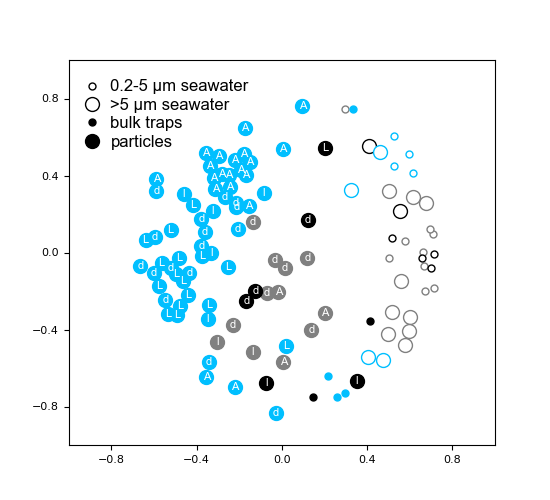

In [6]:
plt.figure(figsize=(5.5,5))
plt.plot(trap_surface_MDS_df[0][Sta1_surface_small_loc_rarified],trap_surface_MDS_df[1][Sta1_surface_small_loc_rarified],ms=5,marker='o',lw=0,color='white',mec='grey',label='St1 seawater (small)')
plt.plot(trap_surface_MDS_df[0][Sta2_surface_small_loc_rarified],trap_surface_MDS_df[1][Sta2_surface_small_loc_rarified],ms=5,marker='o',lw=0,color='white',mec='black',label='St1 seawater (small)')
plt.plot(trap_surface_MDS_df[0][Sta3_surface_small_loc_rarified],trap_surface_MDS_df[1][Sta3_surface_small_loc_rarified],ms=5,marker='o',lw=0,color='white',mec='deepskyblue',label='St1 seawater (small)')
plt.plot(trap_surface_MDS_df[0][Sta1_surface_large_loc_rarified],trap_surface_MDS_df[1][Sta1_surface_large_loc_rarified],ms=10,marker='o',lw=0,color='white',mec='grey',label='St1 seawater (large)')
plt.plot(trap_surface_MDS_df[0][Sta2_surface_large_loc_rarified],trap_surface_MDS_df[1][Sta2_surface_large_loc_rarified],ms=10,marker='o',lw=0,color='white',mec='black',label='St1 seawater (large)')
plt.plot(trap_surface_MDS_df[0][Sta3_surface_large_loc_rarified],trap_surface_MDS_df[1][Sta3_surface_large_loc_rarified],ms=10,marker='o',lw=0,color='white',mec='deepskyblue',label='St1 seawater (large)')
plt.plot(trap_surface_MDS_df[0][Sta1_particle_loc_rarified],trap_surface_MDS_df[1][Sta1_particle_loc_rarified],marker='o',ms=10,lw=0,color='grey',mec='grey',label='St1 trap')
plt.plot(trap_surface_MDS_df[0][Sta2_particle_loc_rarified],trap_surface_MDS_df[1][Sta2_particle_loc_rarified],marker='o',ms=10,lw=0,color='black',mec='black',label='St2 trap')
plt.plot(trap_surface_MDS_df[0][Sta3_particle_loc_rarified],trap_surface_MDS_df[1][Sta3_particle_loc_rarified],marker='o',ms=10,lw=0,color='deepskyblue',mec='deepskyblue', label='St3 trap')
plt.plot(trap_surface_MDS_df[0][Sta1_bulktrap_loc_rarified],trap_surface_MDS_df[1][Sta1_bulktrap_loc_rarified],marker='o',ms=5,lw=0,color='grey',mec='grey',label='St1 particle')
plt.plot(trap_surface_MDS_df[0][Sta2_bulktrap_loc_rarified],trap_surface_MDS_df[1][Sta2_bulktrap_loc_rarified],marker='o',ms=5,lw=0,color='black',mec='black',label='St2 particle')
plt.plot(trap_surface_MDS_df[0][Sta3_bulktrap_loc_rarified],trap_surface_MDS_df[1][Sta3_bulktrap_loc_rarified],marker='o',ms=5,lw=0,color='deepskyblue',mec='deepskyblue',label='St3 particle')


for x in np.arange(0,len(trap_surface_MDS_df[0])):
    if ID_list_rarified[x]=='aggregate':
        plt.text(trap_surface_MDS_df[0][x],trap_surface_MDS_df[1][x],'A',family='Arial',size=8,color='white',horizontalalignment='center',verticalalignment='center')
    if ID_list_rarified[x]=='large_loose':
        plt.text(trap_surface_MDS_df[0][x],trap_surface_MDS_df[1][x],'L',family='Arial',size=8,color='white',horizontalalignment='center',verticalalignment='center')
    if ID_list_rarified[x]=='dense':
        plt.text(trap_surface_MDS_df[0][x],trap_surface_MDS_df[1][x],'d',family='Arial',size=8,color='white',horizontalalignment='center',verticalalignment='center')
    if ID_list_rarified[x]=='long_fp':
        plt.text(trap_surface_MDS_df[0][x],trap_surface_MDS_df[1][x],'l',family='Arial',size=8,color='white',horizontalalignment='center',verticalalignment='center')

plt.xlim(-1,1)
plt.xticks([-0.8,-0.4,0,0.4,0.8],size=8)
plt.ylim(-1,1)
plt.yticks([-0.8,-0.4,0,0.4,0.8],size=8)


custom_lines = [Line2D([0], [0], color='white',mec='black',marker = 'o',lw=0,ms=5),
               Line2D([0], [0], color='white',mec='black',marker = 'o',lw=0,ms=10),
               Line2D([0], [0], color='black',mec='black',marker = 'o',lw=0,ms=5),
               Line2D([0], [0], color='black',mec='black',marker = 'o',lw=0,ms=10)]
plt.legend(custom_lines,['0.2-5 μm seawater','>5 μm seawater','bulk traps','particles'],title_fontsize=7,labelspacing=0.2,handletextpad=0.1,frameon=False,loc=[0,0.75],prop={'family':'Arial','size':12})


## All 18S data groups samples largely by the way they were collected.  Within a sample type, they seem to separte by oligotrophic vs. coastal.


## Visualize the taxa driving these differences, based in relative read abundances

In [7]:
ts_taxa2=[]
ts_taxa3=[]
ts_taxa4=[]
ts_taxa5=[]
ts_taxa6=[]
ts_taxa7=[]

for x in Traps_surface_taxonomy.Taxon:
    words=x.split(';')
    try:
        ts_taxa2.append(words[2])
    except:
        ts_taxa2.append('None')
        ts_taxa3.append('None')
        ts_taxa4.append('None')
        ts_taxa5.append('None')
        ts_taxa6.append('None')
        ts_taxa7.append('None')
        continue
    try:
        ts_taxa3.append(words[3])
    except:
        try:
            ts_taxa3.append(words[2])
        except:
            ts_taxa3.append('None')
    try:
        ts_taxa4.append(words[4])
    except:
        try:
            ts_taxa4.append(words[3])
        except:    
            ts_taxa4.append(words[2])
    try:
        ts_taxa5.append(words[5])
    except:
        try:
            ts_taxa5.append(words[4])
        except:
            try:
                ts_taxa5.append(words[3])
            except:
                ts_taxa5.append(words[2])
    try:
        ts_taxa6.append(words[6])
    except:
        try:
            ts_taxa6.append(words[5])
        except:
            try:
                ts_taxa6.append(words[4])
            except:
                try:
                    ts_taxa6.append(words[3])
                except:
                    ts_taxa6.append(words[2])
    try:
        ts_taxa7.append(words[7])
    except:
        try:
            ts_taxa7.append(words[6])
        except:
            try:
                ts_taxa7.append(words[5])
            except:
                try:
                    ts_taxa7.append(words[4])
                except:
                    try:
                        ts_taxa7.append(words[3])
                    except:
                        ts_taxa7.append(words[2])
                
Traps_surface_taxonomy['taxa2']=ts_taxa2
Traps_surface_taxonomy['taxa3']=ts_taxa3
Traps_surface_taxonomy['taxa4']=ts_taxa4
Traps_surface_taxonomy['taxa5']=ts_taxa5
Traps_surface_taxonomy['taxa6']=ts_taxa6
Traps_surface_taxonomy['taxa7']=ts_taxa7
Traps_surface_taxonomy['OTU_ID']=Traps_surface_taxonomy['Feature ID']

Traps_surface_feature_table_wIDs_allDATA=pd.merge(Traps_surface_feature_table,Traps_surface_taxonomy,on='OTU_ID',how='left')


In [8]:
rarified_for_BC=rarified_trap_surface_feature_table.drop('OTU_ID',axis=1).T.astype('float')
bc_matrix_condensed_total = pdist(np.asarray(rarified_for_BC),metric = 'braycurtis')
linkage_matrix_total = linkage(bc_matrix_condensed_total, "ward")

rarified_Traps_surface_feature_table_wIDs_wTaxa=pd.merge(rarified_trap_surface_feature_table,Traps_surface_taxonomy,on='OTU_ID',how='left')
rarified_Traps_surface_feature_table_wIDs_group3Taxa=rarified_trap_surface_feature_table.groupby(rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa4).sum()
rarified_Traps_surface_feature_table_wIDs_group3Taxa

cluster_plot=dendrogram(linkage_matrix_total, labels = St_list_rarified,leaf_font_size=8,no_plot=True,show_leaf_counts=False,leaf_rotation=0,above_threshold_color='black',color_threshold=2)
clustered_sample_order_total = rarified_trap_surface_feature_table.drop('OTU_ID',axis=1).T.iloc[cluster_plot['leaves']].index
clustered_sample_order_total
most_abundant_taxa3_total=list(rarified_Traps_surface_feature_table_wIDs_group3Taxa.index[rarified_Traps_surface_feature_table_wIDs_group3Taxa.sum(axis=1)/np.sum(rarified_Traps_surface_feature_table_wIDs_group3Taxa.sum(axis=1))>0.01])

print(most_abundant_taxa3_total)
  
most_abundant_taxa3=['Prasinococcales','Mamiellales', 'Pelagomonadales',  'Dinophyceae', 'Gymnodiniales','Crustacea','Cnidaria_X','Ctenophora_X','Dino-Group-I', 'Dino-Group-II']
rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant=rarified_Traps_surface_feature_table_wIDs_group3Taxa.reindex((most_abundant_taxa3))
taxa3_total_colors=['darkgreen','yellowgreen','gold','deeppink','darkorchid','black','grey','pink','navy','deepskyblue']


['Cnidaria_X', 'Crustacea', 'Ctenophora_X', 'Dino-Group-I', 'Dino-Group-II', 'Dinophyceae', 'Gymnodiniales', 'Mamiellales', 'Pelagomonadales', 'Prasinococcales']


In [9]:
St2_samples_rarified=list(St2_samples.copy())
St2_samples_rarified.remove('32')
rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[small_seawater_samples]
rarified_St1_2_surface_feature_table_TOTAL_group3Taxa_abundant=rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[list(St1_samples)+(St2_samples_rarified)]
rarified_St3_surface_feature_table_TOTAL_group3Taxa_abundant=rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[list(St3_samples)]
Oligotrophic_small_sw_samples=[]
Oligotrophic_large_sw_samples=[]
Oligotrophic_bulk_trap_samples=[]
Oligotrophic_particle_samples=[]


coastal_small_sw_samples=[]
coastal_large_sw_samples=[]
coastal_bulk_trap_samples=[]
coastal_particle_samples=[]


for x in list(rarified_St1_2_surface_feature_table_TOTAL_group3Taxa_abundant):
    if x in small_seawater_samples:
        Oligotrophic_small_sw_samples.append(x)
    if x in large_seawater_samples:
        Oligotrophic_large_sw_samples.append(x)
    if x in fresh_samples:
        Oligotrophic_bulk_trap_samples.append(x)
    if x in rnalater_samples:
        Oligotrophic_bulk_trap_samples.append(x)
    if x in agg_samples:
        Oligotrophic_particle_samples.append(x)
    if x in long_samples:
        Oligotrophic_particle_samples.append(x)
    if x in large_samples:
        Oligotrophic_particle_samples.append(x)
    if x in dense_samples:
        Oligotrophic_particle_samples.append(x)
for x in list(rarified_St3_surface_feature_table_TOTAL_group3Taxa_abundant):
    if x in small_seawater_samples:
        coastal_small_sw_samples.append(x)
    if x in large_seawater_samples:
        coastal_large_sw_samples.append(x)
    if x in fresh_samples:
        coastal_bulk_trap_samples.append(x)
    if x in rnalater_samples:
        coastal_bulk_trap_samples.append(x)
    if x in agg_samples:
        coastal_particle_samples.append(x)
    if x in long_samples:
        coastal_particle_samples.append(x)
    if x in large_samples:
        coastal_particle_samples.append(x)
    if x in dense_samples:
        coastal_particle_samples.append(x)
        
Mean_rarified_oligotrophic_small_sw=np.mean(rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[Oligotrophic_small_sw_samples]/31993,axis=1)
Mean_rarified_coastal_small_sw=np.mean(rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[coastal_small_sw_samples]/31993,axis=1)
Mean_rarified_coastal_bulk_trap=np.mean(rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[coastal_bulk_trap_samples]/31993,axis=1)
Mean_rarified_coastal_particles=np.mean(rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[coastal_particle_samples]/31993,axis=1)
Mean_rarified_oligotrophic_bulk_trap=np.mean(rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[Oligotrophic_bulk_trap_samples]/31993,axis=1)
Mean_rarified_oligotrophic_particles=np.mean(rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[Oligotrophic_particle_samples]/31993,axis=1)
Mean_rarified_oligotrophic_large_sw=np.mean(rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[Oligotrophic_large_sw_samples]/31993,axis=1)
Mean_rarified_coastal_large_sw=np.mean(rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[coastal_large_sw_samples]/31993,axis=1)


<IPython.core.display.Javascript object>


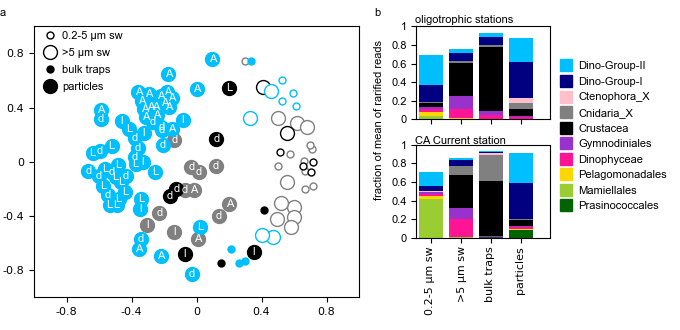

Text(0.61, 0.565, 'CA Current station')

In [10]:
fig=plt.figure(figsize=(6.8,3.3))
gs = fig.add_gridspec(5, 7,wspace=1.5,hspace=0.75,top=0.92,bottom=0.1,left=0.05,right=0.95)

ax1 = fig.add_subplot(gs[:,0:4])


ax1.plot(trap_surface_MDS_df[0][Sta1_surface_small_loc_rarified],trap_surface_MDS_df[1][Sta1_surface_small_loc_rarified],ms=5,marker='o',lw=0,color='white',mec='grey',label='St1 seawater (small)')
ax1.plot(trap_surface_MDS_df[0][Sta2_surface_small_loc_rarified],trap_surface_MDS_df[1][Sta2_surface_small_loc_rarified],ms=5,marker='o',lw=0,color='white',mec='black',label='St1 seawater (small)')
ax1.plot(trap_surface_MDS_df[0][Sta3_surface_small_loc_rarified],trap_surface_MDS_df[1][Sta3_surface_small_loc_rarified],ms=5,marker='o',lw=0,color='white',mec='deepskyblue',label='St1 seawater (small)')
ax1.plot(trap_surface_MDS_df[0][Sta1_surface_large_loc_rarified],trap_surface_MDS_df[1][Sta1_surface_large_loc_rarified],ms=10,marker='o',lw=0,color='white',mec='grey',label='St1 seawater (large)')
ax1.plot(trap_surface_MDS_df[0][Sta2_surface_large_loc_rarified],trap_surface_MDS_df[1][Sta2_surface_large_loc_rarified],ms=10,marker='o',lw=0,color='white',mec='black',label='St1 seawater (large)')
ax1.plot(trap_surface_MDS_df[0][Sta3_surface_large_loc_rarified],trap_surface_MDS_df[1][Sta3_surface_large_loc_rarified],ms=10,marker='o',lw=0,color='white',mec='deepskyblue',label='St1 seawater (large)')
ax1.plot(trap_surface_MDS_df[0][Sta1_particle_loc_rarified],trap_surface_MDS_df[1][Sta1_particle_loc_rarified],marker='o',ms=10,lw=0,color='grey',mec='grey',label='St1 trap')
ax1.plot(trap_surface_MDS_df[0][Sta2_particle_loc_rarified],trap_surface_MDS_df[1][Sta2_particle_loc_rarified],marker='o',ms=10,lw=0,color='black',mec='black',label='St2 trap')
ax1.plot(trap_surface_MDS_df[0][Sta3_particle_loc_rarified],trap_surface_MDS_df[1][Sta3_particle_loc_rarified],marker='o',ms=10,lw=0,color='deepskyblue',mec='deepskyblue', label='St3 trap')
ax1.plot(trap_surface_MDS_df[0][Sta1_bulktrap_loc_rarified],trap_surface_MDS_df[1][Sta1_bulktrap_loc_rarified],marker='o',ms=5,lw=0,color='grey',mec='grey',label='St1 particle')
ax1.plot(trap_surface_MDS_df[0][Sta2_bulktrap_loc_rarified],trap_surface_MDS_df[1][Sta2_bulktrap_loc_rarified],marker='o',ms=5,lw=0,color='black',mec='black',label='St2 particle')
ax1.plot(trap_surface_MDS_df[0][Sta3_bulktrap_loc_rarified],trap_surface_MDS_df[1][Sta3_bulktrap_loc_rarified],marker='o',ms=5,lw=0,color='deepskyblue',mec='deepskyblue',label='St3 particle')


for x in np.arange(0,len(trap_surface_MDS_df[0])):
    if ID_list_rarified[x]=='aggregate':
        ax1.text(trap_surface_MDS_df[0][x],trap_surface_MDS_df[1][x],'A',family='Arial',size=8,color='white',horizontalalignment='center',verticalalignment='center')
    if ID_list_rarified[x]=='large_loose':
        ax1.text(trap_surface_MDS_df[0][x],trap_surface_MDS_df[1][x],'L',family='Arial',size=8,color='white',horizontalalignment='center',verticalalignment='center')
    if ID_list_rarified[x]=='dense':
        ax1.text(trap_surface_MDS_df[0][x],trap_surface_MDS_df[1][x],'d',family='Arial',size=8,color='white',horizontalalignment='center',verticalalignment='center')
    if ID_list_rarified[x]=='long_fp':
        ax1.text(trap_surface_MDS_df[0][x],trap_surface_MDS_df[1][x],'l',family='Arial',size=8,color='white',horizontalalignment='center',verticalalignment='center')

ax1.set_xlim(-1,1)
ax1.set_xticks([-0.8,-0.4,0,0.4,0.8])
ax1.set_xticklabels([-0.8,-0.4,0,0.4,0.8],size=8)
ax1.set_ylim(-1,1)
ax1.set_yticks([-0.8,-0.4,0,0.4,0.8])
ax1.set_yticklabels([-0.8,-0.4,0,0.4,0.8],size=8)


custom_lines = [Line2D([0], [0], color='white',mec='black',marker = 'o',lw=0,ms=5),
               Line2D([0], [0], color='white',mec='black',marker = 'o',lw=0,ms=10),
               Line2D([0], [0], color='black',mec='black',marker = 'o',lw=0,ms=5),
               Line2D([0], [0], color='black',mec='black',marker = 'o',lw=0,ms=10)]
ax1.legend(custom_lines,['0.2-5 μm sw','>5 μm sw','bulk traps','particles'],title_fontsize=7,labelspacing=0.65,handletextpad=0.1,frameon=False,loc=[0,0.74],prop={'family':'Arial','size':8})

ax2 = fig.add_subplot(gs[0:2,4:6])
bottom = np.array([0,0,0,0])
count = 0
for x in (Mean_rarified_oligotrophic_small_sw.index):
    ax2.bar(np.arange(0,4),np.array([Mean_rarified_oligotrophic_small_sw.loc[x],Mean_rarified_oligotrophic_large_sw.loc[x],Mean_rarified_oligotrophic_bulk_trap.loc[x],Mean_rarified_oligotrophic_particles.loc[x]]),bottom = bottom,color=taxa3_total_colors[count])
    bottom = bottom + np.array([Mean_rarified_oligotrophic_small_sw.loc[x],Mean_rarified_oligotrophic_large_sw.loc[x],Mean_rarified_oligotrophic_bulk_trap.loc[x],Mean_rarified_oligotrophic_particles.loc[x]])
    count=count+1
ax2.set_xticks([0,1,2,3])
ax2.set_xticklabels(['','','',''])
ax2.set_xlim(-0.5,4)
ax2.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax2.set_yticklabels(['0','0.2','0.4','0.6','0.8','1'],fontsize=8,family='Arial')


fig.text(0.55,0.4,'fraction of mean of rarified reads',size=8,family='Arial',rotation=90)

ax3 = fig.add_subplot(gs[2:4,4:6])
bottom = np.array([0,0,0,0])
count = 0
for x in (Mean_rarified_coastal_small_sw.index):
    ax3.bar(np.arange(0,4),np.array([Mean_rarified_coastal_small_sw.loc[x],Mean_rarified_coastal_large_sw.loc[x],Mean_rarified_coastal_bulk_trap.loc[x],Mean_rarified_coastal_particles.loc[x]]),bottom = bottom,color=taxa3_total_colors[count])
    bottom = bottom + np.array([Mean_rarified_coastal_small_sw.loc[x],Mean_rarified_coastal_large_sw.loc[x],Mean_rarified_coastal_bulk_trap.loc[x],Mean_rarified_coastal_particles.loc[x]])
    count=count+1
ax3.set_xticks([0,1,2,3])
ax3.set_xticklabels(['','','',''])
ax3.set_xlim(-0.5,4)
ax3.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax3.set_yticklabels(['0','0.2','0.4','0.6','0.8','1'],fontsize=8,family='Arial')

ax4 = fig.add_subplot(gs[4,4:6])
ax4.axis('off')
ax4.text(0.1,1.5,'0.2-5 μm sw',rotation=90,size=8,va='top',ha='center')
ax4.text(0.34,1.5,'>5 μm sw',rotation=90,size=8,va='top',ha='center')
ax4.text(0.55,1.5,'bulk traps',rotation=90,size=8,va='top',ha='center')
ax4.text(0.77,1.5,'particles',rotation=90,size=8,va='top',ha='center')

ax5 = fig.add_subplot(gs[:,6])
ax5.axis('off')

custom_lines = [Line2D([0], [0], color=taxa3_total_colors[9],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=taxa3_total_colors[8],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=taxa3_total_colors[7],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=taxa3_total_colors[6],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=taxa3_total_colors[5],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=taxa3_total_colors[4],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=taxa3_total_colors[3],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=taxa3_total_colors[2],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=taxa3_total_colors[1],marker = 's',lw=0,ms=8),
               Line2D([0], [0], color=taxa3_total_colors[0],marker = 's',lw=0,ms=8)]
ax5.legend(custom_lines,np.flip(most_abundant_taxa3),title_fontsize=7,labelspacing=0.5,handletextpad=0.1,frameon=False,loc=[-1.5,0.3],prop={'family':'Arial','size':8})
fig.text(0.0,0.95,'a',family='Arial',size=8)
fig.text(0.55,0.95,'b',family='Arial',size=8)

fig.text(0.61,0.93,'oligotrophic stations',family='Arial',size=8)
fig.text(0.61,0.565,'CA Current station',family='Arial',size=8)



<IPython.core.display.Javascript object>


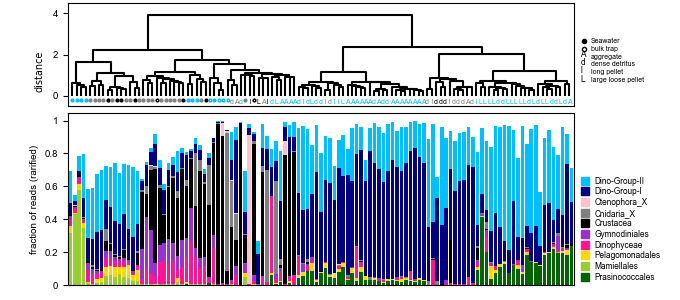

In [11]:
f,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,gridspec_kw={'height_ratios': [1.5,2.5],'width_ratios':[10,1]},figsize=[6.8,3])
cluster_plot_total=dendrogram(linkage_matrix_total, no_labels=True, get_leaves=True,labels = St_list_rarified,leaf_font_size=8,show_leaf_counts=False,leaf_rotation=0,above_threshold_color='black',color_threshold=0,ax=ax1)
ax1.text(-80,0.3,'distance',rotation=90,size=7)
St_color_array_cluster_order=St_color_array_rarified[cluster_plot_total['leaves']]
ID_array=np.array(ID_list_rarified)
ID_array_cluster_order=ID_array[cluster_plot_total['leaves']]
for x in np.arange(0,113):
    if ID_array_cluster_order[x]=='seawater':
        ax1.plot(x*10+5,-0.2,marker='o',ms=2,color=St_color_array_cluster_order[x])
    if ID_array_cluster_order[x]=='fresh':
        ax1.plot(x*10+5,-0.2,marker='o',mfc='white',ms=2,color=St_color_array_cluster_order[x])
    if ID_array_cluster_order[x]=='rnalater':
        ax1.plot(x*10+5,-0.2,marker='o',mfc='white',ms=2,color=St_color_array_cluster_order[x])
    if ID_array_cluster_order[x]=='aggregate':
        ax1.text(x*10,-0.4,'A',color=St_color_array_cluster_order[x],fontsize=5,family='Arial')
    if ID_array_cluster_order[x]=='large_loose':
        ax1.text(x*10,-0.4,'L',color=St_color_array_cluster_order[x],fontsize=5,family='Arial')
    if ID_array_cluster_order[x]=='long_fp':
        ax1.text(x*10,-0.4,' l',color=St_color_array_cluster_order[x],fontsize=5,family='Arial')
    if ID_array_cluster_order[x]=='dense':
        ax1.text(x*10,-0.4,'d',color=St_color_array_cluster_order[x],fontsize=5,family='Arial')

ax1.set_ylim(-0.5,4.5)
ax1.set_xlim(-5,1135)
ax1.set_yticks([0,2,4])    
ax1.set_yticklabels(['0','2','4'],fontsize=7,family='Arial')    

ax2.axis('off')

custom_lines = [Line2D([0], [0], color='black',marker = 'o',lw=0,ms=3),
               Line2D([0], [0], color='black',marker = 'o',mfc='white',lw=0,ms=3),
               Line2D([0], [0], color='black',marker = '',lw=0,ms=3),
               Line2D([0], [0], color='black',marker = '',lw=0,ms=3),
               Line2D([0], [0], color='black',marker = '',lw=0,ms=3),
               Line2D([0], [0], color='black',marker = '',lw=0,ms=3)]
ax2.legend(custom_lines,['Seawater','bulk trap','aggregate','dense detritus','long pellet','large loose pellet'],labelspacing=0.2,handletextpad=0.1,frameon=False,loc=[-1.1,0.2],prop={'family':'Arial','size':5})
ax2.text(-0.97,0.48,'A',size=6,family='Arial')
ax2.text(-0.97,0.4,'d',size=6,family='Arial')
ax2.text(-0.97,0.32,'l',size=6,family='Arial')
ax2.text(-0.97,0.23,'L',size=6,family='Arial')


bottom = 0
count = 0
for x in (rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[clustered_sample_order_total].index):
    ax3.bar(np.arange(0,len(list(rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[clustered_sample_order_total]))),rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[clustered_sample_order_total].loc[x]/rarified_Traps_surface_feature_table_wIDs_group3Taxa[clustered_sample_order_total].sum(),bottom = bottom,color=taxa3_total_colors[count])
    bottom = bottom + rarified_Traps_surface_feature_table_TOTAL_group3Taxa_abundant[clustered_sample_order_total].loc[x]/rarified_Traps_surface_feature_table_wIDs_group3Taxa[clustered_sample_order_total].sum()
    ax3.set_xticks([])
    count=count+1
ax3.set_ylabel('fraction of reads (rarified)',size=7,family='Arial')
ax3.set_xlim(-0.5,112.5)
ax3.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax3.set_yticklabels(['0','0.2','0.4','0.6','0.8','1'],fontsize=7,family='Arial')

ax4.axis('off')

custom_lines = [Line2D([0], [0], color=taxa3_total_colors[9],marker = 's',lw=0,ms=6),
               Line2D([0], [0], color=taxa3_total_colors[8],marker = 's',lw=0,ms=6),
               Line2D([0], [0], color=taxa3_total_colors[7],marker = 's',lw=0,ms=6),
               Line2D([0], [0], color=taxa3_total_colors[6],marker = 's',lw=0,ms=6),
               Line2D([0], [0], color=taxa3_total_colors[5],marker = 's',lw=0,ms=6),
               Line2D([0], [0], color=taxa3_total_colors[4],marker = 's',lw=0,ms=6),
               Line2D([0], [0], color=taxa3_total_colors[3],marker = 's',lw=0,ms=6),
               Line2D([0], [0], color=taxa3_total_colors[2],marker = 's',lw=0,ms=6),
               Line2D([0], [0], color=taxa3_total_colors[1],marker = 's',lw=0,ms=6),
               Line2D([0], [0], color=taxa3_total_colors[0],marker = 's',lw=0,ms=6),]
ax4.legend(custom_lines,np.flip(most_abundant_taxa3),title_fontsize=7,labelspacing=0.2,handletextpad=0.1,frameon=False,loc=[-1.1,0],prop={'family':'Arial','size':6})
f.subplots_adjust(bottom=0.05,top=0.99,left=0.1,right=1,hspace=0.05)

## Test whether sample communities are significantly different from one another

In [12]:
Trap_only_data=rarified_trap_surface_feature_table.drop('OTU_ID',axis=1).T.copy()
Trap_only_data['grouping2']=grouping2_rarified
Trap_only_data['ID']=np.array(ID_list_rarified)
Trap_only_data['Incubation_time']=np.array(Incubation_time_list_rarified)
Trap_only_data=Trap_only_data.iloc[np.array(Sta1_trap_loc_rarified+Sta2_trap_loc_rarified+Sta3_trap_loc_rarified)]
Particle_only_data=Trap_only_data.drop(['T1','T2','T4','T5','T7','T8'])
Oligotrophic_particles_data=Particle_only_data[Particle_only_data.grouping2!='St3']
St3_particles_data=Particle_only_data[Particle_only_data.grouping2=='St3']
St3_particles_incubation_time_grouping=St3_particles_data['Incubation_time']
St3_agg_large_data=St3_particles_data[St3_particles_data.ID!='dense']
St3_agg_large_data=St3_agg_large_data[St3_agg_large_data.ID!='long_fp']
St3_IDs=np.array(St3_particles_data.ID)
St3_agg_large_IDs=np.array(St3_agg_large_data.ID)
Particle_only_grouping2=np.array(Particle_only_data.grouping2)
Oligotrophic_Particle_only_grouping2=np.array(Oligotrophic_particles_data.grouping2)
Particle_only_data=Particle_only_data.drop(['grouping2','ID','Incubation_time'],axis=1)
Oligotrophic_particles_data=Oligotrophic_particles_data.drop(['grouping2','ID','Incubation_time'],axis=1)
St3_particles_data=St3_particles_data.drop(['grouping2','ID','Incubation_time'],axis=1)
St3_agg_large_data=St3_agg_large_data.drop(['grouping2','ID','Incubation_time'],axis=1)


In [13]:
## Test whether particles collected at oligotrophic stations are different from coast
BC_particles_only=dist.pairwise(np.asmatrix(Particle_only_data))
BC_oligo_particles_only=dist.pairwise(np.asmatrix(Oligotrophic_particles_data))
BC_St3_particles_only=dist.pairwise(np.asmatrix(St3_particles_data))
BC_St3_agg_large=dist.pairwise(np.asmatrix(St3_agg_large_data))

#Test whether particles are different from one another across stations
print("Test whether Traps are different from one another across stations")
print("Is there a difference among particles at the 3 stations?")
print(permanova(DistanceMatrix(BC_particles_only),Particle_only_grouping2,permutations=9999))
print("Is there a difference between particles at the 2 oligotrophic stations?")
print(permanova(DistanceMatrix(BC_oligo_particles_only),Oligotrophic_Particle_only_grouping2,permutations=9999))
print("Is there a difference among particle types at the station3?")
print(permanova(DistanceMatrix(BC_St3_particles_only),St3_IDs,permutations=9999))
print("Is there a difference between aggregates and large-loose pellets at the station3?")
print(permanova(DistanceMatrix(BC_St3_agg_large),St3_agg_large_IDs,permutations=9999))
print("Is there a difference particles incubated for different periods of time at station3?")
print(permanova(DistanceMatrix(BC_St3_particles_only),St3_particles_incubation_time_grouping,permutations=9999))



Test whether Traps are different from one another across stations
Is there a difference among particles at the 3 stations?
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      75
number of groups                  3
test statistic             6.431889
p-value                      0.0001
number of permutations         9999
Name: PERMANOVA results, dtype: object
Is there a difference between particles at the 2 oligotrophic stations?
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      18
number of groups                  2
test statistic             2.066894
p-value                      0.0073
number of permutations         9999
Name: PERMANOVA results, dtype: object
Is there a difference among particle types at the station3?
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      57
number of groups                  4
test statistic     

In [14]:

St3_metadata=TS_metadata[TS_metadata.Station==3]
St3_agg_IDs=St3_metadata[St3_metadata.ParticleType=='aggregate'].Sample
St3_long_IDs=St3_metadata[St3_metadata.ParticleType=='long_fecal_pellet'].Sample
St3_large_IDs=St3_metadata[St3_metadata.ParticleType=='large_loose_pellet'].Sample
St3_dense_IDs=St3_metadata[St3_metadata.ParticleType=='dense_detritus'].Sample

print("Is there a difference between agg and large at station3?")
print(permanova(DistanceMatrix(dist.pairwise(np.asmatrix(rarified_trap_surface_feature_table[list(St3_agg_IDs)+list(St3_large_IDs)].T))),list(np.repeat('aggregate',len(St3_agg_IDs)))+list(np.repeat('large',len(St3_large_IDs))),permutations=9999))
print("Is there a difference between agg and long at station3?")
print(permanova(DistanceMatrix(dist.pairwise(np.asmatrix(rarified_trap_surface_feature_table[list(St3_agg_IDs)+list(St3_long_IDs)].T))),list(np.repeat('aggregate',len(St3_agg_IDs)))+list(np.repeat('long',len(St3_long_IDs))),permutations=9999))
print("Is there a difference between agg and dense at station3?")
print(permanova(DistanceMatrix(dist.pairwise(np.asmatrix(rarified_trap_surface_feature_table[list(St3_agg_IDs)+list(St3_dense_IDs)].T))),list(np.repeat('aggregate',len(St3_agg_IDs)))+list(np.repeat('dense',len(St3_dense_IDs))),permutations=9999))
print("Is there a difference between large and long at station3?")
print(permanova(DistanceMatrix(dist.pairwise(np.asmatrix(rarified_trap_surface_feature_table[list(St3_large_IDs)+list(St3_long_IDs)].T))),list(np.repeat('large',len(St3_large_IDs)))+list(np.repeat('long',len(St3_long_IDs))),permutations=9999))
print("Is there a difference between large and dense at station3?")
print(permanova(DistanceMatrix(dist.pairwise(np.asmatrix(rarified_trap_surface_feature_table[list(St3_large_IDs)+list(St3_dense_IDs)].T))),list(np.repeat('large',len(St3_large_IDs)))+list(np.repeat('dense',len(St3_dense_IDs))),permutations=9999))
print("Is there a difference between long and dense at station3?")
print(permanova(DistanceMatrix(dist.pairwise(np.asmatrix(rarified_trap_surface_feature_table[list(St3_long_IDs)+list(St3_dense_IDs)].T))),list(np.repeat('long',len(St3_long_IDs)))+list(np.repeat('dense',len(St3_dense_IDs))),permutations=9999))



Is there a difference between agg and large at station3?
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      36
number of groups                  2
test statistic            11.004458
p-value                      0.0001
number of permutations         9999
Name: PERMANOVA results, dtype: object
Is there a difference between agg and long at station3?
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      25
number of groups                  2
test statistic             2.510688
p-value                      0.0108
number of permutations         9999
Name: PERMANOVA results, dtype: object
Is there a difference between agg and dense at station3?
method name               PERMANOVA
test statistic name        pseudo-F
sample size                      36
number of groups                  2
test statistic             4.557872
p-value                      0.0002
number of permutations         9

In [15]:
pvals=[]
pvals.append(permanova(DistanceMatrix(dist.pairwise(np.asmatrix(rarified_trap_surface_feature_table[list(St3_agg_IDs)+list(St3_large_IDs)].T))),list(np.repeat('aggregate',len(St3_agg_IDs)))+list(np.repeat('large',len(St3_large_IDs))),permutations=9999)['p-value'])
pvals.append(permanova(DistanceMatrix(dist.pairwise(np.asmatrix(rarified_trap_surface_feature_table[list(St3_agg_IDs)+list(St3_dense_IDs)].T))),list(np.repeat('aggregate',len(St3_agg_IDs)))+list(np.repeat('dense',len(St3_dense_IDs))),permutations=9999)['p-value'])
pvals.append(permanova(DistanceMatrix(dist.pairwise(np.asmatrix(rarified_trap_surface_feature_table[list(St3_dense_IDs)+list(St3_large_IDs)].T))),list(np.repeat('dense',len(St3_dense_IDs)))+list(np.repeat('large',len(St3_large_IDs))),permutations=9999)['p-value'])
pvals


[0.0001, 0.0001, 0.0547]

In [16]:
#bonforonni correcton for multiple comparisons
# Create a list of the adjusted p-values
p_adjusted = multipletests(pvals, alpha=0.001, method='bonferroni')

(p_adjusted)



(array([ True,  True, False]),
 array([0.0003, 0.0003, 0.1641]),
 0.0003334445062139757,
 0.0003333333333333333)

# Use pairwise t-tests to identify taxa with significantly different relative abundances among particle types at Station 3, grouped by "taxa6" taxonomic category

In [17]:

taxa6_different=[]
for x in rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6:
    agg_fraction=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6==x][St3_agg_large_data.index[St3_agg_large_IDs=='aggregate']].sum()
    large_fraction=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6==x][St3_agg_large_data.index[St3_agg_large_IDs=='large_loose']].sum()
    tt=ttest_ind(agg_fraction,large_fraction)
    if tt.pvalue<0.0015:
        taxa6_different.append(x)
print('Taxa with significantly different relative abundances in aggregates vs. large-loose pellets:')
print(np.unique(taxa6_different))



Taxa with significantly different relative abundances in aggregates vs. large-loose pellets:
['Chloropicon' 'Dino-Group-I-Clade-1_X' 'Dino-Group-II-Clade-10-and-11_X'
 'Minidiscus' 'Prasinoderma']


In [18]:

taxa6_different_agg_largedense=[]
for x in rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6:
    agg_fraction=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6==x][St3_agg_IDs].sum()
    large_dense_fraction=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6==x][list(St3_large_IDs)+list(St3_dense_IDs)].sum()
    tt=ttest_ind(agg_fraction,large_dense_fraction)
    if tt.pvalue<0.0015:
        taxa6_different_agg_largedense.append(x)
print('Taxa with significantly different relative abundances in dense detritus vs. large-loose pellets:')
print(np.unique(taxa6_different_agg_largedense))


Taxa with significantly different relative abundances in dense detritus vs. large-loose pellets:
['Dino-Group-I-Clade-1_X' 'Dino-Group-II-Clade-10-and-11_X'
 'Dino-Group-II-Clade-25_X' 'Prasinoderma']


In [19]:
taxa6_different_agg_dense=[]
for x in rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6:
    agg_fraction=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6==x][St3_agg_IDs].sum()
    dense_fraction=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6==x][St3_dense_IDs].sum()
    tt=ttest_ind(agg_fraction,dense_fraction)
    if tt.pvalue<0.0015:
        taxa6_different_agg_dense.append(x)
        
print('Taxa with significantly different relative abundances in aggregates vs. dense detritus:')
print(np.unique(taxa6_different_agg_dense))



Taxa with significantly different relative abundances in aggregates vs. dense detritus:
['Dino-Group-II-Clade-10-and-11_X']


## aggregates and large pellets have different syndiniales types and certain green algae and diatom

## Now visualize the change in relative abundance of these taxa among particle types at Station 3, and how it may reflect differences in degradation level among particle types.

In [20]:
Photosynthetic_taxa=open('Photosynthetic_taxa_4.txt',encoding="utf-8")

Photosynthetic_taxa_loc=[]
for x in Photosynthetic_taxa:
    photosynthetic=x.strip()
    for y in Traps_surface_feature_table_wIDs_allDATA.index:
        if str(photosynthetic) in Traps_surface_feature_table_wIDs_allDATA.Taxon.loc[y]:
            Photosynthetic_taxa_loc.append(y)
Photosynthetic_taxa.close()        
Photosynthetic_Traps_surface_feature_table_wIDs_allDATA=Traps_surface_feature_table_wIDs_allDATA.loc[Photosynthetic_taxa_loc]



In [21]:
Photosynthetic_rarified_Traps_surface_feature_table_wIDs_allDATA=pd.DataFrame(columns=list(rarified_trap_surface_feature_table))
for x in Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.OTU_ID:
    Photosynthetic_rarified_Traps_surface_feature_table_wIDs_allDATA=Photosynthetic_rarified_Traps_surface_feature_table_wIDs_allDATA.append(rarified_trap_surface_feature_table[rarified_trap_surface_feature_table.OTU_ID==x],ignore_index=True)
    

In [22]:
Heterotrophic_taxa=open('Heterotrophic_taxa_4.txt',encoding="utf-8")
Heterotrophic_taxa_loc=[]
for x in Heterotrophic_taxa:
    heterotrophic = x.strip()
    for y in Traps_surface_feature_table_wIDs_allDATA.index:
        if str(heterotrophic) in Traps_surface_feature_table_wIDs_allDATA.Taxon.loc[y]:
            Heterotrophic_taxa_loc.append(y)
Heterotrophic_taxa.close()
Heterotrophic_Traps_surface_feature_table_wIDs_allDATA=Traps_surface_feature_table_wIDs_allDATA.loc[Heterotrophic_taxa_loc]


In [23]:
Heterotrophic_rarified_loc=[]
count=0
for x in Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.OTU_ID:
    try:
        Heterotrophic_rarified_loc.append(rarified_trap_surface_feature_table[rarified_trap_surface_feature_table.OTU_ID==x].index.values[0])
    except:
        count=count+1
Heterotrophic_rarified_Traps_surface_feature_table_wIDs_allDATA=rarified_trap_surface_feature_table.loc[Heterotrophic_rarified_loc]


In [24]:
seawater_samplenames=list(TS_metadata.Sample[TS_metadata.Sample_type=='Seawater'])
seawater_samplenames.remove('32')
print('Percent of reads assigned to heterotrophs')
print(str(np.mean(Heterotrophic_rarified_Traps_surface_feature_table_wIDs_allDATA.drop('OTU_ID',axis=1).sum()/(Heterotrophic_rarified_Traps_surface_feature_table_wIDs_allDATA.drop('OTU_ID',axis=1).sum()+Photosynthetic_rarified_Traps_surface_feature_table_wIDs_allDATA.drop('OTU_ID',axis=1).sum())))+' plus_minus ' + str(np.std(Heterotrophic_rarified_Traps_surface_feature_table_wIDs_allDATA.drop('OTU_ID',axis=1).sum()/(Heterotrophic_rarified_Traps_surface_feature_table_wIDs_allDATA.drop('OTU_ID',axis=1).sum()+Photosynthetic_rarified_Traps_surface_feature_table_wIDs_allDATA.drop('OTU_ID',axis=1).sum()))))

Heterotrophic_rarified_Traps_surface_feature_table_wIDs_allDATA_taxa=pd.merge(Heterotrophic_rarified_Traps_surface_feature_table_wIDs_allDATA,Traps_surface_taxonomy,on='OTU_ID',how='left')
Heterotrophic_grouped_taxa=Heterotrophic_rarified_Traps_surface_feature_table_wIDs_allDATA_taxa.groupby(Heterotrophic_rarified_Traps_surface_feature_table_wIDs_allDATA_taxa.taxa3).sum()
Heterotrophic_grouped_taxa_percents=Heterotrophic_grouped_taxa/Heterotrophic_grouped_taxa.sum()
Heterotrophic_grouped_taxa_percents_av=Heterotrophic_grouped_taxa_percents[list(TS_metadata.Sample[TS_metadata.Sample_type=='Trap'])].mean(axis=1)
Heterotrophic_grouped_taxa_percents_sd=Heterotrophic_grouped_taxa_percents[list(TS_metadata.Sample[TS_metadata.Sample_type=='Trap'])].std(axis=1)
print('Most abundant heterotrophic taxa in traps and their average percentages among samples')
print(Heterotrophic_grouped_taxa_percents_av[Heterotrophic_grouped_taxa_percents_av>0.1])
print('Standard deviation of average Syndiniales % read counts in trap samples')
print(Heterotrophic_grouped_taxa_percents_sd.loc['Syndiniales'])

seawater_Heterotrophic_grouped_taxa_percents_av=Heterotrophic_grouped_taxa_percents[seawater_samplenames].mean(axis=1)
seawater_Heterotrophic_grouped_taxa_percents_sd=Heterotrophic_grouped_taxa_percents[seawater_samplenames].std(axis=1)
print('Most abundant heterotrophic taxa in seawater and their average percentages among samples')
print(seawater_Heterotrophic_grouped_taxa_percents_av[seawater_Heterotrophic_grouped_taxa_percents_av>0.1])
print('Standard deviation of average Syndiniales % read counts in seawater samples')
print(seawater_Heterotrophic_grouped_taxa_percents_sd.loc['Syndiniales'])


Percent of reads assigned to heterotrophs
0.8031415127668078 plus_minus 0.1612728813936697
Most abundant heterotrophic taxa in traps and their average percentages among samples
taxa3
Arthropoda     0.112381
Syndiniales    0.773977
dtype: float64
Standard deviation of average Syndiniales % read counts in trap samples
0.3251115183138291
Most abundant heterotrophic taxa in seawater and their average percentages among samples
taxa3
Arthropoda     0.283580
Syndiniales    0.452107
dtype: float64
Standard deviation of average Syndiniales % read counts in seawater samples
0.27992965118974356


## Remove plant ASVs from phytoplankton dataset

In [25]:
Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa=pd.merge(Photosynthetic_rarified_Traps_surface_feature_table_wIDs_allDATA,Traps_surface_taxonomy,on='OTU_ID',how='left')
Photosynthetic_rarified_Traps_surface_feature_table_wIDs_group3Taxa=Photosynthetic_rarified_Traps_surface_feature_table_wIDs_allDATA.groupby(Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa3).sum()
Photosynthetic_rarified_Traps_surface_feature_table_wIDs_group3Taxa=Photosynthetic_rarified_Traps_surface_feature_table_wIDs_group3Taxa.drop('OTU_ID', axis=1)


In [26]:
#Traps_surface_taxonomy[Traps_surface_taxonomy.taxa3=='Embryophyceae'].Taxon.unique()
##These are vegitables and plants##
plant_ASVs=Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa3=='Embryophyceae']
plant_ASVs_St1_surface=len(plant_ASVs[plant_ASVs[['1','2', '3', '4', '5', '6', '7', '8', '9', '21', '22', '23', '24', '25', '26', '27', '28','29']].sum(axis=1)>0])
plant_ASVs_St1_particles=len(plant_ASVs[plant_ASVs[['P1','P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P12', 'P13']].sum(axis=1)>0])
St1_surface_ASVs=len(Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[['1','2', '3', '4', '5', '6', '7', '8', '9', '21', '22', '23', '24', '25', '26', '27', '28','29']].sum(axis=1)>0])
St1_particle_ASVs=len(Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[['P1','P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'P9', 'P10', 'P12', 'P13']].sum(axis=1)>0])
print('St1 fraction of particle ASVs that are plants: ' + str(plant_ASVs_St1_particles/St1_particle_ASVs))
print('St1 fraction of surface ASVs that are plants: ' + str(plant_ASVs_St1_surface/St1_surface_ASVs))

plant_ASVs_St2_surface=len(plant_ASVs[plant_ASVs[[ '10', '11', '12', '13', '30', '31']].sum(axis=1)>0])
plant_ASVs_St2_particles=len(plant_ASVs[plant_ASVs[['P15','P16', 'P18', 'P23', 'P24', 'P25']].sum(axis=1)>0])
plant_ASVs_St2_trap=len(plant_ASVs[plant_ASVs[['T1','T2']].sum(axis=1)>0])
St2_surface_ASVs=len(Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[[ '10', '11', '12', '13', '30', '31']].sum(axis=1)>0])
St2_particle_ASVs=len(Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[['P15','P16', 'P18', 'P23', 'P24', 'P25']].sum(axis=1)>0])
St2_trap_ASVs=len(Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[['T1','T2']].sum(axis=1)>0])
print('St2 fraction of particle ASVs that are plants: ' + str(plant_ASVs_St2_particles/St2_particle_ASVs))
print('St2 fraction of surface ASVs that are plants: ' + str(plant_ASVs_St2_surface/St2_surface_ASVs))
print('St2 fraction of trap ASVs that are plants: ' + str(plant_ASVs_St2_trap/St2_trap_ASVs))

plant_ASVs_St3_surface=len(plant_ASVs[plant_ASVs[[ '14','15', '16', '17', '33', '34', '35', '36']].sum(axis=1)>0])
plant_ASVs_St3_particles=len(plant_ASVs[plant_ASVs[['P27','P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P50', 'P51', 'P52', 'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P59', 'P60', 'P61', 'P62', 'P63', 'P64', 'P65', 'P66', 'P67', 'P68', 'P69', 'P70', 'P71', 'P72', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78', 'P79', 'P80', 'P81', 'P82', 'P83']].sum(axis=1)>0])
plant_ASVs_St3_trap=len(plant_ASVs[plant_ASVs[['T4','T5', 'T7', 'T8']].sum(axis=1)>0])
St3_surface_ASVs=len(Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[['14','15', '16', '17', '33', '34', '35', '36']].sum(axis=1)>0])
St3_particle_ASVs=len(Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[['P27','P28', 'P29', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P50', 'P51', 'P52', 'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P59', 'P60', 'P61', 'P62', 'P63', 'P64', 'P65', 'P66', 'P67', 'P68', 'P69', 'P70', 'P71', 'P72', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78', 'P79', 'P80', 'P81', 'P82', 'P83']].sum(axis=1)>0])
St3_trap_ASVs=len(Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[Photosynthetic_rarified_Traps_surface_feature_table_wIDs_wTaxa[['T4','T5', 'T7', 'T8']].sum(axis=1)>0])
print('St3 fraction of particle ASVs that are plants: ' + str(plant_ASVs_St3_particles/St3_particle_ASVs))
print('St3 fraction of surface ASVs that are plants: ' + str(plant_ASVs_St3_surface/St3_surface_ASVs))
print('St3 fraction of trap ASVs that are plants: ' + str(plant_ASVs_St3_trap/St3_trap_ASVs))

#Remove plants from the photosynthetic dataset since they are not phytoplankton
Photosynthetic_Traps_surface_feature_table_wIDs_allDATA=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.taxa3!='Embryophyceae']
Photosynthetic_rarified_Traps_surface_feature_table_wIDs_allDATA=pd.DataFrame(columns=list(rarified_trap_surface_feature_table))
for x in Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.OTU_ID:
    Photosynthetic_rarified_Traps_surface_feature_table_wIDs_allDATA=Photosynthetic_rarified_Traps_surface_feature_table_wIDs_allDATA.append(rarified_trap_surface_feature_table[rarified_trap_surface_feature_table.OTU_ID==x],ignore_index=True)



St1 fraction of particle ASVs that are plants: 0.014814814814814815
St1 fraction of surface ASVs that are plants: 0.0068201193520886615
St2 fraction of particle ASVs that are plants: 0.008264462809917356
St2 fraction of surface ASVs that are plants: 0.005964214711729622
St2 fraction of trap ASVs that are plants: 0.0
St3 fraction of particle ASVs that are plants: 0.025885558583106268
St3 fraction of surface ASVs that are plants: 0.011235955056179775
St3 fraction of trap ASVs that are plants: 0.0


In [27]:
phyto_asvs_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.groupby(Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.taxa3).count().OTU_ID


In [28]:
Traps_surface_feature_table_filtered=Traps_surface_feature_table[Traps_surface_feature_table.drop('OTU_ID',axis=1).sum(axis=1)>=10]


In [29]:
Photosynthetic_reads_filtered=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.copy()
Photosynthetic_reads_filtered.index=Photosynthetic_reads_filtered.OTU_ID
filtered_ASVs_photo=[]
for x in Traps_surface_feature_table_filtered.OTU_ID:
    if x in Photosynthetic_reads_filtered.index:
        filtered_ASVs_photo.append(x)

print('filtered out '+ str(len(Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.index)-len(filtered_ASVs_photo))+' photosynthetic ASVs')
print(str(len(filtered_ASVs_photo))+ ' ASVs remaining')

Photosynthetic_reads_filtered=Photosynthetic_reads_filtered.loc[filtered_ASVs_photo]
print(np.shape(Photosynthetic_reads_filtered))
Photosynthetic_reads_filtered=Photosynthetic_reads_filtered.drop(['OTU_ID','Feature ID','Taxon','Confidence','taxa2','taxa3','taxa4','taxa5','taxa6','taxa7'],axis=1)

Heterotrophic_reads_filtered=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.copy()
Heterotrophic_reads_filtered.index=Heterotrophic_reads_filtered.OTU_ID
filtered_ASVs_het=[]
for x in Traps_surface_feature_table_filtered.OTU_ID:
    if x in Heterotrophic_reads_filtered.index:
        filtered_ASVs_het.append(x)

print('filtered out '+ str(len(Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.index)-len(filtered_ASVs_het))+' heterotrophic ASVs')
print(str(len(filtered_ASVs_het))+ ' ASVs remaining')

Heterotrophic_reads_filtered=Heterotrophic_reads_filtered.loc[filtered_ASVs_het]
np.shape(Heterotrophic_reads_filtered)
Heterotrophic_reads_filtered=Heterotrophic_reads_filtered.drop(['OTU_ID','Feature ID','Taxon','Confidence','taxa2','taxa3','taxa4','taxa5','taxa6','taxa7'],axis=1)


filtered out 462 photosynthetic ASVs
2265 ASVs remaining
(2265, 124)
filtered out 1074 heterotrophic ASVs
5332 ASVs remaining


In [30]:
aggregate_IDs=TS_metadata.Sample[TS_metadata.ParticleType=='aggregate']
large_IDs=TS_metadata.Sample[TS_metadata.ParticleType=='large_loose_pellet']
long_IDs=TS_metadata.Sample[TS_metadata.ParticleType=='long_fecal_pellet']
dense_IDs=TS_metadata.Sample[TS_metadata.ParticleType=='dense_detritus']


In [31]:

WW3_t0_photo_reads=Photosynthetic_reads_filtered[list(TS_metadata[TS_metadata.Trap=='WW3'][TS_metadata[TS_metadata.Trap=='WW3'].Sample_Time==0].Sample)].drop(['T4','T5'],axis=1)
WW3_t0_agg_ID=[]
for x in list(WW3_t0_photo_reads):
    if x in list(aggregate_IDs):
        WW3_t0_agg_ID.append(x)
#####        
WW3_t0_photo_agg_reads=WW3_t0_photo_reads[WW3_t0_agg_ID]
WW3_t0_photo_agg_reads

WW3_t2_photo_reads=Photosynthetic_reads_filtered[list(TS_metadata[TS_metadata.Trap=='WW3'][TS_metadata[TS_metadata.Trap=='WW3'].Sample_Time==2].Sample)]
WW3_t2_agg_ID=[]
for x in list(WW3_t2_photo_reads):
    if x in list(aggregate_IDs):
        WW3_t2_agg_ID.append(x)
        
WW3_t2_photo_agg_reads=WW3_t2_photo_reads[WW3_t2_agg_ID]
WW3_t2_photo_agg_reads

#######
WW3_t0_large_ID=[]
for x in list(WW3_t0_photo_reads):
    if x in list(large_IDs):
        WW3_t0_large_ID.append(x)
        
WW3_t0_photo_large_reads=WW3_t0_photo_reads[WW3_t0_large_ID]
WW3_t0_photo_large_reads

WW3_t2_large_ID=[]
for x in list(WW3_t2_photo_reads):
    if x in list(large_IDs):
        WW3_t2_large_ID.append(x)
        
WW3_t2_photo_large_reads=WW3_t2_photo_reads[WW3_t2_large_ID]

######
WW3_t0_long_ID=[]
for x in list(WW3_t0_photo_reads):
    if x in list(long_IDs):
        WW3_t0_long_ID.append(x)
        
WW3_t0_photo_long_reads=WW3_t0_photo_reads[WW3_t0_long_ID]

WW3_t2_long_ID=[]
for x in list(WW3_t2_photo_reads):
    if x in list(long_IDs):
        WW3_t2_long_ID.append(x)
        
WW3_t2_photo_long_reads=WW3_t2_photo_reads[WW3_t2_long_ID]


######
WW3_t0_dense_ID=[]
for x in list(WW3_t0_photo_reads):
    if x in list(dense_IDs):
        WW3_t0_dense_ID.append(x)
        
WW3_t0_photo_dense_reads=WW3_t0_photo_reads[WW3_t0_dense_ID]

WW3_t2_dense_ID=[]
for x in list(WW3_t2_photo_reads):
    if x in list(dense_IDs):
        WW3_t2_dense_ID.append(x)
        
WW3_t2_photo_dense_reads=WW3_t2_photo_reads[WW3_t2_dense_ID]



WW4_t0_photo_reads=Photosynthetic_reads_filtered[list(TS_metadata[TS_metadata.Trap=='WW4'][TS_metadata[TS_metadata.Trap=='WW4'].Sample_Time==0].Sample)].drop(['T7','T8'],axis=1)
WW4_t0_agg_ID=[]
for x in list(WW4_t0_photo_reads):
    if x in list(aggregate_IDs):
        WW4_t0_agg_ID.append(x)
        
WW4_t0_photo_agg_reads=WW4_t0_photo_reads[WW4_t0_agg_ID]

WW4_t1_photo_reads=Photosynthetic_reads_filtered[list(TS_metadata[TS_metadata.Trap=='WW4'][TS_metadata[TS_metadata.Trap=='WW4'].Sample_Time==1].Sample)]
WW4_t1_agg_ID=[]
for x in list(WW4_t1_photo_reads):
    if x in list(aggregate_IDs):
        WW4_t1_agg_ID.append(x)
        
WW4_t1_photo_agg_reads=WW4_t1_photo_reads[WW4_t1_agg_ID]
WW4_t1_photo_agg_reads

#######
WW4_t0_large_ID=[]
for x in list(WW4_t0_photo_reads):
    if x in list(large_IDs):
        WW4_t0_large_ID.append(x)
        
WW4_t0_photo_large_reads=WW4_t0_photo_reads[WW4_t0_large_ID]
WW4_t0_photo_large_reads

WW4_t1_large_ID=[]
for x in list(WW4_t1_photo_reads):
    if x in list(large_IDs):
        WW4_t1_large_ID.append(x)
        
WW4_t1_photo_large_reads=WW4_t1_photo_reads[WW4_t1_large_ID]

#####
WW4_t0_long_ID=[]
for x in list(WW4_t0_photo_reads):
    if x in list(long_IDs):
        WW4_t0_long_ID.append(x)
        
WW4_t0_photo_long_reads=WW4_t0_photo_reads[WW4_t0_long_ID]

WW4_t1_long_ID=[]
for x in list(WW4_t1_photo_reads):
    if x in list(long_IDs):
        WW4_t1_long_ID.append(x)
        
WW4_t1_photo_long_reads=WW4_t1_photo_reads[WW4_t1_long_ID]


####
WW4_t0_dense_ID=[]
for x in list(WW4_t0_photo_reads):
    if x in list(dense_IDs):
        WW4_t0_dense_ID.append(x)
        
WW4_t0_photo_dense_reads=WW4_t0_photo_reads[WW4_t0_dense_ID]


WW4_t1_dense_ID=[]
for x in list(WW4_t1_photo_reads):
    if x in list(dense_IDs):
        WW4_t1_dense_ID.append(x)
        
WW4_t1_photo_dense_reads=WW4_t1_photo_reads[WW4_t1_dense_ID]



In [32]:
WW3_t0_het_reads=Heterotrophic_reads_filtered[list(TS_metadata[TS_metadata.Trap=='WW3'][TS_metadata[TS_metadata.Trap=='WW3'].Sample_Time==0].Sample)].drop(['T4','T5'],axis=1)
WW3_t0_agg_ID=[]
for x in list(WW3_t0_het_reads):
    if x in list(aggregate_IDs):
        WW3_t0_agg_ID.append(x)
        
WW3_t0_het_agg_reads=WW3_t0_het_reads[WW3_t0_agg_ID]
WW3_t0_het_agg_reads

WW3_t2_het_reads=Heterotrophic_reads_filtered[list(TS_metadata[TS_metadata.Trap=='WW3'][TS_metadata[TS_metadata.Trap=='WW3'].Sample_Time==2].Sample)]
WW3_t2_agg_ID=[]
for x in list(WW3_t2_het_reads):
    if x in list(aggregate_IDs):
        WW3_t2_agg_ID.append(x)
        
WW3_t2_het_agg_reads=WW3_t2_het_reads[WW3_t2_agg_ID]
WW3_t2_het_agg_reads


#######
WW3_t0_large_ID=[]
for x in list(WW3_t0_het_reads):
    if x in list(large_IDs):
        WW3_t0_large_ID.append(x)
        
WW3_t0_het_large_reads=WW3_t0_het_reads[WW3_t0_large_ID]

WW3_t2_large_ID=[]
for x in list(WW3_t2_het_reads):
    if x in list(large_IDs):
        WW3_t2_large_ID.append(x)
        
WW3_t2_het_large_reads=WW3_t2_het_reads[WW3_t2_large_ID]

########
WW3_t0_long_ID=[]
for x in list(WW3_t0_het_reads):
    if x in list(long_IDs):
        WW3_t0_long_ID.append(x)
        
WW3_t0_het_long_reads=WW3_t0_het_reads[WW3_t0_long_ID]

WW3_t2_long_ID=[]
for x in list(WW3_t2_het_reads):
    if x in list(long_IDs):
        WW3_t2_long_ID.append(x)
        
WW3_t2_het_long_reads=WW3_t2_het_reads[WW3_t2_long_ID]

######
WW3_t0_dense_ID=[]
for x in list(WW3_t0_het_reads):
    if x in list(dense_IDs):
        WW3_t0_dense_ID.append(x)
        
WW3_t0_het_dense_reads=WW3_t0_het_reads[WW3_t0_dense_ID]

WW3_t2_dense_ID=[]
for x in list(WW3_t2_het_reads):
    if x in list(dense_IDs):
        WW3_t2_dense_ID.append(x)
        
WW3_t2_het_dense_reads=WW3_t2_het_reads[WW3_t2_dense_ID]

#####
WW4_t0_het_reads=Heterotrophic_reads_filtered[list(TS_metadata[TS_metadata.Trap=='WW4'][TS_metadata[TS_metadata.Trap=='WW4'].Sample_Time==0].Sample)].drop(['T7','T8'],axis=1)
WW4_t0_agg_ID=[]
for x in list(WW4_t0_het_reads):
    if x in list(aggregate_IDs):
        WW4_t0_agg_ID.append(x)
        
WW4_t0_het_agg_reads=WW4_t0_het_reads[WW4_t0_agg_ID]

WW4_t1_het_reads=Heterotrophic_reads_filtered[list(TS_metadata[TS_metadata.Trap=='WW4'][TS_metadata[TS_metadata.Trap=='WW4'].Sample_Time==1].Sample)]
WW4_t1_agg_ID=[]
for x in list(WW4_t1_het_reads):
    if x in list(aggregate_IDs):
        WW4_t1_agg_ID.append(x)
        
WW4_t1_het_agg_reads=WW4_t1_het_reads[WW4_t1_agg_ID]
WW4_t1_het_agg_reads

##########
WW4_t0_large_ID=[]
for x in list(WW4_t0_het_reads):
    if x in list(large_IDs):
        WW4_t0_large_ID.append(x)
        
WW4_t0_het_large_reads=WW4_t0_het_reads[WW4_t0_large_ID]

WW4_t1_large_ID=[]
for x in list(WW4_t1_het_reads):
    if x in list(large_IDs):
        WW4_t1_large_ID.append(x)
        
WW4_t1_het_large_reads=WW4_t1_het_reads[WW4_t1_large_ID]

##########
WW4_t0_long_ID=[]
for x in list(WW4_t0_het_reads):
    if x in list(long_IDs):
        WW4_t0_long_ID.append(x)
        
WW4_t0_het_long_reads=WW4_t0_het_reads[WW4_t0_long_ID]

WW4_t1_long_ID=[]
for x in list(WW4_t1_het_reads):
    if x in list(long_IDs):
        WW4_t1_long_ID.append(x)
        
WW4_t1_het_long_reads=WW4_t1_het_reads[WW4_t1_long_ID]

##########
WW4_t0_dense_ID=[]
for x in list(WW4_t0_het_reads):
    if x in list(dense_IDs):
        WW4_t0_dense_ID.append(x)
        
WW4_t0_het_dense_reads=WW4_t0_het_reads[WW4_t0_dense_ID]

WW4_t1_dense_ID=[]
for x in list(WW4_t1_het_reads):
    if x in list(dense_IDs):
        WW4_t1_dense_ID.append(x)
        
WW4_t1_het_dense_reads=WW4_t1_het_reads[WW4_t1_dense_ID]



<IPython.core.display.Javascript object>


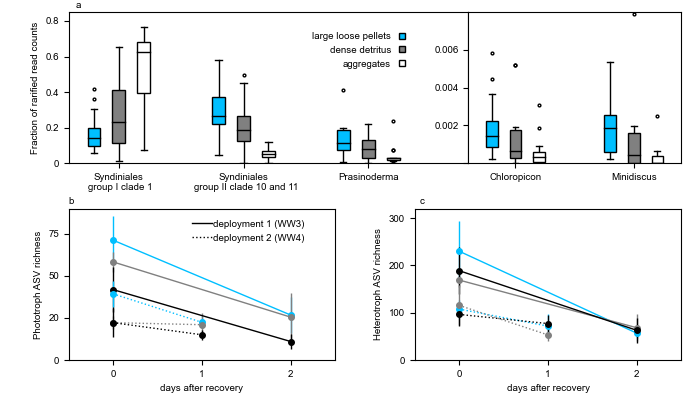

Text(0.61, 0.49, 'c')

In [33]:
Dino_Group_I_reads_St3_agg=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Dino-Group-I-Clade-1_X'][St3_agg_IDs].sum()
Dino_Group_I_reads_St3_dense=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Dino-Group-I-Clade-1_X'][St3_dense_IDs].sum()
Dino_Group_I_reads_St3_large=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Dino-Group-I-Clade-1_X'][St3_large_IDs].sum()

Dino_Group_II_reads_St3_agg=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Dino-Group-II-Clade-10-and-11_X'][St3_agg_IDs].sum()
Dino_Group_II_reads_St3_large=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Dino-Group-II-Clade-10-and-11_X'][St3_large_IDs].sum()
Dino_Group_II_reads_St3_dense=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Dino-Group-II-Clade-10-and-11_X'][St3_dense_IDs].sum()

Prasinoderma_reads_St3_agg=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Prasinoderma'][St3_agg_IDs].sum()
Prasinoderma_reads_St3_large=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Prasinoderma'][St3_large_IDs].sum()
Prasinoderma_reads_St3_dense=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Prasinoderma'][St3_dense_IDs].sum()

Chloropicon_reads_St3_agg=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Chloropicon'][St3_agg_IDs].sum()
Chloropicon_reads_St3_large=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Chloropicon'][St3_large_IDs].sum()
Chloropicon_reads_St3_dense=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Chloropicon'][St3_dense_IDs].sum()

Minidiscus_reads_St3_agg=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Minidiscus'][St3_agg_IDs].sum()
Minidiscus_reads_St3_large=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Minidiscus'][St3_large_IDs].sum()
Minidiscus_reads_St3_dense=rarified_Traps_surface_feature_table_wIDs_wTaxa[rarified_Traps_surface_feature_table_wIDs_wTaxa.taxa6=='Minidiscus'][St3_dense_IDs].sum()

#f, (ax1,ax2)= plt.subplots(1,2,gridspec_kw={'width_ratios':[20,9]},figsize=[6.8,2])

fig=plt.figure(figsize=(6.88,4))
gs = fig.add_gridspec(2, 23,wspace=0,hspace=0.3,top=0.97,bottom=0.1,left=0.1,right=0.99)

ax1 = fig.add_subplot(gs[0:1,0:15])

ax1.boxplot([Dino_Group_I_reads_St3_agg/31993,Dino_Group_II_reads_St3_agg/31993,Prasinoderma_reads_St3_agg/31993],positions=[3,8,13],patch_artist=True,medianprops=dict(color='black'),boxprops=dict(facecolor='white'),flierprops = dict(marker='.', markersize=4))
ax1.boxplot([Dino_Group_I_reads_St3_large/31993,Dino_Group_II_reads_St3_large/31993,Prasinoderma_reads_St3_large/31993],positions=[1,6,11],patch_artist=True,boxprops=dict(facecolor="deepskyblue"),medianprops=dict(color='black'),flierprops = dict(marker='.', markersize=4))
ax1.boxplot([Dino_Group_I_reads_St3_dense/31993,Dino_Group_II_reads_St3_dense/31993,Prasinoderma_reads_St3_dense/31993],positions=[2,7,12],patch_artist=True,boxprops=dict(facecolor="grey"),medianprops=dict(color='black'),flierprops = dict(marker='.', markersize=4))
ax1.set_xlim(0,16)
ax1.set_xticks([2,7,12])
ax1.set_xticklabels(['Syndiniales','Syndiniales','Prasinoderma'],fontsize=7,family='Arial')
ax1.text(0.75,-0.15,'group I clade 1',fontsize=7,family='Arial')
ax1.text(5,-0.15,'group II clade 10 and 11',fontsize=7,family='Arial')
ax1.set_ylim(0,0.85)
ax1.set_ylabel('Fraction of rarified read counts',fontsize=7,family='Arial')
ax1.set_yticks([0,0.2,0.4,0.6,0.8])
ax1.set_yticklabels([0,0.2,0.4,0.6,0.8],fontsize=7,family='Arial')

custom_lines = [Line2D([0], [0], color='deepskyblue',mec='black',marker = 's',lw=0,ms=5),
               Line2D([0], [0], color='grey',mec='black',marker = 's',lw=0,ms=5),
               Line2D([0], [0], color='white',mec='black',marker = 's',lw=0,ms=5)]
ax1.legend(custom_lines,['large loose pellets','dense detritus','aggregates'],markerfirst=False,labelspacing=0.5,handletextpad=0.1,frameon=False,loc=[0.6,0.6],prop={'family':'Arial','size':7})

ax2 = fig.add_subplot(gs[0:1,15:])
ax2.boxplot([Chloropicon_reads_St3_agg/31993,Minidiscus_reads_St3_agg/31993],positions=[3,8],patch_artist=True,medianprops=dict(color='black'),boxprops=dict(facecolor='white'),flierprops = dict(marker='.', markersize=4))
ax2.boxplot([Chloropicon_reads_St3_large/31993,Minidiscus_reads_St3_large/31993],positions=[1,6],patch_artist=True,medianprops=dict(color='black'),boxprops=dict(facecolor='deepskyblue'),flierprops = dict(marker='.', markersize=4))
ax2.boxplot([Chloropicon_reads_St3_dense/31993,Minidiscus_reads_St3_dense/31993],positions=[2,7],patch_artist=True,medianprops=dict(color='black'),boxprops=dict(facecolor='grey'),flierprops = dict(marker='.', markersize=4))
ax2.set_xlim(0,9)
ax2.set_xticks([2,7])
ax2.set_xticklabels(['Chloropicon','Minidiscus'],fontsize=7,family='Arial')
ax2.set_ylim(0,0.008)
ax2.set_yticks([0,0.002,0.004,0.006])
ax2.set_yticklabels(['','0.002','0.004','0.006'
                    ],fontsize=7,family='Arial')


ax2 = fig.add_subplot(gs[1:2,0:10])

ax2.errorbar([0,2],[np.mean(np.sum(WW3_t0_photo_large_reads>0)),np.mean(np.sum(WW3_t2_photo_large_reads>0))],yerr=[np.std(np.sum(WW3_t0_photo_large_reads>0)),np.std(np.sum(WW3_t2_photo_large_reads>0))],lw=1,marker='.',color='deepskyblue',mec='deepskyblue',ms=8,label='long pellets')
ax2.errorbar([0,2],[np.mean(np.sum(WW3_t0_photo_dense_reads>0)),np.mean(np.sum(WW3_t2_photo_dense_reads>0))],yerr=[np.std(np.sum(WW3_t0_photo_dense_reads>0)),np.std(np.sum(WW3_t2_photo_dense_reads>0))],lw=1,marker='.',color='grey',mec='grey',ms=8,label='dense detritus')
ax2.errorbar([0,2],[np.mean(np.sum(WW3_t0_photo_agg_reads>0)),np.mean(np.sum(WW3_t2_photo_agg_reads>0))],yerr=[np.std(np.sum(WW3_t0_photo_agg_reads>0)),np.std(np.sum(WW3_t2_photo_agg_reads>0))],lw=1,marker='.',color='black',mec='black',ms=8,label='aggregates')

ax2.errorbar([0,1],[np.mean(np.sum(WW4_t0_photo_large_reads>0)),np.mean(np.sum(WW4_t1_photo_large_reads>0))],yerr=[np.std(np.sum(WW4_t0_photo_large_reads>0)),np.std(np.sum(WW4_t1_photo_large_reads>0))],lw=1,ls=':',marker='.',color='deepskyblue',mec='deepskyblue',ms=8,label='long pellets')
ax2.errorbar([0,1],[np.mean(np.sum(WW4_t0_photo_dense_reads>0)),np.mean(np.sum(WW4_t1_photo_dense_reads>0))],yerr=[np.std(np.sum(WW4_t0_photo_dense_reads>0)),np.std(np.sum(WW4_t1_photo_dense_reads>0))],lw=1,ls=':',marker='.',color='grey',mec='grey',ms=8,label='dense detritus')
ax2.errorbar([0,1],[np.mean(np.sum(WW4_t0_photo_agg_reads>0)),np.mean(np.sum(WW4_t1_photo_agg_reads>0))],yerr=[np.std(np.sum(WW4_t0_photo_agg_reads>0)),np.std(np.sum(WW4_t1_photo_agg_reads>0))],lw=1,ls=':',marker='.',color='black',mec='black',ms=8,label='aggregates')

ax2.set_ylim(0,90)
ax2.set_yticks([0,25,50,75])
ax2.set_yticklabels([0,20,50,75],family='Arial',size=7)
ax2.set_ylabel('Phototroph ASV richness',family='Arial',size=7)

ax2.set_xticks([0,1,2])
ax2.set_xticklabels([0,1,2],family='Arial',size=7)
ax2.set_xlim(-0.5,2.5)
ax2.set_xlabel('days after recovery',family='Arial',size=7)


custom_lines = [Line2D([0], [0], color='black',lw=1),
               Line2D([0], [0], color='black',lw=1,ls=':')]
ax2.legend(custom_lines,['deployment 1 (WW3)','deployment 2 (WW4)'],markerfirst=True,labelspacing=0.5,handletextpad=0.1,frameon=False,loc=[0.45,0.75],prop={'family':'Arial','size':7})


ax3 = fig.add_subplot(gs[1:2,13:])

ax3.errorbar([0,2],[np.mean(np.sum(WW3_t0_het_large_reads>0)),np.mean(np.sum(WW3_t2_het_large_reads>0))],yerr=[np.std(np.sum(WW3_t0_het_large_reads>0)),np.std(np.sum(WW3_t2_het_large_reads>0))],lw=1,marker='.',color='deepskyblue',mec='deepskyblue',ms=8,label='long pellets')
ax3.errorbar([0,2],[np.mean(np.sum(WW3_t0_het_dense_reads>0)),np.mean(np.sum(WW3_t2_het_dense_reads>0))],yerr=[np.std(np.sum(WW3_t0_het_dense_reads>0)),np.std(np.sum(WW3_t2_het_dense_reads>0))],lw=1,marker='.',color='grey',mec='grey',ms=8,label='dense detritus')
ax3.errorbar([0,2],[np.mean(np.sum(WW3_t0_het_agg_reads>0)),np.mean(np.sum(WW3_t2_het_agg_reads>0))],yerr=[np.std(np.sum(WW3_t0_het_agg_reads>0)),np.std(np.sum(WW3_t2_het_agg_reads>0))],lw=1,marker='.',color='black',mec='black',ms=8,label='aggregates')

ax3.errorbar([0,1],[np.mean(np.sum(WW4_t0_het_large_reads>0)),np.mean(np.sum(WW4_t1_het_large_reads>0))],yerr=[np.std(np.sum(WW4_t0_het_large_reads>0)),np.std(np.sum(WW4_t1_het_large_reads>0))],lw=1,ls=':',marker='.',color='deepskyblue',mec='deepskyblue',ms=8,label='long pellets')
ax3.errorbar([0,1],[np.mean(np.sum(WW4_t0_het_dense_reads>0)),np.mean(np.sum(WW4_t1_het_dense_reads>0))],yerr=[np.std(np.sum(WW4_t0_het_dense_reads>0)),np.std(np.sum(WW4_t1_het_dense_reads>0))],lw=1,ls=':',marker='.',color='grey',mec='grey',ms=8,label='dense detritus')
ax3.errorbar([0,1],[np.mean(np.sum(WW4_t0_het_agg_reads>0)),np.mean(np.sum(WW4_t1_het_agg_reads>0))],yerr=[np.std(np.sum(WW4_t0_het_agg_reads>0)),np.std(np.sum(WW4_t1_het_agg_reads>0))],lw=1,ls=':',marker='.',color='black',mec='black',ms=8,label='aggregates')


ax3.set_ylabel('Heterotroph ASV richness',family='Arial',size=7)
ax3.set_ylim(0,320)
ax3.set_yticks([0,100,200,300])
ax3.set_yticklabels([0,100,200,300],family='Arial',size=7)


ax3.set_xticks([0,1,2])
ax3.set_xticklabels([0,1,2],family='Arial',size=7)
ax3.set_xlim(-0.5,2.5)
ax3.set_xlabel('days after recovery',family='Arial',size=7)




fig.text(0.11,.98,'a',family='Arial',size=7)
fig.text(0.1,.49,'b',family='Arial',size=7)
fig.text(0.61,.49,'c',family='Arial',size=7)




## Plot most diverse taxa groups to see if there is a difference among taxa in their relative decrease in diversity over time

In [34]:
Traps_surface_feature_table_01=Traps_surface_feature_table_filtered.drop('OTU_ID',axis=1).copy()
Traps_surface_feature_table_01[Traps_surface_feature_table_01>0]=1
feature_table_ASV_presence=Traps_surface_feature_table_01.copy()
feature_table_ASV_presence['Feature ID']=Traps_surface_feature_table.OTU_ID
feature_table_ASV_presence_wTaxa=pd.merge(feature_table_ASV_presence,Traps_surface_taxonomy,on='Feature ID',how='left')
feature_table_ASV_counts_group4=feature_table_ASV_presence_wTaxa.groupby(feature_table_ASV_presence_wTaxa.taxa3).sum()
bulktrap_ASV_counts_group4=feature_table_ASV_counts_group4[['T1','T2','T4','T5','T7','T8']]

abundant_bulk_ASVs_group4=[]
for x in bulktrap_ASV_counts_group4.index:
    station2_sum=bulktrap_ASV_counts_group4[['T1','T2']].loc[x].sum()
    if station2_sum/np.sum(bulktrap_ASV_counts_group4[['T1','T2']].sum(axis=1)) > 0.01:
        abundant_bulk_ASVs_group4.append(x)
        station2_sum=bulktrap_ASV_counts_group4[['T1','T2']].loc[x].sum()
    station3_sum=bulktrap_ASV_counts_group4[['T4','T5','T7','T8']].loc[x].sum()
    if station3_sum/np.sum(bulktrap_ASV_counts_group4[['T4','T5','T7','T8']].sum(axis=1)) > 0.01:
        if x not in abundant_bulk_ASVs_group4:
            abundant_bulk_ASVs_group4.append(x)
            
abundant_bulk_ASVs_group4

abundant_bulk_ASVs_group4_v2=[]
for x in bulktrap_ASV_counts_group4.index:
    if bulktrap_ASV_counts_group4.loc[x].sum()>9:
        abundant_bulk_ASVs_group4_v2.append(x)



In [35]:

                             
St3_WW3_0_sample=list(TS_metadata[TS_metadata.Trap=='WW3'][TS_metadata[TS_metadata.Trap=='WW3'].Sample_Time==0].Sample)
St3_WW3_2_sample=list(TS_metadata[TS_metadata.Trap=='WW3'][TS_metadata[TS_metadata.Trap=='WW3'].Sample_Time==2].Sample)
St3_WW4_0_sample=list(TS_metadata[TS_metadata.Trap=='WW4'][TS_metadata[TS_metadata.Trap=='WW4'].Sample_Time==0].Sample)
St3_WW4_1_sample=list(TS_metadata[TS_metadata.Trap=='WW4'][TS_metadata[TS_metadata.Trap=='WW4'].Sample_Time==1].Sample)
St3_WW3_0_sample.remove('T4')
St3_WW3_0_sample.remove('T5')
St3_WW3_0_sample
St3_WW4_0_sample.remove('T7')
St3_WW4_0_sample.remove('T8')

St3_diverse_ASVs_inParticles=feature_table_ASV_counts_group4[feature_table_ASV_counts_group4[St3_WW3_0_sample+St3_WW3_2_sample+St3_WW4_0_sample+St3_WW4_1_sample].max(axis=1)>9].index

St3_diverse_ASVs_inParticles=[ 'Chloropicophyceae','Bacillariophyta',  'Dinophyceae','Syndiniales','Oligohymenophorea', 'Spirotrichea', 'Polycystinea','Cnidaria', 'Arthropoda']
print("These taxa are the most diverse and present in particles")
print(St3_diverse_ASVs_inParticles)

These taxa are the most diverse and present in particles
['Chloropicophyceae', 'Bacillariophyta', 'Dinophyceae', 'Syndiniales', 'Oligohymenophorea', 'Spirotrichea', 'Polycystinea', 'Cnidaria', 'Arthropoda']


<IPython.core.display.Javascript object>


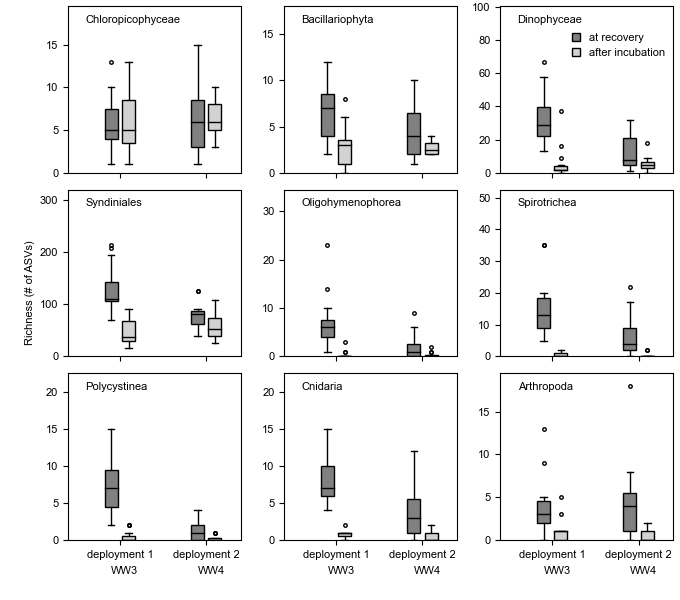

In [36]:
plt.figure(figsize=(6.8,6))
count=1
for x in St3_diverse_ASVs_inParticles:
    plt.subplot(3,3,count)
    plt.boxplot([feature_table_ASV_counts_group4[St3_WW3_0_sample].loc[x]],positions=[1],patch_artist=True,boxprops=dict(facecolor="grey",color='black'),medianprops=dict(color='black'),flierprops=dict(marker='.',ms=5))
    plt.boxplot([feature_table_ASV_counts_group4[St3_WW4_0_sample].loc[x]],positions=[2],patch_artist=True,boxprops=dict(facecolor="grey",color='black'),medianprops=dict(color='black'),flierprops=dict(marker='.',ms=5))
    plt.boxplot([feature_table_ASV_counts_group4[St3_WW3_2_sample].loc[x]],positions=[1.2],patch_artist=True,boxprops=dict(facecolor="lightgrey",color='black'),medianprops=dict(color='black'),flierprops=dict(marker='.',ms=5))
    plt.boxplot([feature_table_ASV_counts_group4[St3_WW4_1_sample].loc[x]],positions=[2.2],patch_artist=True,boxprops=dict(facecolor="lightgrey",color='black'),medianprops=dict(color='black'),flierprops=dict(marker='.',ms=5))
    plt.text(0.7,np.max(feature_table_ASV_counts_group4[St3_WW3_0_sample].loc[x])*1.35,x,family='Arial',size=8)
    plt.xlim(0.5,2.5)
    plt.yticks(family='Arial',size=8)
    plt.ylim(0,np.max(np.max(feature_table_ASV_counts_group4[St3_WW3_0_sample].loc[x]))*1.5)
    if count>6:
        plt.xticks([1.1,2.1],['deployment 1','deployment 2'],family='Arial',size=8)
    else:
        plt.xticks([1.1,2.1],['',''])
    if count == 3:    
        custom_lines = [Line2D([0], [0], color='grey',mec='black',marker='s',lw=0),
                       Line2D([0], [0], color='lightgrey',mec='black',marker='s',lw=0)]
        plt.legend(custom_lines,['at recovery','after incubation'],markerfirst=True,labelspacing=0.5,handletextpad=0.1,frameon=False,loc=[0.35,0.66],prop={'family':'Arial','size':8})

    count=count+1


    
plt.text(-5,23,'Richness (# of ASVs)',family='Arial',size=8,rotation=90)
plt.text(1,-4,'WW3',family='Arial',size=8)
plt.text(2,-4,'WW4',family='Arial',size=8)

plt.text(-4,-4,'WW3',family='Arial',size=8)
plt.text(-3,-4,'WW4',family='Arial',size=8)

plt.text(-1.5,-4,'WW3',family='Arial',size=8)
plt.text(-0.5,-4,'WW4',family='Arial',size=8)


plt.subplots_adjust(hspace=0.1,wspace=0.25,bottom=0.1,top=0.99,left=0.1,right=0.99 )

# Chlorophytes are the only taxa whose diversity doesn't seem to be affected by particle aging

In [37]:
print('WW3 2-day reduction dinflagellates')
WW3_2d_reduction=(feature_table_ASV_counts_group4[St3_WW3_2_sample].loc['Dinophyceae'].mean()/feature_table_ASV_counts_group4[St3_WW3_0_sample].loc['Dinophyceae'].mean())
WW3_2d_reduction_sd=(WW3_2d_reduction)*np.sqrt((feature_table_ASV_counts_group4[St3_WW3_2_sample].loc['Dinophyceae'].std()/feature_table_ASV_counts_group4[St3_WW3_2_sample].loc['Dinophyceae'].mean())**2+(feature_table_ASV_counts_group4[St3_WW3_0_sample].loc['Dinophyceae'].std()/feature_table_ASV_counts_group4[St3_WW3_0_sample].loc['Dinophyceae'].mean())**2)
print(str(1-WW3_2d_reduction)+' plus or minus '+str(WW3_2d_reduction_sd))
print('WW4 1-day reduction dinoflagellates')
WW3_WW4_reduction=(feature_table_ASV_counts_group4[St3_WW4_0_sample].loc['Dinophyceae'].mean()/feature_table_ASV_counts_group4[St3_WW3_0_sample].loc['Dinophyceae'].mean())
WW3_WW4_reduction_sd=(WW3_WW4_reduction)*np.sqrt((feature_table_ASV_counts_group4[St3_WW3_0_sample].loc['Dinophyceae'].std()/feature_table_ASV_counts_group4[St3_WW3_0_sample].loc['Dinophyceae'].mean())**2+(feature_table_ASV_counts_group4[St3_WW4_0_sample].loc['Dinophyceae'].std()/feature_table_ASV_counts_group4[St3_WW4_0_sample].loc['Dinophyceae'].mean())**2)
print(str(1-WW3_WW4_reduction)+' plus or minus '+str(WW3_WW4_reduction_sd))


print('WW3 2-day reduction diatoms')
WW3_2d_reduction=(feature_table_ASV_counts_group4[St3_WW3_2_sample].loc['Bacillariophyta'].mean()/feature_table_ASV_counts_group4[St3_WW3_0_sample].loc['Bacillariophyta'].mean())
WW3_2d_reduction_sd=(WW3_2d_reduction)*np.sqrt((feature_table_ASV_counts_group4[St3_WW3_2_sample].loc['Bacillariophyta'].std()/feature_table_ASV_counts_group4[St3_WW3_2_sample].loc['Bacillariophyta'].mean())**2+(feature_table_ASV_counts_group4[St3_WW3_0_sample].loc['Bacillariophyta'].std()/feature_table_ASV_counts_group4[St3_WW3_0_sample].loc['Bacillariophyta'].mean())**2)
print(str(1-WW3_2d_reduction)+' plus or minus '+str(WW3_2d_reduction_sd))
print('WW4 1-day reduction diatoms')
WW3_WW4_reduction=(feature_table_ASV_counts_group4[St3_WW4_0_sample].loc['Bacillariophyta'].mean()/feature_table_ASV_counts_group4[St3_WW3_0_sample].loc['Bacillariophyta'].mean())
WW3_WW4_reduction_sd=(WW3_WW4_reduction)*np.sqrt((feature_table_ASV_counts_group4[St3_WW3_0_sample].loc['Bacillariophyta'].std()/feature_table_ASV_counts_group4[St3_WW3_0_sample].loc['Bacillariophyta'].mean())**2+(feature_table_ASV_counts_group4[St3_WW4_0_sample].loc['Bacillariophyta'].std()/feature_table_ASV_counts_group4[St3_WW4_0_sample].loc['Bacillariophyta'].mean())**2)
print(str(1-WW3_WW4_reduction)+' plus or minus '+str(WW3_WW4_reduction_sd))


WW3 2-day reduction dinflagellates
0.8223140495867769 plus or minus 0.3079975999467242
WW4 1-day reduction dinoflagellates
0.6177685950413223 plus or minus 0.35486717264967516
WW3 2-day reduction diatoms
0.5555555555555556 plus or minus 0.3978094987674834
WW4 1-day reduction diatoms
0.2727272727272727 plus or minus 0.5643638193667292


## Now assess differences in unpreserved versus RNAlater bulk trap composition by taxa diversity

In [38]:
feature_table_ASV_presence=Traps_surface_feature_table_01.copy()
feature_table_ASV_presence['Feature ID']=Traps_surface_feature_table.OTU_ID
feature_table_ASV_presence_wTaxa=pd.merge(feature_table_ASV_presence,Traps_surface_taxonomy,on='Feature ID',how='left')
feature_table_ASV_counts_group4=feature_table_ASV_presence_wTaxa.groupby(feature_table_ASV_presence_wTaxa.taxa3).sum()
bulktrap_ASV_counts_group4=feature_table_ASV_counts_group4[['T1','T2','T4','T5','T7','T8']]

abundant_bulk_ASVs_group4_v2=[]
for x in bulktrap_ASV_counts_group4.index:
    if bulktrap_ASV_counts_group4.loc[x].sum()>9:
        abundant_bulk_ASVs_group4_v2.append(x)

print(abundant_bulk_ASVs_group4_v2)
abundant_bulk_ASVs_group4_v2=['Chloropicophyceae', 'Mamiellophyceae', 'Bacillariophyta', 'Dinophyceae','MAST-9',  'Syndiniales','Oligohymenophorea','Spirotrichea','Phyllopharyngea', 'Telonemia_X' ,'Acantharea','Polycystinea', 'Cnidaria','Arthropoda']
print(abundant_bulk_ASVs_group4_v2)


['Acantharea', 'Arthropoda', 'Bacillariophyta', 'Chloropicophyceae', 'Cnidaria', 'Dinophyceae', 'MAST-9', 'Mamiellophyceae', 'None', 'Oligohymenophorea', 'Phyllopharyngea', 'Polycystinea', 'Spirotrichea', 'Syndiniales', 'Telonemia_X']
['Chloropicophyceae', 'Mamiellophyceae', 'Bacillariophyta', 'Dinophyceae', 'MAST-9', 'Syndiniales', 'Oligohymenophorea', 'Spirotrichea', 'Phyllopharyngea', 'Telonemia_X', 'Acantharea', 'Polycystinea', 'Cnidaria', 'Arthropoda']


<IPython.core.display.Javascript object>


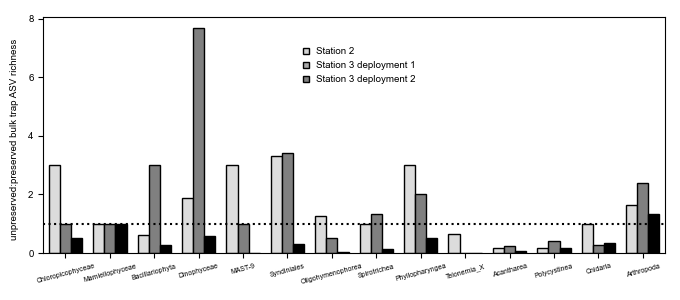

In [39]:
plt.figure(figsize=(6.8,3))
array1=np.arange(0,len(abundant_bulk_ASVs_group4_v2)*4,4)
array2=np.arange(1,(len(abundant_bulk_ASVs_group4_v2))*4,4)
array3=np.arange(2,(len(abundant_bulk_ASVs_group4_v2))*4,4)
count=0
for x in abundant_bulk_ASVs_group4_v2:
    plt.bar(array1[count],bulktrap_ASV_counts_group4['T1'].loc[x]/bulktrap_ASV_counts_group4['T2'].loc[x],color='gainsboro',width=1,edgecolor='black')
    if bulktrap_ASV_counts_group4['T5'].loc[x] == 0:
        plt.bar(array2[count],0,color='grey',width=1,edgecolor='black')
    else:
        plt.bar(array2[count],bulktrap_ASV_counts_group4['T4'].loc[x]/bulktrap_ASV_counts_group4['T5'].loc[x],color='grey',width=1,edgecolor='black')
    if bulktrap_ASV_counts_group4['T8'].loc[x]==0:
        plt.bar(array3[count],0,color='black',width=1,edgecolor='black')
    else:
        plt.bar(array3[count],bulktrap_ASV_counts_group4['T7'].loc[x]/bulktrap_ASV_counts_group4['T8'].loc[x],color='black',width=1,edgecolor='black')
    count=count+1

plt.xticks(array2,abundant_bulk_ASVs_group4_v2,rotation=15,fontsize=5,family='Arial')
plt.xlim(-1,55)
plt.yticks([0,2,4,6,8],fontsize=7,family='Arial')
plt.text(-4,0.5,'unpreserved:preserved bulk trap ASV richness',size=7,family='Arial',rotation=90)

custom_lines = [Line2D([0], [0], color='lightgrey',mec='black',marker = 's',lw=0,ms=5),
                Line2D([0], [0], color='darkgrey',mec='black',marker = 's',lw=0,ms=5),               
                Line2D([0], [0], color='grey',mec='black',marker = 's',lw=0,ms=5)]

plt.legend(custom_lines,['Station 2','Station 3 deployment 1','Station 3 deployment 2'],markerfirst=True,labelspacing=0.5,handletextpad=0.1,frameon=False,loc=[0.4,.7],prop={'family':'Arial','size':7})

plt.plot([-1,55],[1,1],ls=':',color='black')
plt.tight_layout()

## Now want to see which phytoplankton from the surface are enriched in sinking material

In [40]:
def Suface_bulk_particle_ASV_comparison(surface_ASV_counts,bulk_trap_ASV_counts,particle_ASV_counts):
    surface_only_ASVs=[]
    bulk_only_ASVs=[]
    particle_only_ASVs=[]
    all_shared_ASVs=[]
    bulk_particle_shared_ASVs=[]
    bulk_surface_shared_ASVs=[]
    particles_surface_shared_ASVs=[]
    
    for x in surface_ASV_counts.index:
        if surface_ASV_counts.loc[x] > 0:
            if bulk_trap_ASV_counts.loc[x] > 0:
                if particle_ASV_counts.loc[x] > 0:
                    all_shared_ASVs.append(x)
        if surface_ASV_counts.loc[x] > 0:
            if bulk_trap_ASV_counts.loc[x] > 0:
                if particle_ASV_counts.loc[x] == 0:
                    bulk_surface_shared_ASVs.append(x)
        if surface_ASV_counts.loc[x] > 0:
            if particle_ASV_counts.loc[x] > 0:
                if bulk_trap_ASV_counts.loc[x] == 0:
                    particles_surface_shared_ASVs.append(x)
        if bulk_trap_ASV_counts.loc[x] > 0:
            if particle_ASV_counts.loc[x] > 0:
                if surface_ASV_counts.loc[x] == 0:
                    bulk_particle_shared_ASVs.append(x)
        if surface_ASV_counts.loc[x] == 0:
            if bulk_trap_ASV_counts.loc[x] == 0:
                if particle_ASV_counts.loc[x] > 0:
                    particle_only_ASVs.append(x)
        if surface_ASV_counts.loc[x] == 0:
            if bulk_trap_ASV_counts.loc[x] > 0:
                if particle_ASV_counts.loc[x] == 0:
                    bulk_only_ASVs.append(x)
        if surface_ASV_counts.loc[x] > 0:
            if bulk_trap_ASV_counts.loc[x] == 0:
                if particle_ASV_counts.loc[x] == 0:
                    surface_only_ASVs.append(x)
                    
    return dict(surface_only_ASVs=surface_only_ASVs,all_shared_ASVs=all_shared_ASVs,bulk_only_ASVs=bulk_only_ASVs,particle_only_ASVs=particle_only_ASVs,bulk_particle_shared_ASVs=bulk_particle_shared_ASVs,bulk_surface_shared_ASVs=bulk_surface_shared_ASVs,particles_surface_shared_ASVs=particles_surface_shared_ASVs)


In [41]:
Photosynthetic_Traps_surface_feature_table_wIDs_allDATA_original_index=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.copy()
Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.index=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA['OTU_ID']


surface_Samples=TS_metadata[TS_metadata.Sample_type=='Seawater']
Station2_surface_Samples=surface_Samples.Sample[surface_Samples.Station==2]
Station3_surface_Samples=surface_Samples.Sample[surface_Samples.Station==3]
Station1and2_surface_Samples=surface_Samples.Sample[surface_Samples.Station!=3]
trap_Samples=TS_metadata[TS_metadata.Sample_type=='Trap']
Station2_trap_Samples=trap_Samples.Sample[trap_Samples.Station==2]
Station3_trap_Samples=trap_Samples.Sample[trap_Samples.Station==3]
Station1and2_trap_Samples=trap_Samples.Sample[trap_Samples.Station!=3]

Station2_bulk_Samples=Station2_trap_Samples.iloc[[0,1]]
Station2_particle_Samples=Station2_trap_Samples.iloc[2:]
Station1and2_particle_Samples=Station1and2_trap_Samples.iloc[2:]
Station3_bulk_Samples=Station3_trap_Samples.iloc[[0,1,2,3]]
Station3_particle_Samples=Station3_trap_Samples.iloc[4:]

WW3_bulk=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[['T4','T5']].sum(axis=1)
WW4_bulk=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[['T7','T8']].sum(axis=1)
Station_3_metadata=TS_metadata[TS_metadata.Station==3]
Station_3_metadata_particles=Station_3_metadata[Station_3_metadata.ParticleType!='bulk_fresh']
Station_3_metadata_particles=Station_3_metadata_particles[Station_3_metadata_particles.ParticleType!='bulk_RNAlater']
Station_3_metadata_particles=Station_3_metadata_particles[Station_3_metadata_particles.ParticleType!='plankton']
WW3_particle_IDs=Station_3_metadata_particles[Station_3_metadata_particles.Trap=='WW3'].Sample
WW4_particle_IDs=Station_3_metadata_particles[Station_3_metadata_particles.Trap=='WW4'].Sample
WW3_particles=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(WW3_particle_IDs)].sum(axis=1)
WW4_particles=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(WW4_particle_IDs)].sum(axis=1)

Station2_surface_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(Station2_surface_Samples)].sum(axis=1)
Station2_bulk_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(Station2_bulk_Samples)].sum(axis=1)
Station2_particle_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(Station2_particle_Samples)].sum(axis=1)

Station2_surface_bulk_particle_comparison=Suface_bulk_particle_ASV_comparison(Station2_surface_ASV_counts,Station2_bulk_ASV_counts,Station2_particle_ASV_counts)

Station1and2_surface_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(Station1and2_surface_Samples)].sum(axis=1)
Station1and2_particle_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(Station1and2_particle_Samples)].sum(axis=1)

Station1and2_surface_bulk_particle_comparison=Suface_bulk_particle_ASV_comparison(Station1and2_surface_ASV_counts,Station2_bulk_ASV_counts,Station1and2_particle_ASV_counts)

Station3_surface_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(Station3_surface_Samples)].sum(axis=1)
Station3_bulk_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(Station3_bulk_Samples)].sum(axis=1)
Station3_particle_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(Station3_particle_Samples)].sum(axis=1)

Station3_surface_bulk_particle_comparison=Suface_bulk_particle_ASV_comparison(Station3_surface_ASV_counts,Station3_bulk_ASV_counts,Station3_particle_ASV_counts)
WW3_surface_bulk_particle_comparison=Suface_bulk_particle_ASV_comparison(Station3_surface_ASV_counts,WW3_bulk,WW3_particles)
WW4_surface_bulk_particle_comparison=Suface_bulk_particle_ASV_comparison(Station3_surface_ASV_counts,WW4_bulk,WW4_particles)



## Simulate how apparent shared vs. unique ASVs among sample types is affected by the number of particles isolated

In [42]:
def six_way_comparison_St3(n,Station3_particle_Samples=Station3_particle_Samples,Station3_surface_ASV_counts=Station3_surface_ASV_counts,Station3_bulk_ASV_counts=Station3_bulk_ASV_counts):
    St3_surface_only_ASVs_6=[]
    St3_bulk_only_ASVs_6=[]
    St3_all_shared_ASVs_6=[]
    St3_particle_only_ASVs_6=[]
    St3_bulk_particle_shared_ASVs_6=[]
    St3_bulk_surface_shared_ASVs_6=[]
    St3_particles_surface_shared_ASVs_6=[]
    St3_bulk_not_particles_ASVs_6=[]
    St3_any_trap_sample_ASVs_6=[]
    St3_surface_shared_with_bulk_and_or_particles_6=[]
    for y in np.arange(0,100):
        random_samples_6=[]
        count=0
        for x in np.arange(0,5000):
            number=np.random.randint(list(np.arange(0,1)),len(Station3_particle_Samples))
            if number not in random_samples_6:
                random_samples_6.append(number[0])
                count=count+1
            if count==int(n):
                break
        Station3_particle_Samples_6=Station3_particle_Samples.iloc[random_samples_6]
        Station3_particle_ASV_counts_subset=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(Station3_particle_Samples_6)].sum(axis=1)
        Station3_surface_bulk_particle_comparison_subset=Suface_bulk_particle_ASV_comparison(Station3_surface_ASV_counts,Station3_bulk_ASV_counts,Station3_particle_ASV_counts_subset)
        St3_surface_only_ASVs_6.append(len(Station3_surface_bulk_particle_comparison_subset['surface_only_ASVs']))
        St3_bulk_only_ASVs_6.append(len(Station3_surface_bulk_particle_comparison_subset['bulk_only_ASVs']))
        St3_all_shared_ASVs_6.append(len(Station3_surface_bulk_particle_comparison_subset['all_shared_ASVs']))
        St3_particle_only_ASVs_6.append(len(Station3_surface_bulk_particle_comparison_subset['particle_only_ASVs']))
        St3_bulk_particle_shared_ASVs_6.append(len(Station3_surface_bulk_particle_comparison_subset['bulk_particle_shared_ASVs']))
        St3_bulk_surface_shared_ASVs_6.append(len(Station3_surface_bulk_particle_comparison_subset['bulk_surface_shared_ASVs']))
        St3_particles_surface_shared_ASVs_6.append(len(Station3_surface_bulk_particle_comparison_subset['particles_surface_shared_ASVs']))
        St3_bulk_not_particles_ASVs_6.append(len(Station3_surface_bulk_particle_comparison_subset['bulk_only_ASVs'])+len(Station3_surface_bulk_particle_comparison_subset['bulk_surface_shared_ASVs']))
        St3_any_trap_sample_ASVs_6.append(len(Station3_surface_bulk_particle_comparison_subset['bulk_only_ASVs'])+len(Station3_surface_bulk_particle_comparison_subset['bulk_surface_shared_ASVs'])+len(Station3_surface_bulk_particle_comparison_subset['bulk_particle_shared_ASVs'])+len(Station3_surface_bulk_particle_comparison_subset['all_shared_ASVs']))
        St3_surface_shared_with_bulk_and_or_particles_6.append(len(Station3_surface_bulk_particle_comparison_subset['particles_surface_shared_ASVs'])+len(Station3_surface_bulk_particle_comparison_subset['bulk_surface_shared_ASVs'])+len(Station3_surface_bulk_particle_comparison_subset['all_shared_ASVs']))
    
    df=pd.DataFrame()
    df['Mean']=np.array([np.mean(St3_surface_only_ASVs_6),np.mean(St3_bulk_only_ASVs_6),np.mean(St3_all_shared_ASVs_6),np.mean(St3_particle_only_ASVs_6),np.mean(St3_bulk_particle_shared_ASVs_6),np.mean(St3_bulk_surface_shared_ASVs_6),np.mean(St3_particles_surface_shared_ASVs_6),np.mean(St3_bulk_not_particles_ASVs_6),np.mean(St3_any_trap_sample_ASVs_6),np.mean(St3_surface_shared_with_bulk_and_or_particles_6)])
    df['STD']=np.array([np.std(St3_surface_only_ASVs_6),np.std(St3_bulk_only_ASVs_6),np.std(St3_all_shared_ASVs_6),np.std(St3_particle_only_ASVs_6),np.std(St3_bulk_particle_shared_ASVs_6),np.std(St3_bulk_surface_shared_ASVs_6),np.std(St3_particles_surface_shared_ASVs_6),np.std(St3_bulk_not_particles_ASVs_6),np.std(St3_any_trap_sample_ASVs_6),np.std(St3_surface_shared_with_bulk_and_or_particles_6)])
    df.index=np.array(['St3_surface_only_ASVs','St3_bulk_only_ASVs','St3_all_shared_ASVs','St3_particle_only_ASVs','St3_bulk_particle_shared_ASVs','St3_bulk_surface_shared_ASVs','St3_particles_surface_shared_ASVs','St3_bulk_not_particles_ASVs_6','St3_any_trap_sample_ASVs_6','St3_surface_shared_with_bulk_and_or_particles'])
    return df


In [43]:
St3_6way_comparison_6=six_way_comparison_St3(6)
St3_6way_comparison_10=six_way_comparison_St3(10)
St3_6way_comparison_20=six_way_comparison_St3(20)
St3_6way_comparison_30=six_way_comparison_St3(30)
St3_6way_comparison_40=six_way_comparison_St3(40)
St3_6way_comparison_50=six_way_comparison_St3(50)

<IPython.core.display.Javascript object>


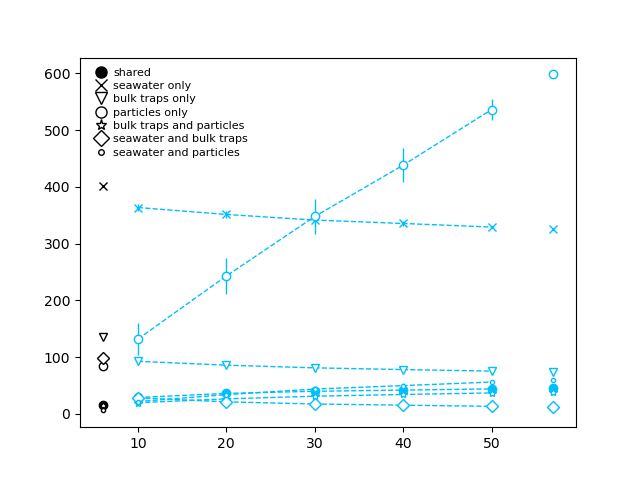

In [44]:
plt.figure()
plt.plot([6],[len(Station2_surface_bulk_particle_comparison['surface_only_ASVs'])],marker='x',lw=1,ls='dashed',color='black',mfc='white')
plt.plot([6],[len(Station2_surface_bulk_particle_comparison['bulk_only_ASVs'])],marker='v',lw=1,ls='dashed',color='black',mfc='white')
plt.plot([6],[len(Station2_surface_bulk_particle_comparison['all_shared_ASVs'])],marker='o',lw=1,ls='dashed',color='black')
plt.plot([6],[len(Station2_surface_bulk_particle_comparison['particle_only_ASVs'])],marker='o',lw=1,ls='dashed',color='black',mfc='white')
plt.plot([6],[len(Station2_surface_bulk_particle_comparison['bulk_particle_shared_ASVs'])],marker='*',lw=1,ls='dashed',color='black',mfc='white')
plt.plot([6],[len(Station2_surface_bulk_particle_comparison['bulk_surface_shared_ASVs'])],marker='D',lw=1,ls='dashed',color='black',mfc='white')
plt.plot([6],[len(Station2_surface_bulk_particle_comparison['particles_surface_shared_ASVs'])],marker='.',lw=1,ls='dashed',color='black',mfc='white')

plt.plot([57],[len(Station3_surface_bulk_particle_comparison['surface_only_ASVs'])],marker='x',lw=1,ls='dashed',color='deepskyblue',mfc='white')
plt.plot([57],[len(Station3_surface_bulk_particle_comparison['bulk_only_ASVs'])],marker='v',lw=1,ls='dashed',color='deepskyblue',mfc='white')
plt.plot([57],[len(Station3_surface_bulk_particle_comparison['all_shared_ASVs'])],marker='o',lw=1,ls='dashed',color='deepskyblue')
plt.plot([57],[len(Station3_surface_bulk_particle_comparison['particle_only_ASVs'])],marker='o',lw=1,ls='dashed',color='deepskyblue',mfc='white')
plt.plot([57],[len(Station3_surface_bulk_particle_comparison['bulk_particle_shared_ASVs'])],marker='*',lw=1,ls='dashed',color='deepskyblue',mfc='white')
plt.plot([57],[len(Station3_surface_bulk_particle_comparison['bulk_surface_shared_ASVs'])],marker='D',lw=1,ls='dashed',color='deepskyblue',mfc='white')
plt.plot([57],[len(Station3_surface_bulk_particle_comparison['particles_surface_shared_ASVs'])],marker='.',lw=1,ls='dashed',color='deepskyblue',mfc='white')

plt.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_surface_only_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_surface_only_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_surface_only_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_surface_only_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_surface_only_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_surface_only_ASVs'],St3_6way_comparison_20['STD'].loc['St3_surface_only_ASVs'],St3_6way_comparison_30['STD'].loc['St3_surface_only_ASVs'],St3_6way_comparison_40['STD'].loc['St3_surface_only_ASVs'],St3_6way_comparison_50['STD'].loc['St3_surface_only_ASVs']],marker='x',lw=1,ls='dashed',color='deepskyblue',mfc='white')
plt.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_bulk_only_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_20['STD'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_30['STD'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_40['STD'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_50['STD'].loc['St3_bulk_only_ASVs']],marker='v',lw=1,ls='dashed',color='deepskyblue',mfc='white')
plt.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_all_shared_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_all_shared_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_all_shared_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_all_shared_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_all_shared_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_all_shared_ASVs'],St3_6way_comparison_20['STD'].loc['St3_all_shared_ASVs'],St3_6way_comparison_30['STD'].loc['St3_all_shared_ASVs'],St3_6way_comparison_40['STD'].loc['St3_all_shared_ASVs'],St3_6way_comparison_50['STD'].loc['St3_all_shared_ASVs']],marker='o',lw=1,ls='dashed',color='deepskyblue')
plt.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_particle_only_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_particle_only_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_particle_only_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_particle_only_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_particle_only_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_particle_only_ASVs'],St3_6way_comparison_20['STD'].loc['St3_particle_only_ASVs'],St3_6way_comparison_30['STD'].loc['St3_particle_only_ASVs'],St3_6way_comparison_40['STD'].loc['St3_particle_only_ASVs'],St3_6way_comparison_50['STD'].loc['St3_particle_only_ASVs']],marker='o',lw=1,ls='dashed',color='deepskyblue',mfc='white')
plt.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_bulk_particle_shared_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_20['STD'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_30['STD'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_40['STD'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_50['STD'].loc['St3_bulk_particle_shared_ASVs']],marker='*',lw=1,ls='dashed',color='deepskyblue',mfc='white')
plt.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_bulk_surface_shared_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_20['STD'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_30['STD'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_40['STD'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_50['STD'].loc['St3_bulk_surface_shared_ASVs']],marker='D',lw=1,ls='dashed',color='deepskyblue',mfc='white')
plt.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_particles_surface_shared_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_20['STD'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_30['STD'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_40['STD'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_50['STD'].loc['St3_particles_surface_shared_ASVs']],marker='.',lw=1,ls='dashed',color='deepskyblue',mfc='white')

custom_lines =[Line2D([0], [0], color='black',marker = 'o',lw=0,ms=8),
               Line2D([0], [0], color='black',marker = 'x',lw=0,ms=8,mfc='white'),
               Line2D([0], [0], color='black',marker = 'v',lw=0,ms=8,mfc='white'),
               Line2D([0], [0], color='black',marker = 'o',lw=0,ms=8,mfc='white'),
               Line2D([0], [0], color='black',marker = '*',lw=0,ms=8,mfc='white'),
               Line2D([0], [0], color='black',marker = 'D',lw=0,ms=8,mfc='white'),
               Line2D([0], [0], color='black',marker = '.',lw=0,ms=8,mfc='white')]

plt.legend(custom_lines,['shared','seawater only','bulk traps only','particles only','bulk traps and particles','seawater and bulk traps','seawater and particles','St 2 samples','St 3 samples','random subsamples of St 3 particles'],labelspacing=0.3,handletextpad=0.1,frameon=False,fontsize=8)


In [45]:
##Function to create a dataframe with the ASVs present only in the surface or shared with the trap samples.
##This will allow testing results to changing how many particle samples are included in the analysis
##IMPORTANT: Need only do this analysis with ASVs detected in the surface.  Do not include ASVs only detected in particles
##Differences in the number of particles sampled shouldn't affect this analysis too much because additional particles mostly add
##unique ASVs, they do not really add to the number of shared ASVs with the surface community

def Suface_trap_ASV_comparison(surface_ASV_counts,trap_ASV_counts,taxonomy):
    surface_only_ASVs=[]
    shared_ASVs=[]
    for x in surface_ASV_counts.index:
        if surface_ASV_counts.loc[x] > 0:
            if trap_ASV_counts.loc[x] > 0:
                shared_ASVs.append(x)
        if surface_ASV_counts.loc[x] > 0:
            if trap_ASV_counts.loc[x] == 0:
                surface_only_ASVs.append(x)
        
    surface_only_taxa=pd.DataFrame()
    surface_only_taxa['OTU_ID']=np.array(surface_only_ASVs)
    surface_only_taxa=pd.merge(surface_only_taxa,taxonomy,on='OTU_ID',how='left')
    surface_only_taxa3_groupsums=surface_only_taxa.OTU_ID.groupby(surface_only_taxa.taxa3).count()
    shared_taxa=pd.DataFrame()
    shared_taxa['OTU_ID']=np.array(shared_ASVs)
    shared_taxa=pd.merge(shared_taxa,taxonomy,on='OTU_ID',how='left')
    shared_taxa3_groupsums=shared_taxa.OTU_ID.groupby(shared_taxa.taxa3).count()

    Preferential_surface_export=pd.DataFrame()
    Preferential_surface_export['surface_only']=surface_only_taxa3_groupsums
    Preferential_surface_export=pd.merge(Preferential_surface_export,pd.DataFrame(shared_taxa3_groupsums),on='taxa3',how='outer')
    Preferential_surface_export=Preferential_surface_export.rename(columns={'OTU_ID':'shared'})
    Preferential_surface_export=Preferential_surface_export.fillna(0)
    
    return Preferential_surface_export

In [46]:
surface_Samples=TS_metadata[TS_metadata.Sample_type=='Seawater']
oligotrophic_surface_Samples=surface_Samples.Sample[surface_Samples.Station!=3]
St2_surface_Samples=surface_Samples.Sample[surface_Samples.Station==2]
St3_surface_Samples=surface_Samples.Sample[surface_Samples.Station==3]
trap_Samples=TS_metadata[TS_metadata.Sample_type=='Trap']
oligotrophic_trap_Samples=trap_Samples.Sample[trap_Samples.Station!=3]
St2_trap_Samples=trap_Samples.Sample[trap_Samples.Station==2]
St3_trap_Samples=trap_Samples.Sample[trap_Samples.Station==3]

WW3_bulk=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[['T4','T5']].sum(axis=1)
WW4_bulk=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[['T7','T8']].sum(axis=1)
Station_3_metadata=TS_metadata[TS_metadata.Station==3]
Station_3_metadata_particles=Station_3_metadata[Station_3_metadata.ParticleType!='bulk_fresh']
Station_3_metadata_particles=Station_3_metadata_particles[Station_3_metadata_particles.ParticleType!='bulk_RNAlater']
Station_3_metadata_particles=Station_3_metadata_particles[Station_3_metadata_particles.ParticleType!='plankton']
WW3_particle_IDs=Station_3_metadata_particles[Station_3_metadata_particles.Trap=='WW3'].Sample
WW4_particle_IDs=Station_3_metadata_particles[Station_3_metadata_particles.Trap=='WW4'].Sample
WW3_particles=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(WW3_particle_IDs)].sum(axis=1)
WW4_particles=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(WW4_particle_IDs)].sum(axis=1)


Traps_surface_taxonomy=Traps_surface_taxonomy.reset_index(drop=True)

##This dataset tests for presence in surface and trap samples using all trap samples##
St3_trap_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(St3_trap_Samples)].sum(axis=1)
St3_surface_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(St3_surface_Samples)].sum(axis=1)
oligotrophic_trap_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(oligotrophic_trap_Samples)].sum(axis=1)
oligotrophic_surface_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(oligotrophic_surface_Samples)].sum(axis=1)
St2_trap_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(St2_trap_Samples)].sum(axis=1)
St2_surface_ASV_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(St2_surface_Samples)].sum(axis=1)

St3_Preferential_surface_export=Suface_trap_ASV_comparison(St3_surface_ASV_counts,St3_trap_ASV_counts,Traps_surface_taxonomy)
WW3_Preferential_surface_export=Suface_trap_ASV_comparison(St3_surface_ASV_counts,WW3_particles,Traps_surface_taxonomy)
WW4_Preferential_surface_export=Suface_trap_ASV_comparison(St3_surface_ASV_counts,WW4_particles,Traps_surface_taxonomy)

St2_Preferential_surface_export=Suface_trap_ASV_comparison(St2_surface_ASV_counts,St2_trap_ASV_counts,Traps_surface_taxonomy)

St2and3_Preferential_surface_export=St2_Preferential_surface_export.merge(St3_Preferential_surface_export,left_index=True,right_index=True,how='outer')
St2and3_Preferential_surface_export=St2and3_Preferential_surface_export.reindex(['Bacillariophyta', 'Bolidophyceae','Dictyochophyceae','Chrysophyceae', 'Raphidophyceae','Phaeophyceae', 'Pelagophyceae','MOCH-2','MOCH-3', 'MOCH-4', 'MOCH-5', 'Chlorophyta_X','Chloropicophyceae','Palmophyllophyceae','Mamiellophyceae','Prasino-Clade-9','Pyramimonadales','Dinophyceae', 'Dinophyta_X', 'Noctilucophyceae','Haptophyta_Clade_HAP2', 'Haptophyta_Clade_HAP3','Haptophyta_Clade_HAP4', 'Haptophyta_X','Prymnesiophyceae','Cryptophyceae','Chlorarachniophyceae'])


In [47]:
Heterotrophic_Traps_surface_feature_table_wIDs_allDATA_original_index=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.copy()
Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.index=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA['OTU_ID']

St3_trap_ASV_counts_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA[list(St3_trap_Samples)].sum(axis=1)
St3_surface_ASV_counts_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA[list(St3_surface_Samples)].sum(axis=1)
St2_trap_ASV_counts_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA[list(St2_trap_Samples)].sum(axis=1)
St2_surface_ASV_counts_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA[list(St2_surface_Samples)].sum(axis=1)

St3_Preferential_surface_export_het=Suface_trap_ASV_comparison(St3_surface_ASV_counts_het,St3_trap_ASV_counts_het,Traps_surface_taxonomy)
St2_Preferential_surface_export_het=Suface_trap_ASV_comparison(St2_surface_ASV_counts_het,St2_trap_ASV_counts_het,Traps_surface_taxonomy)

St2and3_Preferential_surface_export_het=St2_Preferential_surface_export_het.merge(St3_Preferential_surface_export_het,left_index=True,right_index=True,how='outer')
St2and3_Preferential_surface_export_het=St2and3_Preferential_surface_export_het.reindex(['Bicoecea','Developea','Labyrinthulomycetes','Oomycota',  'Pirsonia_Clade','MAST-1','MAST-10', 'MAST-11', 'MAST-12', 'MAST-2', 'MAST-25', 'MAST-3','MAST-4', 'MAST-7', 'MAST-8', 'MAST-9',
 'Syndiniales', 'CONThreeP', 'Coccidiomorphea','Gregarinomorphea','Heterotrichea', 'Litostomatea',  'Nassophorea', 'Oligohymenophorea','Phyllopharyngea','Spirotrichea', 
'Cercozoa_X','Filosa-Imbricatea', 'Filosa-Thecofilosea', 'Phaeodarea','Acantharea', 'Polycystinea', 'RAD-A', 'RAD-B', 'RAD-C', 'Radiolaria_X',
'Centroheliozoa_X','Katablepharidaceae',  'Picozoa_X',    'Telonemia_X',
  'Tubulinea','Variosea',
 'Chytridiomycota','Ascomycota','Fungi_X',
 'Choanoflagellatea', 'Choanoflagellida_X','Basidiomycota', 'Ichthyosporea','Opisthokonta_XX',
 'Arthropoda', 'Cnidaria', 'Ctenophora','Chaetognatha','Craniata',  'Mollusca', 'Urochordata'] )

In [48]:
St2_het=St2and3_Preferential_surface_export_het[['surface_only_x','shared_x']].dropna()
print(St2_het['shared_x'].sum()/(St2_het['shared_x'].sum()+St2_het['surface_only_x'].sum()))

St3_het=St2and3_Preferential_surface_export_het[['surface_only_y','shared_y']].dropna()
print(St3_het['shared_y'].sum()/(St3_het['shared_y'].sum()+St3_het['surface_only_y'].sum()))


0.2023082145281738
0.29282407407407407


In [49]:
Fraction_surface_exported_subsample6=St3_6way_comparison_6.loc['St3_surface_shared_with_bulk_and_or_particles'].Mean/len(Station3_surface_ASV_counts[Station3_surface_ASV_counts>0])
Fraction_surface_exported_subsample10=St3_6way_comparison_10.loc['St3_surface_shared_with_bulk_and_or_particles'].Mean/len(Station3_surface_ASV_counts[Station3_surface_ASV_counts>0])
Fraction_surface_exported_subsample20=St3_6way_comparison_20.loc['St3_surface_shared_with_bulk_and_or_particles'].Mean/len(Station3_surface_ASV_counts[Station3_surface_ASV_counts>0])
Fraction_surface_exported_subsample30=St3_6way_comparison_30.loc['St3_surface_shared_with_bulk_and_or_particles'].Mean/len(Station3_surface_ASV_counts[Station3_surface_ASV_counts>0])
Fraction_surface_exported_subsample40=St3_6way_comparison_40.loc['St3_surface_shared_with_bulk_and_or_particles'].Mean/len(Station3_surface_ASV_counts[Station3_surface_ASV_counts>0])
Fraction_surface_exported_subsample50=St3_6way_comparison_50.loc['St3_surface_shared_with_bulk_and_or_particles'].Mean/len(Station3_surface_ASV_counts[Station3_surface_ASV_counts>0])

Fraction_surface_exported_subsample6_sd=St3_6way_comparison_6.loc['St3_surface_shared_with_bulk_and_or_particles'].STD/len(Station3_surface_ASV_counts[Station3_surface_ASV_counts>0])
Fraction_surface_exported_subsample10_sd=St3_6way_comparison_10.loc['St3_surface_shared_with_bulk_and_or_particles'].STD/len(Station3_surface_ASV_counts[Station3_surface_ASV_counts>0])
Fraction_surface_exported_subsample20_sd=St3_6way_comparison_20.loc['St3_surface_shared_with_bulk_and_or_particles'].STD/len(Station3_surface_ASV_counts[Station3_surface_ASV_counts>0])
Fraction_surface_exported_subsample30_sd=St3_6way_comparison_30.loc['St3_surface_shared_with_bulk_and_or_particles'].STD/len(Station3_surface_ASV_counts[Station3_surface_ASV_counts>0])
Fraction_surface_exported_subsample40_sd=St3_6way_comparison_40.loc['St3_surface_shared_with_bulk_and_or_particles'].STD/len(Station3_surface_ASV_counts[Station3_surface_ASV_counts>0])
Fraction_surface_exported_subsample50_sd=St3_6way_comparison_50.loc['St3_surface_shared_with_bulk_and_or_particles'].STD/len(Station3_surface_ASV_counts[Station3_surface_ASV_counts>0])

Fraction_surface_exported_St2=(St2and3_Preferential_surface_export['shared_x'].sum()/(St2and3_Preferential_surface_export['surface_only_x'].sum()+St2and3_Preferential_surface_export['shared_x'].sum()))
Fraction_surface_exported_St3=(St2and3_Preferential_surface_export['shared_y'].sum()/(St2and3_Preferential_surface_export['surface_only_y'].sum()+St2and3_Preferential_surface_export['shared_y'].sum()))

##If only a subsample of station 3 particles are included, it does not drastically affect the surface ASVs detected in the traps
##This is consistant with the fact that sequencing individual particles seems to sample rare NEW ASVs, not already detected ASVs

In [50]:
surface_fraction_exported=pd.DataFrame()
surface_fraction_exported['number_particles_sampled']=np.array([6,10,20,30,40,50])
surface_fraction_exported['fraction_exported']=np.array([Fraction_surface_exported_subsample6,Fraction_surface_exported_subsample10,Fraction_surface_exported_subsample20,Fraction_surface_exported_subsample30,Fraction_surface_exported_subsample40,Fraction_surface_exported_subsample50])
surface_fraction_exported['fraction_exported_sd']=np.array([Fraction_surface_exported_subsample6_sd,Fraction_surface_exported_subsample10_sd,Fraction_surface_exported_subsample20_sd,Fraction_surface_exported_subsample30_sd,Fraction_surface_exported_subsample40_sd,Fraction_surface_exported_subsample50_sd])


In [51]:
def surface_export_parabolic_increase(par,data):
    N, k, z = par
    predicted_fraction=(N*(1-np.exp(-k*data['number_particles_sampled'])))+z
    diff=np.sum((np.log(data['fraction_exported'])-np.log(predicted_fraction))**2)
    return diff

surface_export_fraction_parameters = optimize.minimize(surface_export_parabolic_increase,[0.1,0.1,0.15],args=(surface_fraction_exported))
surface_export_fraction_parameters

/Users/cdurkin/opt/anaconda3/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


      fun: 0.00021029058228128972
 hess_inv: array([[ 0.3077687 , -0.17362   ,  0.07620437],
       [-0.17362   ,  0.12525742, -0.07681171],
       [ 0.07620437, -0.07681171,  0.06445915]])
      jac: array([-2.27575583e-07, -6.68103894e-07, -2.74074409e-07])
  message: 'Optimization terminated successfully.'
     nfev: 96
      nit: 18
     njev: 24
   status: 0
  success: True
        x: array([0.1484791 , 0.03294314, 0.13431457])

In [52]:
##NOTE: this is the same anlaysis I did above, but it doesn't include the surface seawater data
##I am just redoing it so I don't have to think about which subsets to use...

St2_bulk=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[['T1','T2']].sum(axis=1)
Station_2_metadata=TS_metadata[TS_metadata.Station==2]
Station_2_metadata_particles=Station_2_metadata[Station_2_metadata.ParticleType!='bulk_fresh']
Station_2_metadata_particles=Station_2_metadata_particles[Station_2_metadata_particles.ParticleType!='bulk_RNAlater']
Station_2_metadata_particles=Station_2_metadata_particles[Station_2_metadata_particles.ParticleType!='plankton']
St2_particles=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(Station_2_metadata_particles.Sample)].sum(axis=1)

##All ASV IDs are present in the index of each dataset, but the number of counts differs##
St2_small_particle_ASVs = []
St2_large_particle_ASVs = []
St2_large_only_particles_ASVs = []
for ASV in St2_particles.index:
    if St2_bulk.loc[ASV] > 0:
        if St2_particles.loc[ASV] == 0:
            St2_small_particle_ASVs.append(ASV)
        else:
            St2_large_particle_ASVs.append(ASV)
    elif St2_particles.loc[ASV] > 0:
        St2_large_only_particles_ASVs.append(ASV)
        
St3_bulk=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[['T4','T5','T7','T8']].sum(axis=1)
Station_3_metadata=TS_metadata[TS_metadata.Station==3]
Station_3_metadata_particles=Station_3_metadata[Station_3_metadata.ParticleType!='bulk_fresh']
Station_3_metadata_particles=Station_3_metadata_particles[Station_3_metadata_particles.ParticleType!='bulk_RNAlater']
Station_3_metadata_particles=Station_3_metadata_particles[Station_3_metadata_particles.ParticleType!='plankton']
St3_particles=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(Station_3_metadata_particles.Sample)].sum(axis=1)

St3_small_particle_ASVs = []
St3_large_particle_ASVs = []
St3_large_only_particles_ASVs=[]
for ASV in St3_particles.index:
    if St3_bulk.loc[ASV] > 0:
        if St3_particles.loc[ASV] == 0:
            St3_small_particle_ASVs.append(ASV)
        else:
            St3_large_particle_ASVs.append(ASV)
    elif St3_particles.loc[ASV] > 0:
        St3_large_only_particles_ASVs.append(ASV)
        
        
St2_small_particles_taxa3_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[St2_small_particle_ASVs].groupby(Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[St2_small_particle_ASVs].taxa3).count().taxa3
St2_large_particles_taxa3_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[St2_large_particle_ASVs].groupby(Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[St2_large_particle_ASVs].taxa3).count().taxa3
St3_small_particles_taxa3_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[St3_small_particle_ASVs].groupby(Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[St3_small_particle_ASVs].taxa3).count().taxa3
St3_large_particles_taxa3_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[St3_large_particle_ASVs].groupby(Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[St3_large_particle_ASVs].taxa3).count().taxa3



St2_small_large_particle_taxa3_counts=pd.DataFrame(St2_small_particles_taxa3_counts).merge(pd.DataFrame(St2_large_particles_taxa3_counts),left_index=True,right_index=True,how='outer')
St2_small_large_particle_taxa3_counts=St2_small_large_particle_taxa3_counts.rename(columns={'taxa3_x':'St2_small','taxa3_y':'St2_large'})
St2and3_small_large_particle_taxa3_counts=St2_small_large_particle_taxa3_counts.merge(pd.DataFrame(St3_small_particles_taxa3_counts),left_index=True, right_index=True,how='outer')
St2and3_small_large_particle_taxa3_counts=St2and3_small_large_particle_taxa3_counts.merge(pd.DataFrame(St3_large_particles_taxa3_counts),left_index=True, right_index=True,how='outer')
St2and3_small_large_particle_taxa3_counts=St2and3_small_large_particle_taxa3_counts.rename(columns={'taxa3_x':'St3_small','taxa3_y':'St3_large'})
St2and3_small_large_particle_taxa3_counts=St2and3_small_large_particle_taxa3_counts.fillna(0)
St2and3_small_large_particle_taxa3_counts

St2_small  St2_large  St3_small  St3_large
taxa3                                                         
Bacillariophyta          10.0        2.0       13.0       12.0
Bolidophyceae             2.0        0.0        0.0        0.0
Chloropicophyceae         1.0        8.0        2.0        4.0
Chrysophyceae             5.0        0.0        1.0        0.0
Cryptophyceae             2.0        0.0        3.0        1.0
Dictyochophyceae          7.0        0.0        1.0        0.0
Dinophyceae             191.0       17.0       59.0       58.0
Dinophyta_X               1.0        0.0        2.0        0.0
MOCH-2                    3.0        0.0        0.0        0.0
MOCH-5                    1.0        2.0        0.0        1.0
Mamiellophyceae           1.0        0.0        2.0        2.0
Noctilucophyceae          3.0        0.0        0.0        0.0
Palmophyllophyceae        0.0        0.0        0.0        1.0
Pelagophyceae             1.0        0.0        0.0        2.0
Prasino-Clade-9           1.0        1.0        0.0        1.0
Prasino-Clade-V           0.0        0.0        1.0        1.0
Prymnesiophyceae          2.0        1.0        2.0        0.0
Pyramimonadales           2.0        0.0        0.0        0.0

In [53]:
###Heterotrophic taxa found only in small particles and not in large particles

St3_bulk_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA[['T4','T5','T7','T8']].sum(axis=1)
Station_3_metadata=TS_metadata[TS_metadata.Station==3]
Station_3_metadata_particles=Station_3_metadata[Station_3_metadata.ParticleType!='bulk_fresh']
Station_3_metadata_particles=Station_3_metadata_particles[Station_3_metadata_particles.ParticleType!='bulk_RNAlater']
Station_3_metadata_particles=Station_3_metadata_particles[Station_3_metadata_particles.ParticleType!='plankton']
St3_particles_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA[list(Station_3_metadata_particles.Sample)].sum(axis=1)

St3_small_particle_ASVs_het = []
St3_large_particle_ASVs_het = []
St3_large_only_particles_ASVs_het=[]
for ASV in St3_particles_het.index:
    if St3_bulk_het.loc[ASV] > 0:
        if St3_particles_het.loc[ASV] == 0:
            St3_small_particle_ASVs_het.append(ASV)
        else:
            St3_large_particle_ASVs_het.append(ASV)
    elif St3_particles_het.loc[ASV] > 0:
        St3_large_only_particles_ASVs_het.append(ASV)
        
St3_small_particles_taxa3_counts_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.loc[St3_small_particle_ASVs_het].groupby(Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.loc[St3_small_particle_ASVs_het].taxa3).count().taxa3
St3_large_particles_taxa3_counts_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.loc[St3_large_particle_ASVs_het].groupby(Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.loc[St3_large_particle_ASVs_het].taxa3).count().taxa3

St3_small_large_particle_taxa3_counts_het=pd.DataFrame(St3_small_particles_taxa3_counts_het).merge(pd.DataFrame(St3_large_particles_taxa3_counts_het),left_index=True,right_index=True,how='outer')

St3_small_large_particle_taxa3_counts_het=St3_small_large_particle_taxa3_counts_het.rename(columns={'taxa3_x':'St3_small','taxa3_y':'St3_large'})



In [54]:
#How does particle sample size affect the fraction of the bulk trap ASVs only detected in the bulk (small particle export)?
small_particles_6=St3_6way_comparison_6.loc['St3_bulk_not_particles_ASVs_6'].Mean/St3_6way_comparison_6.loc['St3_any_trap_sample_ASVs_6'].Mean
small_particles_10=St3_6way_comparison_10.loc['St3_bulk_not_particles_ASVs_6'].Mean/St3_6way_comparison_10.loc['St3_any_trap_sample_ASVs_6'].Mean
small_particles_20=St3_6way_comparison_20.loc['St3_bulk_not_particles_ASVs_6'].Mean/St3_6way_comparison_20.loc['St3_any_trap_sample_ASVs_6'].Mean
small_particles_30=St3_6way_comparison_30.loc['St3_bulk_not_particles_ASVs_6'].Mean/St3_6way_comparison_30.loc['St3_any_trap_sample_ASVs_6'].Mean
small_particles_40=St3_6way_comparison_40.loc['St3_bulk_not_particles_ASVs_6'].Mean/St3_6way_comparison_40.loc['St3_any_trap_sample_ASVs_6'].Mean
small_particles_50=St3_6way_comparison_50.loc['St3_bulk_not_particles_ASVs_6'].Mean/St3_6way_comparison_50.loc['St3_any_trap_sample_ASVs_6'].Mean

small_particles_6_sd=small_particles_6*np.sqrt((St3_6way_comparison_6.loc['St3_bulk_not_particles_ASVs_6'].STD/St3_6way_comparison_6.loc['St3_bulk_not_particles_ASVs_6'].Mean)**2+(St3_6way_comparison_6.loc['St3_any_trap_sample_ASVs_6'].STD/St3_6way_comparison_6.loc['St3_any_trap_sample_ASVs_6'].Mean)**2)
small_particles_10_sd=small_particles_10*np.sqrt((St3_6way_comparison_10.loc['St3_bulk_not_particles_ASVs_6'].STD/St3_6way_comparison_10.loc['St3_bulk_not_particles_ASVs_6'].Mean)**2+(St3_6way_comparison_10.loc['St3_any_trap_sample_ASVs_6'].STD/St3_6way_comparison_10.loc['St3_any_trap_sample_ASVs_6'].Mean)**2)
small_particles_20_sd=small_particles_20*np.sqrt((St3_6way_comparison_20.loc['St3_bulk_not_particles_ASVs_6'].STD/St3_6way_comparison_20.loc['St3_bulk_not_particles_ASVs_6'].Mean)**2+(St3_6way_comparison_20.loc['St3_any_trap_sample_ASVs_6'].STD/St3_6way_comparison_20.loc['St3_any_trap_sample_ASVs_6'].Mean)**2)
small_particles_30_sd=small_particles_30*np.sqrt((St3_6way_comparison_30.loc['St3_bulk_not_particles_ASVs_6'].STD/St3_6way_comparison_30.loc['St3_bulk_not_particles_ASVs_6'].Mean)**2+(St3_6way_comparison_30.loc['St3_any_trap_sample_ASVs_6'].STD/St3_6way_comparison_30.loc['St3_any_trap_sample_ASVs_6'].Mean)**2)
small_particles_40_sd=small_particles_40*np.sqrt((St3_6way_comparison_40.loc['St3_bulk_not_particles_ASVs_6'].STD/St3_6way_comparison_40.loc['St3_bulk_not_particles_ASVs_6'].Mean)**2+(St3_6way_comparison_40.loc['St3_any_trap_sample_ASVs_6'].STD/St3_6way_comparison_40.loc['St3_any_trap_sample_ASVs_6'].Mean)**2)
small_particles_50_sd=small_particles_50*np.sqrt((St3_6way_comparison_50.loc['St3_bulk_not_particles_ASVs_6'].STD/St3_6way_comparison_50.loc['St3_bulk_not_particles_ASVs_6'].Mean)**2+(St3_6way_comparison_50.loc['St3_any_trap_sample_ASVs_6'].STD/St3_6way_comparison_50.loc['St3_any_trap_sample_ASVs_6'].Mean)**2)

print(small_particles_6)

small_particle_simulation_df=pd.DataFrame()
small_particle_simulation_df['fraction_in_small']=np.array([small_particles_6,small_particles_10,small_particles_20,small_particles_30,small_particles_40,small_particles_50])
small_particle_simulation_df['number_particles_subsampled']=np.array([6,10,20,30,40,50])
observed_St3_df=pd.DataFrame([St2and3_small_large_particle_taxa3_counts['St3_small'].sum()/np.sum(St2and3_small_large_particle_taxa3_counts['St3_small']+St2and3_small_large_particle_taxa3_counts['St3_large']),57]).T
observed_St3_df.columns=small_particle_simulation_df.columns
small_particle_simulation_df=pd.concat([small_particle_simulation_df,observed_St3_df],axis=0,ignore_index=True)


0.764733727810651


In [55]:
def small_particle_exponential_decay(par,data):
    N, k, z= par
    predicted_fraction=(N*(1-np.exp(-k*data['number_particles_subsampled'])))+z
    diff=np.sum((np.log((1-data['fraction_in_small']))-np.log(predicted_fraction))**2)
    return diff


small_particle_decay_parameters = optimize.minimize(small_particle_exponential_decay,[0.5,0.005,0.15],args=(small_particle_simulation_df))
small_particle_decay_parameters

      fun: 0.0004373885907378855
 hess_inv: array([[ 0.14195716, -0.02420161, -0.02240381],
       [-0.02420161,  0.0438541 , -0.08076016],
       [-0.02240381, -0.08076016,  0.19246471]])
      jac: array([-6.28704584e-07, -3.35596269e-06, -1.23992868e-06])
  message: 'Optimization terminated successfully.'
     nfev: 112
      nit: 23
     njev: 28
   status: 0
  success: True
        x: array([0.36397765, 0.04541982, 0.14991921])

<IPython.core.display.Javascript object>


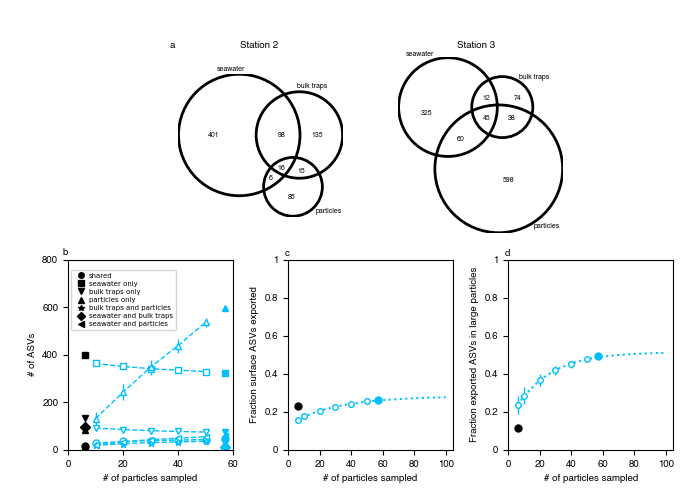

/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_925/1290680072.py:115: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig.subplots_adjust(wspace=1,hspace=0.1,bottom=0.1,top=0.9,left=0.1,right=0.99)


In [56]:
St2_total_phyto_ASVs=np.sum([len(Station2_surface_bulk_particle_comparison['surface_only_ASVs']),len(Station2_surface_bulk_particle_comparison['bulk_only_ASVs']),len(Station2_surface_bulk_particle_comparison['bulk_surface_shared_ASVs']), len(Station2_surface_bulk_particle_comparison['particle_only_ASVs']),len(Station2_surface_bulk_particle_comparison['particles_surface_shared_ASVs']),len(Station2_surface_bulk_particle_comparison['bulk_particle_shared_ASVs']),len(Station2_surface_bulk_particle_comparison['all_shared_ASVs'])])
St3_total_phyto_ASVs=np.sum([len(Station3_surface_bulk_particle_comparison['surface_only_ASVs']),len(Station3_surface_bulk_particle_comparison['bulk_only_ASVs']),len(Station3_surface_bulk_particle_comparison['bulk_surface_shared_ASVs']), len(Station3_surface_bulk_particle_comparison['particle_only_ASVs']),len(Station3_surface_bulk_particle_comparison['particles_surface_shared_ASVs']),len(Station3_surface_bulk_particle_comparison['bulk_particle_shared_ASVs']),len(Station3_surface_bulk_particle_comparison['all_shared_ASVs'])])

fig=plt.figure(figsize=(6.8,5),constrained_layout=True)
gs = fig.add_gridspec(2, 6)

ax4 = fig.add_subplot(gs[0,1:3])
venn3_circles(subsets = (len(Station2_surface_bulk_particle_comparison['surface_only_ASVs']),len(Station2_surface_bulk_particle_comparison['bulk_only_ASVs']),len(Station2_surface_bulk_particle_comparison['bulk_surface_shared_ASVs']), len(Station2_surface_bulk_particle_comparison['particle_only_ASVs']),len(Station2_surface_bulk_particle_comparison['particles_surface_shared_ASVs']),len(Station2_surface_bulk_particle_comparison['bulk_particle_shared_ASVs']),len(Station2_surface_bulk_particle_comparison['all_shared_ASVs'])),normalize_to=St2_total_phyto_ASVs,ax=ax4) 
ax4.text(-12,1,'401',fontsize=5,family='Helvetica')
ax4.text(3,1,'98',fontsize=5,family='Helvetica')
ax4.text(10,1,'135',fontsize=5,family='Helvetica')
ax4.text(2.75,-6,'16',fontsize=5,family='Helvetica')
ax4.text(1,-8,'6',fontsize=5,family='Helvetica')
ax4.text(5,-12,'85',fontsize=5,family='Helvetica')
ax4.text(7,-6.5,'15',fontsize=5,family='Helvetica')

ax4.text(-5,20,'Station 2',fontsize=7,family='Helvetica')
ax4.text(-10,15,'seawater',fontsize=5,family='Helvetica')
ax4.text(7,11.5,'bulk traps',fontsize=5,family='Helvetica')
ax4.text(11,-15,'particles',fontsize=5,family='Helvetica')

ax4.text(-20,20,'a',fontsize=7,family='Helvetica',fontweight='bold')

ax5 = fig.add_subplot(gs[0,3:5])
venn3_circles(subsets = (len(Station3_surface_bulk_particle_comparison['surface_only_ASVs']),len(Station3_surface_bulk_particle_comparison['bulk_only_ASVs']),len(Station3_surface_bulk_particle_comparison['bulk_surface_shared_ASVs']), len(Station3_surface_bulk_particle_comparison['particle_only_ASVs']),len(Station3_surface_bulk_particle_comparison['particles_surface_shared_ASVs']),len(Station3_surface_bulk_particle_comparison['bulk_particle_shared_ASVs']),len(Station3_surface_bulk_particle_comparison['all_shared_ASVs'])),normalize_to=St2_total_phyto_ASVs,ax=ax5)
ax5.text(-12,5,'325',fontsize=5,family='Helvetica')
ax5.text(0,8,'12',fontsize=5,family='Helvetica')
ax5.text(6,8,'74',fontsize=5,family='Helvetica')
ax5.text(0,4,'45',fontsize=5,family='Helvetica')
ax5.text(5,4,'38',fontsize=5,family='Helvetica')
ax5.text(-5,0,'60',fontsize=5,family='Helvetica')
ax5.text(4,-8,'598',fontsize=5,family='Helvetica')
ax5.text(-5,18,'Station 3',fontsize=7,family='Helvetica')
ax5.text(-15,16.5,'seawater',fontsize=5,family='Helvetica')
ax5.text(7,12,'bulk traps',fontsize=5,family='Helvetica')
ax5.text(10,-17,'particles',fontsize=5,family='Helvetica')


ax1 = fig.add_subplot(gs[1,0:2])
ax1.plot([6],[len(Station2_surface_bulk_particle_comparison['surface_only_ASVs'])],marker='s',lw=1,ls='dashed',color='black',mfc='black',ms=5)
ax1.plot([6],[len(Station2_surface_bulk_particle_comparison['bulk_only_ASVs'])],marker='v',lw=1,ls='dashed',color='black',mfc='black',ms=5)
ax1.plot([6],[len(Station2_surface_bulk_particle_comparison['all_shared_ASVs'])],marker='o',lw=1,ls='dashed',color='black',ms=5)
ax1.plot([6],[len(Station2_surface_bulk_particle_comparison['particle_only_ASVs'])],marker='^',lw=1,ls='dashed',color='black',mfc='black',ms=5)
ax1.plot([6],[len(Station2_surface_bulk_particle_comparison['bulk_particle_shared_ASVs'])],marker='*',lw=1,ls='dashed',color='black',mfc='black',ms=5)
ax1.plot([6],[len(Station2_surface_bulk_particle_comparison['bulk_surface_shared_ASVs'])],marker='D',lw=1,ls='dashed',color='black',mfc='black',ms=5)
ax1.plot([6],[len(Station2_surface_bulk_particle_comparison['particles_surface_shared_ASVs'])],marker='<',lw=1,ls='dashed',color='black',mfc='black',ms=5)

ax1.plot([57],[len(Station3_surface_bulk_particle_comparison['surface_only_ASVs'])],marker='s',lw=1,ls='dashed',color='deepskyblue',ms=5)
ax1.plot([57],[len(Station3_surface_bulk_particle_comparison['bulk_only_ASVs'])],marker='v',lw=1,ls='dashed',color='deepskyblue',ms=5)
ax1.plot([57],[len(Station3_surface_bulk_particle_comparison['all_shared_ASVs'])],marker='o',lw=1,ls='dashed',color='deepskyblue',ms=5)
ax1.plot([57],[len(Station3_surface_bulk_particle_comparison['particle_only_ASVs'])],marker='^',lw=1,ls='dashed',color='deepskyblue',ms=5)
ax1.plot([57],[len(Station3_surface_bulk_particle_comparison['bulk_particle_shared_ASVs'])],marker='*',lw=1,ls='dashed',color='deepskyblue',ms=5)
ax1.plot([57],[len(Station3_surface_bulk_particle_comparison['bulk_surface_shared_ASVs'])],marker='D',lw=1,ls='dashed',color='deepskyblue',ms=5)
ax1.plot([57],[len(Station3_surface_bulk_particle_comparison['particles_surface_shared_ASVs'])],marker='<',lw=1,ls='dashed',color='deepskyblue',ms=5)

ax1.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_surface_only_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_surface_only_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_surface_only_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_surface_only_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_surface_only_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_surface_only_ASVs'],St3_6way_comparison_20['STD'].loc['St3_surface_only_ASVs'],St3_6way_comparison_30['STD'].loc['St3_surface_only_ASVs'],St3_6way_comparison_40['STD'].loc['St3_surface_only_ASVs'],St3_6way_comparison_50['STD'].loc['St3_surface_only_ASVs']],marker='s',lw=1,ls='dashed',color='deepskyblue',mfc='white',ms=5)
ax1.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_bulk_only_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_20['STD'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_30['STD'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_40['STD'].loc['St3_bulk_only_ASVs'],St3_6way_comparison_50['STD'].loc['St3_bulk_only_ASVs']],marker='v',lw=1,ls='dashed',color='deepskyblue',mfc='white',ms=5)
ax1.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_all_shared_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_all_shared_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_all_shared_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_all_shared_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_all_shared_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_all_shared_ASVs'],St3_6way_comparison_20['STD'].loc['St3_all_shared_ASVs'],St3_6way_comparison_30['STD'].loc['St3_all_shared_ASVs'],St3_6way_comparison_40['STD'].loc['St3_all_shared_ASVs'],St3_6way_comparison_50['STD'].loc['St3_all_shared_ASVs']],marker='o',lw=1,ls='dashed',color='deepskyblue',mfc='white',ms=5)
ax1.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_particle_only_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_particle_only_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_particle_only_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_particle_only_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_particle_only_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_particle_only_ASVs'],St3_6way_comparison_20['STD'].loc['St3_particle_only_ASVs'],St3_6way_comparison_30['STD'].loc['St3_particle_only_ASVs'],St3_6way_comparison_40['STD'].loc['St3_particle_only_ASVs'],St3_6way_comparison_50['STD'].loc['St3_particle_only_ASVs']],marker='^',lw=1,ls='dashed',color='deepskyblue',mfc='white',ms=5)
ax1.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_bulk_particle_shared_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_20['STD'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_30['STD'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_40['STD'].loc['St3_bulk_particle_shared_ASVs'],St3_6way_comparison_50['STD'].loc['St3_bulk_particle_shared_ASVs']],marker='*',lw=1,ls='dashed',color='deepskyblue',mfc='white',ms=5)#ax3.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_bulk_surface_shared_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_20['STD'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_30['STD'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_40['STD'].loc['St3_bulk_surface_shared_ASVs'],St3_6way_comparison_50['STD'].loc['St3_bulk_surface_shared_ASVs']],marker='D',lw=1,ls='dashed',color='deepskyblue',mfc='white',ms=5)
ax1.errorbar([10,20,30,40,50],[St3_6way_comparison_10['Mean'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_20['Mean'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_30['Mean'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_40['Mean'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_50['Mean'].loc['St3_particles_surface_shared_ASVs']],yerr=[St3_6way_comparison_10['STD'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_20['STD'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_30['STD'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_40['STD'].loc['St3_particles_surface_shared_ASVs'],St3_6way_comparison_50['STD'].loc['St3_particles_surface_shared_ASVs']],marker='<',lw=1,ls='dashed',color='deepskyblue',mfc='white',ms=5)

ax1.set_xlim(0,60)
ax1.set_ylim(0,800)
ax1.set_xticks([0,20,40,60])
ax1.set_xticklabels([0,20,40,60],fontsize=7,family='Helvetica')
ax1.set_yticks([0,200,400,600,800])
ax1.set_yticklabels([0,200,400,600,800],fontsize=7,family='Helvetica')
ax1.set_xlabel('# of particles sampled',fontsize=7,family='Helvetica')
ax1.set_ylabel('# of ASVs',fontsize=7,family='Helvetica')

custom_lines =[Line2D([0], [0], color='black',marker = 'o',lw=0,ms=4),
               Line2D([0], [0], color='black',marker = 's',lw=0,ms=4),
               Line2D([0], [0], color='black',marker = 'v',lw=0,ms=4),
               Line2D([0], [0], color='black',marker = '^',lw=0,ms=4),
               Line2D([0], [0], color='black',marker = '*',lw=0,ms=4),
               Line2D([0], [0], color='black',marker = 'D',lw=0,ms=4),
               Line2D([0], [0], color='black',marker = '<',lw=0,ms=4)]

ax1.legend(custom_lines,['shared','seawater only','bulk traps only','particles only','bulk traps and particles','seawater and bulk traps','seawater and particles','St 2 samples','St 3 samples','random subsamples of St 3 particles'],labelspacing=0.3,handletextpad=0.1,frameon=True,fontsize=5,loc=[0.02,0.63])


ax1.text(-2,820,'b',fontsize=7,family='Helvetica',fontweight='bold')

ax2 = fig.add_subplot(gs[1,2:4])
ax2.plot(6,Fraction_surface_exported_St2,marker='o',ms=5,color='black')
ax2.plot(57,Fraction_surface_exported_St3,marker='o',ms=5,color='deepskyblue')
ax2.errorbar([6,10,20,30,40,50],[Fraction_surface_exported_subsample6,Fraction_surface_exported_subsample10,Fraction_surface_exported_subsample20,Fraction_surface_exported_subsample30,Fraction_surface_exported_subsample40,Fraction_surface_exported_subsample50],yerr=[Fraction_surface_exported_subsample6_sd,Fraction_surface_exported_subsample10_sd,Fraction_surface_exported_subsample20_sd,Fraction_surface_exported_subsample30_sd,Fraction_surface_exported_subsample40_sd,Fraction_surface_exported_subsample50_sd],marker='o',mfc='white',color='deepskyblue',lw=0,ms=4,elinewidth=1,ls=':')
ax2.plot([6,10,20,30,40,50,60,80,100],(surface_export_fraction_parameters.x[0]*(1-np.exp(-surface_export_fraction_parameters.x[1]*np.array([6,10,20,30,40,50,60,80,100]))))+surface_export_fraction_parameters.x[2],ls=':',color='deepskyblue')
ax2.set_ylim(0,1)
ax2.set_xlabel('# of particles sampled',fontsize=7,family='Helvetica')
ax2.set_ylabel('Fraction surface ASVs exported',fontsize=7,family='Helvetica')
ax2.set_xticks([0,20,40,60,80,100])
ax2.set_xticklabels([0,20,40,60,80,100],fontsize=7,family='Helvetica')
ax2.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax2.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=7,family='Helvetica')

ax2.text(-2,1.02,'c',fontsize=7,family='Helvetica',fontweight='bold')

ax3 = fig.add_subplot(gs[1,4:])
ax3.errorbar([6,10,20,30,40,50,60,70,80,90,100],small_particle_decay_parameters.x[0]*(1-np.exp(-small_particle_decay_parameters.x[1]*np.array([6,10,20,30,40,50,60,70,80,90,100])))+small_particle_decay_parameters.x[2],ls=':',color='deepskyblue')
ax3.errorbar([6,10,20,30,40,50],[1-small_particles_6,1-small_particles_10,1-small_particles_20,1-small_particles_30,1-small_particles_40,1-small_particles_50],yerr=[small_particles_6_sd,small_particles_10_sd,small_particles_20_sd,small_particles_30_sd,small_particles_40_sd,small_particles_50_sd],lw=0,marker='o',mfc='white',color='deepskyblue',elinewidth=1,ms=4)
ax3.plot(6, 1-(St2and3_small_large_particle_taxa3_counts['St2_small'].sum()/np.sum(St2and3_small_large_particle_taxa3_counts['St2_small']+St2and3_small_large_particle_taxa3_counts['St2_large'])),marker='o',ms=5,color='black',lw=0)
ax3.plot(57,1-(St2and3_small_large_particle_taxa3_counts['St3_small'].sum()/np.sum(St2and3_small_large_particle_taxa3_counts['St3_small']+St2and3_small_large_particle_taxa3_counts['St3_large'])),marker='o',ms=5,color='deepskyblue',lw=0)
ax3.set_ylim(0,1)
ax3.set_yticks([0,0.2,0.4,0.6,0.8,1])
ax3.set_yticklabels([0,0.2,0.4,0.6,0.8,1],fontsize=7,family='Helvetica')
ax3.set_xticks([0,20,40,60,80,100])
ax3.set_xticklabels([0,20,40,60,80,100],fontsize=7,family='Helvetica')
ax3.set_ylabel('Fraction exported ASVs in large particles',fontsize=7,family='Helvetica')
ax3.set_xlabel('# of particles sampled',fontsize=7,family='Helvetica')
#print(St2and3_small_large_particle_taxa3_counts['St3_small'].sum()/np.sum(St2and3_small_large_particle_taxa3_counts['St3_small']+St2and3_small_large_particle_taxa3_counts['St3_large']))
ax3.text(-2,1.02,'d',fontsize=7,family='Helvetica',fontweight='bold')

fig.subplots_adjust(wspace=1,hspace=0.1,bottom=0.1,top=0.9,left=0.1,right=0.99)

### Sequencing individual particles makes super rare taxa appear that were not detected in larger bulk samples (maybe because of relative sequencing effort for a given community complexity)
### Otherwise, particles just further sample the diversity within groups that were already detected

# Now Plot the fraction of Surface ASVs that were also detected in sediment traps (Phytoplankton)

In [57]:
rarified_reads=rarified_trap_surface_feature_table.copy()
rarified_reads.index=rarified_reads.OTU_ID
rarified_reads=rarified_reads.drop('OTU_ID',axis=1)


In [58]:
St3_surface_only_rarified_ASV=[]
for x in Station3_surface_bulk_particle_comparison['surface_only_ASVs']:
    if x in rarified_reads.index:
        St3_surface_only_rarified_ASV.append(x)
        
St3_all_shared_rarified_ASV=[]
for x in Station3_surface_bulk_particle_comparison['all_shared_ASVs']:
    if x in rarified_reads.index:
        St3_all_shared_rarified_ASV.append(x)
        
St3_bulk_surface_shared_rarified_ASV=[]
for x in Station3_surface_bulk_particle_comparison['bulk_surface_shared_ASVs']:
    if x in rarified_reads.index:
        St3_bulk_surface_shared_rarified_ASV.append(x)
        
St3_particle_surface_shared_rarified_ASV=[]
for x in Station3_surface_bulk_particle_comparison['particles_surface_shared_ASVs']:
    if x in rarified_reads.index:
        St3_particle_surface_shared_rarified_ASV.append(x)
        
WW3_surface_only_rarified_ASV=[]
for x in WW3_surface_bulk_particle_comparison['surface_only_ASVs']:
    if x in rarified_reads.index:
        WW3_surface_only_rarified_ASV.append(x)

WW3_all_shared_rarified_ASV=[]
for x in WW3_surface_bulk_particle_comparison['all_shared_ASVs']:
    if x in rarified_reads.index:
        WW3_all_shared_rarified_ASV.append(x)
        
WW3_bulk_surface_shared_rarified_ASV=[]
for x in WW3_surface_bulk_particle_comparison['bulk_surface_shared_ASVs']:
    if x in rarified_reads.index:
        WW3_bulk_surface_shared_rarified_ASV.append(x)
        
WW3_particle_surface_shared_rarified_ASV=[]
for x in WW3_surface_bulk_particle_comparison['particles_surface_shared_ASVs']:
    if x in rarified_reads.index:
        WW3_particle_surface_shared_rarified_ASV.append(x)
        

WW4_surface_only_rarified_ASV=[]
for x in WW4_surface_bulk_particle_comparison['surface_only_ASVs']:
    if x in rarified_reads.index:
        WW4_surface_only_rarified_ASV.append(x)
        
WW4_all_shared_rarified_ASV=[]
for x in WW4_surface_bulk_particle_comparison['all_shared_ASVs']:
    if x in rarified_reads.index:
        WW4_all_shared_rarified_ASV.append(x)
        
WW4_bulk_surface_shared_rarified_ASV=[]
for x in WW4_surface_bulk_particle_comparison['bulk_surface_shared_ASVs']:
    if x in rarified_reads.index:
        WW4_bulk_surface_shared_rarified_ASV.append(x)
        
WW4_particle_surface_shared_rarified_ASV=[]
for x in WW4_surface_bulk_particle_comparison['particles_surface_shared_ASVs']:
    if x in rarified_reads.index:
        WW4_particle_surface_shared_rarified_ASV.append(x)
        

        
St2_surface_only_rarified_ASV=[]
for x in Station2_surface_bulk_particle_comparison['surface_only_ASVs']:
    if x in rarified_reads.index:
        St2_surface_only_rarified_ASV.append(x)
        
St2_all_shared_rarified_ASV=[]
for x in Station2_surface_bulk_particle_comparison['all_shared_ASVs']:
    if x in rarified_reads.index:
        St2_all_shared_rarified_ASV.append(x)
        
St2_bulk_surface_shared_rarified_ASV=[]
for x in Station2_surface_bulk_particle_comparison['bulk_surface_shared_ASVs']:
    if x in rarified_reads.index:
        St2_bulk_surface_shared_rarified_ASV.append(x)
        
St2_particle_surface_shared_rarified_ASV=[]
for x in Station2_surface_bulk_particle_comparison['particles_surface_shared_ASVs']:
    if x in rarified_reads.index:
        St2_particle_surface_shared_rarified_ASV.append(x)

In [59]:
St3_surface_only_rarified_reads=rarified_reads.loc[St3_surface_only_rarified_ASV][Station3_surface_Samples].sum(axis=1)
St3_exported_rarified_reads=rarified_reads.loc[St3_all_shared_rarified_ASV+St3_bulk_surface_shared_rarified_ASV+St3_particle_surface_shared_rarified_ASV][Station3_surface_Samples].sum(axis=1)

WW3_surface_only_rarified_reads=rarified_reads.loc[WW3_surface_only_rarified_ASV][Station3_surface_Samples].sum(axis=1)
WW3_exported_rarified_reads=rarified_reads.loc[WW3_all_shared_rarified_ASV+WW3_bulk_surface_shared_rarified_ASV+WW3_particle_surface_shared_rarified_ASV][Station3_surface_Samples].sum(axis=1)

WW4_surface_only_rarified_reads=rarified_reads.loc[WW4_surface_only_rarified_ASV][Station3_surface_Samples].sum(axis=1)
WW4_exported_rarified_reads=rarified_reads.loc[WW4_all_shared_rarified_ASV+WW4_bulk_surface_shared_rarified_ASV+WW4_particle_surface_shared_rarified_ASV][Station3_surface_Samples].sum(axis=1)

St2_surface_only_rarified_reads=rarified_reads.loc[St2_surface_only_rarified_ASV][Station2_surface_Samples[Station2_surface_Samples!='32']].sum(axis=1)
St2_exported_rarified_reads=rarified_reads.loc[St2_all_shared_rarified_ASV+St2_bulk_surface_shared_rarified_ASV+St2_particle_surface_shared_rarified_ASV][Station2_surface_Samples[Station2_surface_Samples!='32']].sum(axis=1)

In [60]:
Chlorophyte_ASVs=Traps_surface_taxonomy[Traps_surface_taxonomy.taxa2=='Chlorophyta']['Feature ID']
Ochrophyta_ASVs1=Traps_surface_taxonomy[Traps_surface_taxonomy.taxa2=='Ochrophyta']
Ochrophyta_ASVs=Ochrophyta_ASVs1[Ochrophyta_ASVs1.taxa3!='Bacillariophyta']['Feature ID']
Diatom_ASVs=Ochrophyta_ASVs1[Ochrophyta_ASVs1.taxa3=='Bacillariophyta']['Feature ID']
Hacrobia_ASVs=Traps_surface_taxonomy[Traps_surface_taxonomy.taxa2=='Haptophyta']['Feature ID']
Dinoflagellate_ASVs=Traps_surface_taxonomy[Traps_surface_taxonomy.taxa2=='Dinoflagellata']
Dinoflagellate_ASVs=Dinoflagellate_ASVs[Dinoflagellate_ASVs.taxa3!='Syndiniales']['Feature ID']
Dinoflagellate_ASVs

St3_surface_only_ASV_chlorophytes=[]
St3_surface_only_ASV_ochrophytes=[]
St3_surface_only_ASV_diatoms=[]
St3_surface_only_ASV_hacrobia=[]
St3_surface_only_ASV_dinoflagellates=[]
for x in St3_surface_only_rarified_reads.index:
    if x in np.array(Chlorophyte_ASVs):
        St3_surface_only_ASV_chlorophytes.append(x)
    if x in np.array(Ochrophyta_ASVs):
        St3_surface_only_ASV_ochrophytes.append(x)
    if x in np.array(Diatom_ASVs):
        St3_surface_only_ASV_diatoms.append(x)
    if x in np.array(Hacrobia_ASVs):
        St3_surface_only_ASV_hacrobia.append(x)
    if x in np.array(Dinoflagellate_ASVs):
        St3_surface_only_ASV_dinoflagellates.append(x)

St3_exported_ASV_chlorophytes=[]
St3_exported_ASV_ochrophytes=[]
St3_exported_ASV_diatoms=[]
St3_exported_ASV_hacrobia=[]
St3_exported_ASV_dinoflagellates=[]

for x in St3_exported_rarified_reads.index:
    if x in np.array(Chlorophyte_ASVs):
        St3_exported_ASV_chlorophytes.append(x)
    if x in np.array(Ochrophyta_ASVs):
        St3_exported_ASV_ochrophytes.append(x)
    if x in np.array(Diatom_ASVs):
        St3_exported_ASV_diatoms.append(x)
    if x in np.array(Hacrobia_ASVs):
        St3_exported_ASV_hacrobia.append(x)
    if x in np.array(Dinoflagellate_ASVs):
        St3_exported_ASV_dinoflagellates.append(x)

WW3_surface_only_ASV_chlorophytes=[]
WW3_surface_only_ASV_ochrophytes=[]
WW3_surface_only_ASV_diatoms=[]
WW3_surface_only_ASV_hacrobia=[]
WW3_surface_only_ASV_dinoflagellates=[]
for x in WW3_surface_only_rarified_reads.index:
    if x in np.array(Chlorophyte_ASVs):
        WW3_surface_only_ASV_chlorophytes.append(x)
    if x in np.array(Ochrophyta_ASVs):
        WW3_surface_only_ASV_ochrophytes.append(x)
    if x in np.array(Diatom_ASVs):
        WW3_surface_only_ASV_diatoms.append(x)
    if x in np.array(Hacrobia_ASVs):
        WW3_surface_only_ASV_hacrobia.append(x)
    if x in np.array(Dinoflagellate_ASVs):
        WW3_surface_only_ASV_dinoflagellates.append(x)

WW3_exported_ASV_chlorophytes=[]
WW3_exported_ASV_ochrophytes=[]
WW3_exported_ASV_diatoms=[]
WW3_exported_ASV_hacrobia=[]
WW3_exported_ASV_dinoflagellates=[]

for x in WW3_exported_rarified_reads.index:
    if x in np.array(Chlorophyte_ASVs):
        WW3_exported_ASV_chlorophytes.append(x)
    if x in np.array(Ochrophyta_ASVs):
        WW3_exported_ASV_ochrophytes.append(x)
    if x in np.array(Diatom_ASVs):
        WW3_exported_ASV_diatoms.append(x)
    if x in np.array(Hacrobia_ASVs):
        WW3_exported_ASV_hacrobia.append(x)
    if x in np.array(Dinoflagellate_ASVs):
        WW3_exported_ASV_dinoflagellates.append(x)

WW4_surface_only_ASV_chlorophytes=[]
WW4_surface_only_ASV_ochrophytes=[]
WW4_surface_only_ASV_diatoms=[]
WW4_surface_only_ASV_hacrobia=[]
WW4_surface_only_ASV_dinoflagellates=[]
for x in WW4_surface_only_rarified_reads.index:
    if x in np.array(Chlorophyte_ASVs):
        WW4_surface_only_ASV_chlorophytes.append(x)
    if x in np.array(Ochrophyta_ASVs):
        WW4_surface_only_ASV_ochrophytes.append(x)
    if x in np.array(Diatom_ASVs):
        WW4_surface_only_ASV_diatoms.append(x)
    if x in np.array(Hacrobia_ASVs):
        WW4_surface_only_ASV_hacrobia.append(x)
    if x in np.array(Dinoflagellate_ASVs):
        WW4_surface_only_ASV_dinoflagellates.append(x)

WW4_exported_ASV_chlorophytes=[]
WW4_exported_ASV_ochrophytes=[]
WW4_exported_ASV_diatoms=[]
WW4_exported_ASV_hacrobia=[]
WW4_exported_ASV_dinoflagellates=[]

for x in WW4_exported_rarified_reads.index:
    if x in np.array(Chlorophyte_ASVs):
        WW4_exported_ASV_chlorophytes.append(x)
    if x in np.array(Ochrophyta_ASVs):
        WW4_exported_ASV_ochrophytes.append(x)
    if x in np.array(Diatom_ASVs):
        WW4_exported_ASV_diatoms.append(x)
    if x in np.array(Hacrobia_ASVs):
        WW4_exported_ASV_hacrobia.append(x)
    if x in np.array(Dinoflagellate_ASVs):
        WW4_exported_ASV_dinoflagellates.append(x)




St2_surface_only_ASV_chlorophytes=[]
St2_surface_only_ASV_ochrophytes=[]
St2_surface_only_ASV_diatoms=[]
St2_surface_only_ASV_hacrobia=[]
St2_surface_only_ASV_dinoflagellates=[]
for x in St2_surface_only_rarified_reads.index:
    if x in np.array(Chlorophyte_ASVs):
        St2_surface_only_ASV_chlorophytes.append(x)
    if x in np.array(Ochrophyta_ASVs):
        St2_surface_only_ASV_ochrophytes.append(x)
    if x in np.array(Diatom_ASVs):
        St2_surface_only_ASV_diatoms.append(x)
    if x in np.array(Hacrobia_ASVs):
        St2_surface_only_ASV_hacrobia.append(x)
    if x in np.array(Dinoflagellate_ASVs):
        St2_surface_only_ASV_dinoflagellates.append(x)

St2_exported_ASV_chlorophytes=[]
St2_exported_ASV_ochrophytes=[]
St2_exported_ASV_diatoms=[]
St2_exported_ASV_hacrobia=[]
St2_exported_ASV_dinoflagellates=[]

for x in St2_exported_rarified_reads.index:
    if x in np.array(Chlorophyte_ASVs):
        St2_exported_ASV_chlorophytes.append(x)
    if x in np.array(Ochrophyta_ASVs):
        St2_exported_ASV_ochrophytes.append(x)
    if x in np.array(Diatom_ASVs):
        St2_exported_ASV_diatoms.append(x)
    if x in np.array(Hacrobia_ASVs):
        St2_exported_ASV_hacrobia.append(x)
    if x in np.array(Dinoflagellate_ASVs):
        St2_exported_ASV_dinoflagellates.append(x)        


In [61]:
chlorophyte_total=St3_surface_only_rarified_reads.loc[St3_surface_only_ASV_chlorophytes].sum()+St3_exported_rarified_reads.loc[St3_exported_ASV_chlorophytes].sum()
St3_surface_only_relative_reads_chlorophytes=St3_surface_only_rarified_reads.loc[St3_surface_only_ASV_chlorophytes]/chlorophyte_total
St3_surface_only_relative_reads_chlorophytes=St3_surface_only_relative_reads_chlorophytes.sort_values(ascending=False)
St3_exported_relative_reads_chlorophytes=St3_exported_rarified_reads.loc[St3_exported_ASV_chlorophytes]/chlorophyte_total
St3_exported_relative_reads_chlorophytes=St3_exported_relative_reads_chlorophytes.sort_values(ascending=False)

ochrophytes_total=St3_surface_only_rarified_reads.loc[St3_surface_only_ASV_ochrophytes].sum()+St3_exported_rarified_reads.loc[St3_exported_ASV_ochrophytes].sum()
St3_surface_only_relative_reads_ochrophytes=St3_surface_only_rarified_reads.loc[St3_surface_only_ASV_ochrophytes]/ochrophytes_total
St3_surface_only_relative_reads_ochrophytes=St3_surface_only_relative_reads_ochrophytes.sort_values(ascending=False)
St3_exported_relative_reads_ochrophytes=St3_exported_rarified_reads.loc[St3_exported_ASV_ochrophytes]/ochrophytes_total
St3_exported_relative_reads_ochrophytes=St3_exported_relative_reads_ochrophytes.sort_values(ascending=False)

diatoms_total=St3_surface_only_rarified_reads.loc[St3_surface_only_ASV_diatoms].sum()+St3_exported_rarified_reads.loc[St3_exported_ASV_diatoms].sum()
St3_surface_only_relative_reads_diatoms=St3_surface_only_rarified_reads.loc[St3_surface_only_ASV_diatoms]/diatoms_total
St3_surface_only_relative_reads_diatoms=St3_surface_only_relative_reads_diatoms.sort_values(ascending=False)
St3_exported_relative_reads_diatoms=St3_exported_rarified_reads.loc[St3_exported_ASV_diatoms]/diatoms_total
St3_exported_relative_reads_diatoms=St3_exported_relative_reads_diatoms.sort_values(ascending=False)

dinoflagellates_total=St3_surface_only_rarified_reads.loc[St3_surface_only_ASV_dinoflagellates].sum()+St3_exported_rarified_reads.loc[St3_exported_ASV_dinoflagellates].sum()
St3_surface_only_relative_reads_dinoflagellates=St3_surface_only_rarified_reads.loc[St3_surface_only_ASV_dinoflagellates]/dinoflagellates_total
St3_surface_only_relative_reads_dinoflagellates=St3_surface_only_relative_reads_dinoflagellates.sort_values(ascending=False)
St3_exported_relative_reads_dinoflagellates=St3_exported_rarified_reads.loc[St3_exported_ASV_dinoflagellates]/dinoflagellates_total
St3_exported_relative_reads_dinoflagellates=St3_exported_relative_reads_dinoflagellates.sort_values(ascending=False)

hacrobia_total=St3_surface_only_rarified_reads.loc[St3_surface_only_ASV_hacrobia].sum()+St3_exported_rarified_reads.loc[St3_exported_ASV_hacrobia].sum()
St3_surface_only_relative_reads_hacrobia=St3_surface_only_rarified_reads.loc[St3_surface_only_ASV_hacrobia]/hacrobia_total
St3_surface_only_relative_reads_hacrobias=St3_surface_only_relative_reads_hacrobia.sort_values(ascending=False)
St3_exported_relative_reads_hacrobia=St3_exported_rarified_reads.loc[St3_exported_ASV_hacrobia]/hacrobia_total
St3_exported_relative_reads_hacrobia=St3_exported_relative_reads_hacrobia.sort_values(ascending=False)


In [62]:
chlorophyte_total2=St2_surface_only_rarified_reads.loc[St2_surface_only_ASV_chlorophytes].sum()+St2_exported_rarified_reads.loc[St2_exported_ASV_chlorophytes].sum()
St2_surface_only_relative_reads_chlorophytes=St2_surface_only_rarified_reads.loc[St2_surface_only_ASV_chlorophytes]/chlorophyte_total2
St2_surface_only_relative_reads_chlorophytes=St2_surface_only_relative_reads_chlorophytes.sort_values(ascending=False)

St2_exported_relative_reads_chlorophytes=St2_exported_rarified_reads.loc[St2_exported_ASV_chlorophytes]/chlorophyte_total2
St2_exported_relative_reads_chlorophytes=St2_exported_relative_reads_chlorophytes.sort_values(ascending=False)

ochrophytes_total2=St2_surface_only_rarified_reads.loc[St2_surface_only_ASV_ochrophytes].sum()+St2_exported_rarified_reads.loc[St2_exported_ASV_ochrophytes].sum()
St2_surface_only_relative_reads_ochrophytes=St2_surface_only_rarified_reads.loc[St2_surface_only_ASV_ochrophytes]/ochrophytes_total2
St2_surface_only_relative_reads_ochrophytes=St2_surface_only_relative_reads_ochrophytes.sort_values(ascending=False)
St2_exported_relative_reads_ochrophytes=St2_exported_rarified_reads.loc[St2_exported_ASV_ochrophytes]/ochrophytes_total2
St2_exported_relative_reads_ochrophytes=St2_exported_relative_reads_ochrophytes.sort_values(ascending=False)

diatoms_total2=St2_surface_only_rarified_reads.loc[St2_surface_only_ASV_diatoms].sum()+St2_exported_rarified_reads.loc[St2_exported_ASV_diatoms].sum()
St2_surface_only_relative_reads_diatoms=St2_surface_only_rarified_reads.loc[St2_surface_only_ASV_diatoms]/diatoms_total2
St2_surface_only_relative_reads_diatoms=St2_surface_only_relative_reads_diatoms.sort_values(ascending=False)
St2_exported_relative_reads_diatoms=St2_exported_rarified_reads.loc[St2_exported_ASV_diatoms]/diatoms_total2
St2_exported_relative_reads_diatoms=St2_exported_relative_reads_diatoms.sort_values(ascending=False)

dinoflagellates_total2=St2_surface_only_rarified_reads.loc[St2_surface_only_ASV_dinoflagellates].sum()+St2_exported_rarified_reads.loc[St2_exported_ASV_dinoflagellates].sum()
St2_surface_only_relative_reads_dinoflagellates=St2_surface_only_rarified_reads.loc[St2_surface_only_ASV_dinoflagellates]/dinoflagellates_total2
St2_surface_only_relative_reads_dinoflagellates=St2_surface_only_relative_reads_dinoflagellates.sort_values(ascending=False)
St2_exported_relative_reads_dinoflagellates=St2_exported_rarified_reads.loc[St2_exported_ASV_dinoflagellates]/dinoflagellates_total2
St2_exported_relative_reads_dinoflagellates=St2_exported_relative_reads_dinoflagellates.sort_values(ascending=False)

hacrobia_total2=St2_surface_only_rarified_reads.loc[St2_surface_only_ASV_hacrobia].sum()+St2_exported_rarified_reads.loc[St2_exported_ASV_hacrobia].sum()
St2_surface_only_relative_reads_hacrobia=St2_surface_only_rarified_reads.loc[St2_surface_only_ASV_hacrobia]/hacrobia_total2
St2_surface_only_relative_reads_hacrobias=St2_surface_only_relative_reads_hacrobia.sort_values(ascending=False)
St2_exported_relative_reads_hacrobia=St2_exported_rarified_reads.loc[St2_exported_ASV_hacrobia]/hacrobia_total2
St2_exported_relative_reads_hacrobia=St2_exported_relative_reads_hacrobia.sort_values(ascending=False)


In [63]:
chlorophyte_total_WW3=WW3_surface_only_rarified_reads.loc[WW3_surface_only_ASV_chlorophytes].sum()+WW3_exported_rarified_reads.loc[WW3_exported_ASV_chlorophytes].sum()
WW3_surface_only_relative_reads_chlorophytes=WW3_surface_only_rarified_reads.loc[WW3_surface_only_ASV_chlorophytes]/chlorophyte_total_WW3
WW3_surface_only_relative_reads_chlorophytes=WW3_surface_only_relative_reads_chlorophytes.sort_values(ascending=False)
WW3_exported_relative_reads_chlorophytes=WW3_exported_rarified_reads.loc[WW3_exported_ASV_chlorophytes]/chlorophyte_total_WW3
WW3_exported_relative_reads_chlorophytes=WW3_exported_relative_reads_chlorophytes.sort_values(ascending=False)

ochrophytes_total_WW3=WW3_surface_only_rarified_reads.loc[WW3_surface_only_ASV_ochrophytes].sum()+WW3_exported_rarified_reads.loc[WW3_exported_ASV_ochrophytes].sum()
WW3_surface_only_relative_reads_ochrophytes=WW3_surface_only_rarified_reads.loc[WW3_surface_only_ASV_ochrophytes]/ochrophytes_total_WW3
WW3_surface_only_relative_reads_ochrophytes=WW3_surface_only_relative_reads_ochrophytes.sort_values(ascending=False)
WW3_exported_relative_reads_ochrophytes=WW3_exported_rarified_reads.loc[WW3_exported_ASV_ochrophytes]/ochrophytes_total_WW3
WW3_exported_relative_reads_ochrophytes=WW3_exported_relative_reads_ochrophytes.sort_values(ascending=False)

diatoms_total_WW3=WW3_surface_only_rarified_reads.loc[WW3_surface_only_ASV_diatoms].sum()+WW3_exported_rarified_reads.loc[WW3_exported_ASV_diatoms].sum()
WW3_surface_only_relative_reads_diatoms=WW3_surface_only_rarified_reads.loc[WW3_surface_only_ASV_diatoms]/diatoms_total_WW3
WW3_surface_only_relative_reads_diatoms=WW3_surface_only_relative_reads_diatoms.sort_values(ascending=False)
WW3_exported_relative_reads_diatoms=WW3_exported_rarified_reads.loc[WW3_exported_ASV_diatoms]/diatoms_total_WW3
WW3_exported_relative_reads_diatoms=WW3_exported_relative_reads_diatoms.sort_values(ascending=False)

dinoflagellates_total_WW3=WW3_surface_only_rarified_reads.loc[WW3_surface_only_ASV_dinoflagellates].sum()+WW3_exported_rarified_reads.loc[WW3_exported_ASV_dinoflagellates].sum()
WW3_surface_only_relative_reads_dinoflagellates=WW3_surface_only_rarified_reads.loc[WW3_surface_only_ASV_dinoflagellates]/dinoflagellates_total_WW3
WW3_surface_only_relative_reads_dinoflagellates=WW3_surface_only_relative_reads_dinoflagellates.sort_values(ascending=False)
WW3_exported_relative_reads_dinoflagellates=WW3_exported_rarified_reads.loc[WW3_exported_ASV_dinoflagellates]/dinoflagellates_total_WW3
WW3_exported_relative_reads_dinoflagellates=WW3_exported_relative_reads_dinoflagellates.sort_values(ascending=False)

hacrobia_total_WW3=WW3_surface_only_rarified_reads.loc[WW3_surface_only_ASV_hacrobia].sum()+WW3_exported_rarified_reads.loc[WW3_exported_ASV_hacrobia].sum()
WW3_surface_only_relative_reads_hacrobia=WW3_surface_only_rarified_reads.loc[WW3_surface_only_ASV_hacrobia]/hacrobia_total_WW3
WW3_surface_only_relative_reads_hacrobias=WW3_surface_only_relative_reads_hacrobia.sort_values(ascending=False)
WW3_exported_relative_reads_hacrobia=WW3_exported_rarified_reads.loc[WW3_exported_ASV_hacrobia]/hacrobia_total_WW3
WW3_exported_relative_reads_hacrobia=WW3_exported_relative_reads_hacrobia.sort_values(ascending=False)


In [64]:
chlorophyte_total_WW4=WW4_surface_only_rarified_reads.loc[WW4_surface_only_ASV_chlorophytes].sum()+WW4_exported_rarified_reads.loc[WW4_exported_ASV_chlorophytes].sum()
WW4_surface_only_relative_reads_chlorophytes=WW4_surface_only_rarified_reads.loc[WW4_surface_only_ASV_chlorophytes]/chlorophyte_total_WW4
WW4_surface_only_relative_reads_chlorophytes=WW4_surface_only_relative_reads_chlorophytes.sort_values(ascending=False)
WW4_exported_relative_reads_chlorophytes=WW4_exported_rarified_reads.loc[WW4_exported_ASV_chlorophytes]/chlorophyte_total_WW4
WW4_exported_relative_reads_chlorophytes=WW4_exported_relative_reads_chlorophytes.sort_values(ascending=False)

ochrophytes_total_WW4=WW4_surface_only_rarified_reads.loc[WW4_surface_only_ASV_ochrophytes].sum()+WW4_exported_rarified_reads.loc[WW4_exported_ASV_ochrophytes].sum()
WW4_surface_only_relative_reads_ochrophytes=WW4_surface_only_rarified_reads.loc[WW4_surface_only_ASV_ochrophytes]/ochrophytes_total_WW4
WW4_surface_only_relative_reads_ochrophytes=WW4_surface_only_relative_reads_ochrophytes.sort_values(ascending=False)
WW4_exported_relative_reads_ochrophytes=WW4_exported_rarified_reads.loc[WW4_exported_ASV_ochrophytes]/ochrophytes_total_WW4
WW4_exported_relative_reads_ochrophytes=WW4_exported_relative_reads_ochrophytes.sort_values(ascending=False)

diatoms_total_WW4=WW4_surface_only_rarified_reads.loc[WW4_surface_only_ASV_diatoms].sum()+WW4_exported_rarified_reads.loc[WW4_exported_ASV_diatoms].sum()
WW4_surface_only_relative_reads_diatoms=WW4_surface_only_rarified_reads.loc[WW4_surface_only_ASV_diatoms]/diatoms_total_WW4
WW4_surface_only_relative_reads_diatoms=WW4_surface_only_relative_reads_diatoms.sort_values(ascending=False)
WW4_exported_relative_reads_diatoms=WW4_exported_rarified_reads.loc[WW4_exported_ASV_diatoms]/diatoms_total_WW4
WW4_exported_relative_reads_diatoms=WW4_exported_relative_reads_diatoms.sort_values(ascending=False)

dinoflagellates_total_WW4=WW4_surface_only_rarified_reads.loc[WW4_surface_only_ASV_dinoflagellates].sum()+WW4_exported_rarified_reads.loc[WW4_exported_ASV_dinoflagellates].sum()
WW4_surface_only_relative_reads_dinoflagellates=WW4_surface_only_rarified_reads.loc[WW4_surface_only_ASV_dinoflagellates]/dinoflagellates_total_WW4
WW4_surface_only_relative_reads_dinoflagellates=WW4_surface_only_relative_reads_dinoflagellates.sort_values(ascending=False)
WW4_exported_relative_reads_dinoflagellates=WW4_exported_rarified_reads.loc[WW4_exported_ASV_dinoflagellates]/dinoflagellates_total_WW4
WW4_exported_relative_reads_dinoflagellates=WW4_exported_relative_reads_dinoflagellates.sort_values(ascending=False)

hacrobia_total_WW4=WW4_surface_only_rarified_reads.loc[WW4_surface_only_ASV_hacrobia].sum()+WW4_exported_rarified_reads.loc[WW4_exported_ASV_hacrobia].sum()
WW4_surface_only_relative_reads_hacrobia=WW4_surface_only_rarified_reads.loc[WW4_surface_only_ASV_hacrobia]/hacrobia_total_WW4
WW4_surface_only_relative_reads_hacrobias=WW4_surface_only_relative_reads_hacrobia.sort_values(ascending=False)
WW4_exported_relative_reads_hacrobia=WW4_exported_rarified_reads.loc[WW4_exported_ASV_hacrobia]/hacrobia_total_WW4
WW4_exported_relative_reads_hacrobia=WW4_exported_relative_reads_hacrobia.sort_values(ascending=False)




In [65]:
##Use this code to get the list of phytoplankton taxa in each functional group, in the order of their relative abundance.
##I used this to add names to the treemaps figures later on

Hacrobia_taxa=[]
for x in St2_exported_relative_reads_hacrobia.index:
    Hacrobia_taxa.append(Traps_surface_taxonomy[Traps_surface_taxonomy['Feature ID']==x].taxa7.values[0])
Hacrobia_taxa.append('break')
for x in St2_surface_only_relative_reads_hacrobia.index:
    Hacrobia_taxa.append(Traps_surface_taxonomy[Traps_surface_taxonomy['Feature ID']==x].taxa7.values[0])



In [66]:
print('Fraction of surface reads associated with exported diatom ASVs')
print('St2: ' + str(St2_exported_relative_reads_diatoms.sum()))
print('St3: ' + str(St3_exported_relative_reads_diatoms.sum()))

print('Fraction of surface reads associated with exported ochrophyte ASVs')
print('St2: ' + str(St2_exported_relative_reads_ochrophytes.sum()))
print('St3: ' + str(St3_exported_relative_reads_ochrophytes.sum()))

print('Fraction of surface reads associated with exported chlorophytes ASVs')
print('St2: ' + str(St2_exported_relative_reads_chlorophytes.sum()))
print('St3: ' + str(St3_exported_relative_reads_chlorophytes.sum()))


print('Fraction of surface reads associated with exported hacrobia ASVs')
print('St2: ' + str(St2_exported_relative_reads_hacrobia.sum()))
print('St3: ' + str(St3_exported_relative_reads_hacrobia.sum()))

print('Fraction of surface reads associated with exported dinoflagellates ASVs')
print('St2: ' + str(St2_exported_relative_reads_dinoflagellates.sum()))
print('St3: ' + str(St3_exported_relative_reads_dinoflagellates.sum()))




Fraction of surface reads associated with exported diatom ASVs
St2: 0.10236220472440943
St3: 0.7792084575765791
Fraction of surface reads associated with exported ochrophyte ASVs
St2: 0.885144502506132
St3: 0.5776275007044238
Fraction of surface reads associated with exported chlorophytes ASVs
St2: 0.8339622641509434
St3: 0.9216997727772483
Fraction of surface reads associated with exported hacrobia ASVs
St2: 0.4939230922494521
St3: 0.15754114880752437
Fraction of surface reads associated with exported dinoflagellates ASVs
St2: 0.6797019844812195
St3: 0.7594310210444273


In [67]:


figure=go.Figure(layout=dict(width=2066,height=1000,font=dict(family='Arial',size=7)))

fig = make_subplots(
    cols = 5, rows = 2,
    column_widths = [0.2, 0.2, 0.2,0.2,0.2],
    horizontal_spacing = 0.02,
    vertical_spacing = 0.08,
    #    subplot_titles = ('Chlorophytes','Ochrophytes','Diatoms','Dinoflagellates','Hacrobia'),
    specs = [[{'type': 'treemap'}, {'type': 'treemap'},{'type': 'treemap'},{'type': 'treemap'},{'type': 'treemap'}],[{'type': 'treemap'}, {'type': 'treemap'},{'type': 'treemap'},{'type': 'treemap'},{'type': 'treemap'}]],
    figure=figure
)

values = list(St2_exported_relative_reads_chlorophytes)+list(St2_surface_only_relative_reads_chlorophytes)
labels = list(St2_exported_relative_reads_chlorophytes.index)+list(St2_surface_only_relative_reads_chlorophytes.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St2_exported_relative_reads_chlorophytes)))+list(np.repeat('',len(St2_surface_only_relative_reads_chlorophytes))),
    marker=dict(colors=list(np.repeat('white',len(St2_exported_relative_reads_chlorophytes)))+list(np.repeat('white',len(St2_surface_only_relative_reads_chlorophytes))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=6,color=list(np.repeat('green',len(St2_exported_relative_reads_chlorophytes)))+list(np.repeat('lightgrey',len(St2_surface_only_relative_reads_chlorophytes))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='white',family='Arial')),
    row=1,col=1)

values = list(St2_exported_relative_reads_ochrophytes)+list(St2_surface_only_relative_reads_ochrophytes)
labels = list(St2_exported_relative_reads_ochrophytes.index)+list(St2_surface_only_relative_reads_ochrophytes.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St2_exported_relative_reads_ochrophytes)))+list(np.repeat('',len(St2_surface_only_relative_reads_ochrophytes))),
    marker=dict(colors=list(np.repeat('white',len(St2_exported_relative_reads_ochrophytes)))+list(np.repeat('white',len(St2_surface_only_relative_reads_ochrophytes))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=6,color=list(np.repeat('gold',len(St2_exported_relative_reads_ochrophytes)))+list(np.repeat('lightgrey',len(St2_surface_only_relative_reads_ochrophytes))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='white',family='Arial')),
    row=1,col=2)

values = list(St2_exported_relative_reads_diatoms)+list(St2_surface_only_relative_reads_diatoms)
labels = list(St2_exported_relative_reads_diatoms.index)+list(St2_surface_only_relative_reads_diatoms.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St2_exported_relative_reads_diatoms)))+list(np.repeat('',len(St2_surface_only_relative_reads_diatoms))),
    marker=dict(colors=list(np.repeat('white',len(St2_exported_relative_reads_diatoms)))+list(np.repeat('white',len(St2_surface_only_relative_reads_diatoms))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=6,color=list(np.repeat('orange',len(St2_exported_relative_reads_diatoms)))+list(np.repeat('lightgrey',len(St2_surface_only_relative_reads_diatoms))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='white',family='Arial')),
    row=1,col=3)


values = list(St2_exported_relative_reads_dinoflagellates)+list(St2_surface_only_relative_reads_dinoflagellates)
labels = list(St2_exported_relative_reads_dinoflagellates.index)+list(St2_surface_only_relative_reads_dinoflagellates.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St2_exported_relative_reads_dinoflagellates)))+list(np.repeat('',len(St2_surface_only_relative_reads_dinoflagellates))),
    marker=dict(colors=list(np.repeat('white',len(St2_exported_relative_reads_dinoflagellates)))+list(np.repeat('white',len(St2_surface_only_relative_reads_dinoflagellates))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=6,color=list(np.repeat('navy',len(St2_exported_relative_reads_dinoflagellates)))+list(np.repeat('lightgrey',len(St2_surface_only_relative_reads_dinoflagellates))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='white',family='Arial')),
    row=1,col=4)

values = list(St2_exported_relative_reads_hacrobia)+list(St2_surface_only_relative_reads_hacrobia)
labels = list(St2_exported_relative_reads_hacrobia.index)+list(St2_surface_only_relative_reads_hacrobia.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St2_exported_relative_reads_hacrobia)))+list(np.repeat('',len(St2_surface_only_relative_reads_hacrobias))),
    marker=dict(colors=list(np.repeat('white',len(St2_exported_relative_reads_hacrobia)))+list(np.repeat('white',len(St2_surface_only_relative_reads_hacrobia))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=6,color=list(np.repeat('deepskyblue',len(St2_exported_relative_reads_hacrobia)))+list(np.repeat('lightgrey',len(St2_surface_only_relative_reads_hacrobia))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='white',family='Arial')),
    row=1,col=5)






values = list(St3_exported_relative_reads_chlorophytes)+list(St3_surface_only_relative_reads_chlorophytes)
labels = list(St3_exported_relative_reads_chlorophytes.index)+list(St3_surface_only_relative_reads_chlorophytes.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_chlorophytes)))+list(np.repeat('',len(St3_surface_only_relative_reads_chlorophytes))),
    marker=dict(colors=list(np.repeat('white',len(St3_exported_relative_reads_chlorophytes)))+list(np.repeat('white',len(St3_surface_only_relative_reads_chlorophytes))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=6,color=list(np.repeat('green',len(St3_exported_relative_reads_chlorophytes)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_chlorophytes))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='white',family='Arial')),
    row=2,col=1)

values = list(St3_exported_relative_reads_ochrophytes)+list(St3_surface_only_relative_reads_ochrophytes)
labels = list(St3_exported_relative_reads_ochrophytes.index)+list(St3_surface_only_relative_reads_ochrophytes.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_ochrophytes)))+list(np.repeat('',len(St3_surface_only_relative_reads_ochrophytes))),
    marker=dict(colors=list(np.repeat('white',len(St3_exported_relative_reads_ochrophytes)))+list(np.repeat('white',len(St3_surface_only_relative_reads_ochrophytes))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=6,color=list(np.repeat('gold',len(St3_exported_relative_reads_ochrophytes)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_ochrophytes))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='white',family='Arial')),
    row=2,col=2)

values = list(St3_exported_relative_reads_diatoms)+list(St3_surface_only_relative_reads_diatoms)
labels = list(St3_exported_relative_reads_diatoms.index)+list(St3_surface_only_relative_reads_diatoms.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_diatoms)))+list(np.repeat('',len(St3_surface_only_relative_reads_diatoms))),
    marker=dict(colors=list(np.repeat('white',len(St3_exported_relative_reads_diatoms)))+list(np.repeat('white',len(St3_surface_only_relative_reads_diatoms))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=6,color=list(np.repeat('orange',len(St3_exported_relative_reads_diatoms)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_diatoms))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='white',family='Arial')),
    row=2,col=3)


values = list(St3_exported_relative_reads_dinoflagellates)+list(St3_surface_only_relative_reads_dinoflagellates)
labels = list(St3_exported_relative_reads_dinoflagellates.index)+list(St3_surface_only_relative_reads_dinoflagellates.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_dinoflagellates)))+list(np.repeat('',len(St3_surface_only_relative_reads_dinoflagellates))),
    marker=dict(colors=list(np.repeat('white',len(St3_exported_relative_reads_dinoflagellates)))+list(np.repeat('white',len(St3_surface_only_relative_reads_dinoflagellates))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=6,color=list(np.repeat('navy',len(St3_exported_relative_reads_dinoflagellates)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_dinoflagellates))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='white',family='Arial')),
    row=2,col=4)

values = list(St3_exported_relative_reads_hacrobia)+list(St3_surface_only_relative_reads_hacrobia)
labels = list(St3_exported_relative_reads_hacrobia.index)+list(St3_surface_only_relative_reads_hacrobia.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_hacrobia)))+list(np.repeat('',len(St3_surface_only_relative_reads_hacrobias))),
    marker=dict(colors=list(np.repeat('white',len(St3_exported_relative_reads_hacrobia)))+list(np.repeat('white',len(St3_surface_only_relative_reads_hacrobia))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=6,color=list(np.repeat('deepskyblue',len(St3_exported_relative_reads_hacrobia)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_hacrobia))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='white',family='Arial')),
    row=2,col=5)

fig.show()

In [68]:
figure=go.Figure(layout=dict(width=2066,height=500,font=dict(family='Arial',size=7)))

fig = make_subplots(
    cols = 5, rows = 1,
    column_widths = [0.2, 0.2, 0.2,0.2,0.2],
    horizontal_spacing = 0.02,
    #    subplot_titles = ('Chlorophytes','Ochrophytes','Diatoms','Dinoflagellates','Hacrobia'),
    specs = [[{'type': 'treemap'}, {'type': 'treemap'},{'type': 'treemap'},{'type': 'treemap'},{'type': 'treemap'}]],
    figure=figure
)

values = list(St3_exported_relative_reads_chlorophytes)+list(St3_surface_only_relative_reads_chlorophytes)
labels = list(St3_exported_relative_reads_chlorophytes.index)+list(St3_surface_only_relative_reads_chlorophytes.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_chlorophytes)))+list(np.repeat('',len(St3_surface_only_relative_reads_chlorophytes))),
    marker=dict(colors=list(np.repeat('olivedrab',len(St3_exported_relative_reads_chlorophytes)))+list(np.repeat('white',len(St3_surface_only_relative_reads_chlorophytes))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('olivedrab',len(St3_exported_relative_reads_chlorophytes)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_chlorophytes))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='olivedrab',family='Arial')),
    row=1,col=1)

values = list(St3_exported_relative_reads_ochrophytes)+list(St3_surface_only_relative_reads_ochrophytes)
labels = list(St3_exported_relative_reads_ochrophytes.index)+list(St3_surface_only_relative_reads_ochrophytes.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_ochrophytes)))+list(np.repeat('',len(St3_surface_only_relative_reads_ochrophytes))),
    marker=dict(colors=list(np.repeat('gold',len(St3_exported_relative_reads_ochrophytes)))+list(np.repeat('white',len(St3_surface_only_relative_reads_ochrophytes))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('gold',len(St3_exported_relative_reads_ochrophytes)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_ochrophytes))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='gold',family='Arial')),
    row=1,col=2)

values = list(St3_exported_relative_reads_diatoms)+list(St3_surface_only_relative_reads_diatoms)
labels = list(St3_exported_relative_reads_diatoms.index)+list(St3_surface_only_relative_reads_diatoms.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_diatoms)))+list(np.repeat('',len(St3_surface_only_relative_reads_diatoms))),
    marker=dict(colors=list(np.repeat('orange',len(St3_exported_relative_reads_diatoms)))+list(np.repeat('white',len(St3_surface_only_relative_reads_diatoms))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('orange',len(St3_exported_relative_reads_diatoms)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_diatoms))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='orange',family='Arial')),
    row=1,col=3)


values = list(St3_exported_relative_reads_dinoflagellates)+list(St3_surface_only_relative_reads_dinoflagellates)
labels = list(St3_exported_relative_reads_dinoflagellates.index)+list(St3_surface_only_relative_reads_dinoflagellates.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_dinoflagellates)))+list(np.repeat('',len(St3_surface_only_relative_reads_dinoflagellates))),
    marker=dict(colors=list(np.repeat('navy',len(St3_exported_relative_reads_dinoflagellates)))+list(np.repeat('white',len(St3_surface_only_relative_reads_dinoflagellates))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('navy',len(St3_exported_relative_reads_dinoflagellates)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_dinoflagellates))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='navy',family='Arial')),
    row=1,col=4)

values = list(St3_exported_relative_reads_hacrobia)+list(St3_surface_only_relative_reads_hacrobia)
labels = list(St3_exported_relative_reads_hacrobia.index)+list(St3_surface_only_relative_reads_hacrobia.index)
labels2=list(np.repeat(' ', len(list(St3_exported_relative_reads_hacrobia.index)+list(St3_surface_only_relative_reads_hacrobia.index))))

fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_hacrobia)))+list(np.repeat('',len(St3_surface_only_relative_reads_hacrobias))),
    marker=dict(colors=list(np.repeat('lightskyblue',len(St3_exported_relative_reads_hacrobia)))+list(np.repeat('white',len(St3_surface_only_relative_reads_hacrobia))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('white',len(St3_exported_relative_reads_hacrobia)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_hacrobia))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='lightskyblue',family='Arial')),
    row=1,col=5)

fig.show()

# Do all these same analyses on WW3 and WW4 seperately to show trap-to-trap variability



In [69]:
St3_rarified_trap_surface_feature_table=rarified_trap_surface_feature_table[St3_samples]

dist = DistanceMetric.get_metric('braycurtis')
BC_18s_trap_surface_rarified_Station3 = dist.pairwise(np.asmatrix(St3_rarified_trap_surface_feature_table.T))
metric_MDS = MDS(n_components=2, dissimilarity ='precomputed', metric=True,random_state=10) 

St3_trap_surface_MDS = metric_MDS.fit_transform(BC_18s_trap_surface_rarified_Station3)
St3_trap_surface_MDS_df = pd.DataFrame(St3_trap_surface_MDS)
np.shape(St3_trap_surface_MDS_df)

(69, 2)

In [70]:
figure=go.Figure(layout=dict(width=2066,height=1000,font=dict(family='Arial',size=7)))

fig = make_subplots(
    cols = 5, rows = 2,
    column_widths = [0.2, 0.2, 0.2,0.2,0.2],
    horizontal_spacing = 0.02,
    vertical_spacing = 0.08,
    #    subplot_titles = ('Chlorophytes','Ochrophytes','Diatoms','Dinoflagellates','Hacrobia'),
    specs = [[{'type': 'treemap'}, {'type': 'treemap'},{'type': 'treemap'},{'type': 'treemap'},{'type': 'treemap'}],[{'type': 'treemap'}, {'type': 'treemap'},{'type': 'treemap'},{'type': 'treemap'},{'type': 'treemap'}]],
    figure=figure
)

values = list(WW3_exported_relative_reads_chlorophytes)+list(WW3_surface_only_relative_reads_chlorophytes)
labels = list(WW3_exported_relative_reads_chlorophytes.index)+list(WW3_surface_only_relative_reads_chlorophytes.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(WW3_exported_relative_reads_chlorophytes)))+list(np.repeat('',len(WW3_surface_only_relative_reads_chlorophytes))),
    marker=dict(colors=list(np.repeat('olivedrab',len(WW3_exported_relative_reads_chlorophytes)))+list(np.repeat('white',len(WW3_surface_only_relative_reads_chlorophytes))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('olivedrab',len(WW3_exported_relative_reads_chlorophytes)))+list(np.repeat('lightgrey',len(WW3_surface_only_relative_reads_chlorophytes))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='olivedrab',family='Arial')),
    row=1,col=1)

values = list(WW3_exported_relative_reads_ochrophytes)+list(WW3_surface_only_relative_reads_ochrophytes)
labels = list(WW3_exported_relative_reads_ochrophytes.index)+list(WW3_surface_only_relative_reads_ochrophytes.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(WW3_exported_relative_reads_ochrophytes)))+list(np.repeat('',len(WW3_surface_only_relative_reads_ochrophytes))),
    marker=dict(colors=list(np.repeat('gold',len(WW3_exported_relative_reads_ochrophytes)))+list(np.repeat('white',len(WW3_surface_only_relative_reads_ochrophytes))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('gold',len(WW3_exported_relative_reads_ochrophytes)))+list(np.repeat('lightgrey',len(WW3_surface_only_relative_reads_ochrophytes))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='gold',family='Arial')),
    row=1,col=2)

values = list(WW3_exported_relative_reads_diatoms)+list(WW3_surface_only_relative_reads_diatoms)
labels = list(WW3_exported_relative_reads_diatoms.index)+list(WW3_surface_only_relative_reads_diatoms.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(WW3_exported_relative_reads_diatoms)))+list(np.repeat('',len(WW3_surface_only_relative_reads_diatoms))),
    marker=dict(colors=list(np.repeat('orange',len(WW3_exported_relative_reads_diatoms)))+list(np.repeat('white',len(WW3_surface_only_relative_reads_diatoms))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('orange',len(WW3_exported_relative_reads_diatoms)))+list(np.repeat('lightgrey',len(WW3_surface_only_relative_reads_diatoms))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='orange',family='Arial')),
    row=1,col=3)


values = list(WW3_exported_relative_reads_dinoflagellates)+list(WW3_surface_only_relative_reads_dinoflagellates)
labels = list(WW3_exported_relative_reads_dinoflagellates.index)+list(WW3_surface_only_relative_reads_dinoflagellates.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(WW3_exported_relative_reads_dinoflagellates)))+list(np.repeat('',len(WW3_surface_only_relative_reads_dinoflagellates))),
    marker=dict(colors=list(np.repeat('navy',len(WW3_exported_relative_reads_dinoflagellates)))+list(np.repeat('white',len(WW3_surface_only_relative_reads_dinoflagellates))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('navy',len(WW3_exported_relative_reads_dinoflagellates)))+list(np.repeat('lightgrey',len(WW3_surface_only_relative_reads_dinoflagellates))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='navy',family='Arial')),
    row=1,col=4)

values = list(WW3_exported_relative_reads_hacrobia)+list(WW3_surface_only_relative_reads_hacrobia)
labels = list(WW3_exported_relative_reads_hacrobia.index)+list(WW3_surface_only_relative_reads_hacrobia.index)
labels2=list(np.repeat(' ', len(list(WW3_exported_relative_reads_hacrobia.index)+list(WW3_surface_only_relative_reads_hacrobia.index))))

fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(WW3_exported_relative_reads_hacrobia)))+list(np.repeat('',len(WW3_surface_only_relative_reads_hacrobias))),
    marker=dict(colors=list(np.repeat('lightskyblue',len(WW3_exported_relative_reads_hacrobia)))+list(np.repeat('white',len(WW3_surface_only_relative_reads_hacrobia))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('white',len(WW3_exported_relative_reads_hacrobia)))+list(np.repeat('lightgrey',len(WW3_surface_only_relative_reads_hacrobia))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='lightskyblue',family='Arial')),
    row=1,col=5)

values = list(WW4_exported_relative_reads_chlorophytes)+list(WW4_surface_only_relative_reads_chlorophytes)
labels = list(WW4_exported_relative_reads_chlorophytes.index)+list(WW4_surface_only_relative_reads_chlorophytes.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(WW4_exported_relative_reads_chlorophytes)))+list(np.repeat('',len(WW4_surface_only_relative_reads_chlorophytes))),
    marker=dict(colors=list(np.repeat('olivedrab',len(WW4_exported_relative_reads_chlorophytes)))+list(np.repeat('white',len(WW4_surface_only_relative_reads_chlorophytes))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('olivedrab',len(WW4_exported_relative_reads_chlorophytes)))+list(np.repeat('lightgrey',len(WW4_surface_only_relative_reads_chlorophytes))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='olivedrab',family='Arial')),
    row=2,col=1)

values = list(WW4_exported_relative_reads_ochrophytes)+list(WW4_surface_only_relative_reads_ochrophytes)
labels = list(WW4_exported_relative_reads_ochrophytes.index)+list(WW4_surface_only_relative_reads_ochrophytes.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(WW4_exported_relative_reads_ochrophytes)))+list(np.repeat('',len(WW4_surface_only_relative_reads_ochrophytes))),
    marker=dict(colors=list(np.repeat('gold',len(WW4_exported_relative_reads_ochrophytes)))+list(np.repeat('white',len(WW4_surface_only_relative_reads_ochrophytes))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('gold',len(WW4_exported_relative_reads_ochrophytes)))+list(np.repeat('lightgrey',len(WW4_surface_only_relative_reads_ochrophytes))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='gold',family='Arial')),
    row=2,col=2)

values = list(WW4_exported_relative_reads_diatoms)+list(WW4_surface_only_relative_reads_diatoms)
labels = list(WW4_exported_relative_reads_diatoms.index)+list(WW4_surface_only_relative_reads_diatoms.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(WW4_exported_relative_reads_diatoms)))+list(np.repeat('',len(WW4_surface_only_relative_reads_diatoms))),
    marker=dict(colors=list(np.repeat('orange',len(WW4_exported_relative_reads_diatoms)))+list(np.repeat('white',len(WW4_surface_only_relative_reads_diatoms))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('orange',len(WW4_exported_relative_reads_diatoms)))+list(np.repeat('lightgrey',len(WW4_surface_only_relative_reads_diatoms))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='orange',family='Arial')),
    row=2,col=3)


values = list(WW4_exported_relative_reads_dinoflagellates)+list(WW4_surface_only_relative_reads_dinoflagellates)
labels = list(WW4_exported_relative_reads_dinoflagellates.index)+list(WW4_surface_only_relative_reads_dinoflagellates.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(WW4_exported_relative_reads_dinoflagellates)))+list(np.repeat('',len(WW4_surface_only_relative_reads_dinoflagellates))),
    marker=dict(colors=list(np.repeat('navy',len(WW4_exported_relative_reads_dinoflagellates)))+list(np.repeat('white',len(WW4_surface_only_relative_reads_dinoflagellates))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('navy',len(WW4_exported_relative_reads_dinoflagellates)))+list(np.repeat('lightgrey',len(WW4_surface_only_relative_reads_dinoflagellates))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='navy',family='Arial')),
    row=2,col=4)

values = list(WW4_exported_relative_reads_hacrobia)+list(WW4_surface_only_relative_reads_hacrobia)
labels = list(WW4_exported_relative_reads_hacrobia.index)+list(WW4_surface_only_relative_reads_hacrobia.index)
labels2=list(np.repeat(' ', len(list(WW4_exported_relative_reads_hacrobia.index)+list(WW4_surface_only_relative_reads_hacrobia.index))))

fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(WW4_exported_relative_reads_hacrobia)))+list(np.repeat('',len(WW4_surface_only_relative_reads_hacrobias))),
    marker=dict(colors=list(np.repeat('lightskyblue',len(WW4_exported_relative_reads_hacrobia)))+list(np.repeat('white',len(WW4_surface_only_relative_reads_hacrobia))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('white',len(WW4_exported_relative_reads_hacrobia)))+list(np.repeat('lightgrey',len(WW3_surface_only_relative_reads_hacrobia))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='lightskyblue',family='Arial')),
    row=2,col=5)

fig.show()

In [71]:
print('Differences between fraction of relative reads of exported chlorophytes in WW3 and WW4 deployments')
print(np.abs(WW3_exported_relative_reads_chlorophytes.sum()-WW4_exported_relative_reads_chlorophytes.sum()))
print('Differences between fraction of relative reads of exported ochrophytes in WW3 and WW4 deployments')
print(np.abs(WW3_exported_relative_reads_ochrophytes.sum()-WW4_exported_relative_reads_ochrophytes.sum()))
print('Differences between fraction of relative reads of exported diatoms in WW3 and WW4 deployments')
print(np.abs(WW3_exported_relative_reads_diatoms.sum()-WW4_exported_relative_reads_diatoms.sum()))
print('Differences between fraction of relative reads of exported dinoflagellates in WW3 and WW4 deployments')
print(np.abs(WW3_exported_relative_reads_dinoflagellates.sum()-WW4_exported_relative_reads_dinoflagellates.sum()))
print('Differences between fraction of relative reads of exported hacrobia in WW3 and WW4 deployments')
print(np.abs(WW3_exported_relative_reads_hacrobia.sum()-WW4_exported_relative_reads_hacrobia.sum()))


Differences between fraction of relative reads of exported chlorophytes in WW3 and WW4 deployments
0.07150186909037604
Differences between fraction of relative reads of exported ochrophytes in WW3 and WW4 deployments
0.08678500986193294
Differences between fraction of relative reads of exported diatoms in WW3 and WW4 deployments
0.08715098942802924
Differences between fraction of relative reads of exported dinoflagellates in WW3 and WW4 deployments
0.06379579111457523
Differences between fraction of relative reads of exported hacrobia in WW3 and WW4 deployments
0.02485723883103795


# Question: of the ASVs present in bulk traps, which ones are not present in large particles?

## We are assuming that if ASVs are in the bulk trap only, then they were in particles too small to be isolated from the gel layer



## Only Station 3 data has a large enough sample size to assess which taxa are exported in small particles

In [72]:
St3_small_large_particle_taxa3_counts=St2and3_small_large_particle_taxa3_counts[['St3_small','St3_large']]
St3_small_large_particle_taxa3_counts=St3_small_large_particle_taxa3_counts.loc[St3_small_large_particle_taxa3_counts.sum(axis=1)>0]
St3_small_large_particle_taxa3_counts=St3_small_large_particle_taxa3_counts.reindex(['Bacillariophyta', 'Dictyochophyceae','Chrysophyceae','Pelagophyceae', 'MOCH-5','Chloropicophyceae', 'Palmophyllophyceae','Mamiellophyceae','Prasino-Clade-V', 'Prasino-Clade-9',  'Dinophyceae', 'Dinophyta_X', 'Prymnesiophyceae','Cryptophyceae'])
St3_small_large_particle_taxa3_counts

St3_small_large_particle_taxa3_counts_het=St3_small_large_particle_taxa3_counts_het.loc[St3_small_large_particle_taxa3_counts_het.sum(axis=1)>0]
St3_small_large_particle_taxa3_counts_het=St3_small_large_particle_taxa3_counts_het.reindex(['Labyrinthulomycetes','MAST-1','MAST-3', 'MAST-7', 'MAST-9','Syndiniales', 'Nassophorea', 'Prostomatea_1','Oligohymenophorea', 'Phyllopharyngea', 'Spirotrichea',  'Endomyxa','Phaeodarea', 'Acantharea','Polycystinea','RAD-B', 'Radiolaria_X','Centroheliozoa_X','Katablepharidaceae','Telonemia_X', 'Chytridiomycota','Choanoflagellatea','Basidiomycota', 'Arthropoda',  'Cnidaria', 'Ctenophora','Urochordata'])
St3_small_large_particle_taxa3_counts_het=St3_small_large_particle_taxa3_counts_het.fillna(0)        
      

<IPython.core.display.Javascript object>


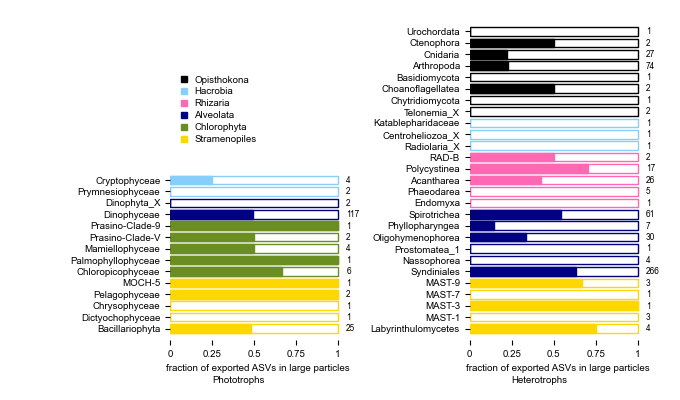

/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_925/3869317127.py:20: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_925/3869317127.py:63: UserWarning:

FixedFormatter should only be used together with FixedLocator



In [73]:
fig=plt.figure(figsize=(6.8,4))
ax2=fig.add_subplot(1,2,1,frameon=False)

for x in np.arange(0,len(St3_small_large_particle_taxa3_counts_het['St3_small'])):
    if x >= len(St3_small_large_particle_taxa3_counts['St3_small']):
        continue
    color1='white'
    if x < 5:
        color2='gold'
    elif x < 10:
        color2='olivedrab'
    elif x < 12:
        color2='navy'
    else:
        color2='lightskyblue'
    ax2.barh(x,(St3_small_large_particle_taxa3_counts['St3_small'].iloc[x]+St3_small_large_particle_taxa3_counts['St3_large'].iloc[x])/(St3_small_large_particle_taxa3_counts['St3_small'].iloc[x]+St3_small_large_particle_taxa3_counts['St3_large'].iloc[x]),color=color1,height=0.75,edgecolor=color2)
    ax2.barh(x,St3_small_large_particle_taxa3_counts['St3_large'].iloc[x]/(St3_small_large_particle_taxa3_counts['St3_small'].iloc[x]+St3_small_large_particle_taxa3_counts['St3_large'].iloc[x]),color=color2,edgecolor=color2,height=0.75)
    ax2.text(1.05,x-0.25,str(int(St3_small_large_particle_taxa3_counts['St3_small'].iloc[x]+St3_small_large_particle_taxa3_counts['St3_large'].iloc[x])),family='Arial',size=6)

ax2.set_xticklabels([0,0.25,0.5,0.75,1],fontsize=7,family='Arial')
ax2.set_xlim([0,1.05])
ax2.set_xticks([0,0.25,0.5,0.75,1])
ax2.set_ylim([-1,len(St3_small_large_particle_taxa3_counts_het['St3_small'])])
ax2.set_yticks(np.arange(0,len(St3_small_large_particle_taxa3_counts['St3_small'])))
ax2.set_yticklabels(St3_small_large_particle_taxa3_counts.index, fontsize=7,family='Arial')
ax2.set_xlabel('fraction of exported ASVs in large particles',fontsize=7,family='Arial')
ax2.text(0.25,-4.75,'Phototrophs',family='Arial',size=7)

custom_lines =[Line2D([0], [0], color='black',marker = 's',lw=0,ms=4),
               Line2D([0], [0], color='lightskyblue',marker = 's',lw=0,ms=4),
               Line2D([0], [0], color='hotpink',marker = 's',lw=0,ms=4),
               Line2D([0], [0], color='navy',marker = 's',lw=0,ms=4),
               Line2D([0], [0], color='olivedrab',marker = 's',lw=0,ms=4),
               Line2D([0], [0], color='gold',marker = 's',lw=0,ms=4)]

ax2.legend(custom_lines,['Opisthokona','Hacrobia','Rhizaria','Alveolata','Chlorophyta','Stramenopiles'],labelspacing=0.3,handletextpad=0.1,frameon=False,loc=[0,0.6],prop={'size':7,'family':'Arial'})




ax3=fig.add_subplot(1,2,2,frameon=False)

for x in np.arange(0,len(St3_small_large_particle_taxa3_counts_het['St3_small'])):
    color1='white'
    if x < 5:
        color2='gold'
    elif x < 11:
        color2='navy'
    elif x < 16:
        color2='hotpink'
    elif x < 19:
        color2='lightskyblue'
    else:
        color2='black'
    ax3.barh(x,(St3_small_large_particle_taxa3_counts_het['St3_small'].iloc[x]+St3_small_large_particle_taxa3_counts_het['St3_large'].iloc[x])/(St3_small_large_particle_taxa3_counts_het['St3_small'].iloc[x]+St3_small_large_particle_taxa3_counts_het['St3_large'].iloc[x]),color=color1,height=0.75,edgecolor=color2)
    ax3.barh(x,St3_small_large_particle_taxa3_counts_het['St3_large'].iloc[x]/(St3_small_large_particle_taxa3_counts_het['St3_small'].iloc[x]+St3_small_large_particle_taxa3_counts_het['St3_large'].iloc[x]),color=color2,edgecolor=color2,height=0.75)
    ax3.text(1.05,x-0.25,str(int(St3_small_large_particle_taxa3_counts_het['St3_small'].iloc[x]+St3_small_large_particle_taxa3_counts_het['St3_large'].iloc[x])),family='Arial',size=6)


ax3.set_ylim([-1,len(St3_small_large_particle_taxa3_counts_het['St3_small'])])
ax3.set_yticks(np.arange(0,len(St3_small_large_particle_taxa3_counts_het['St3_small'])))
ax3.set_yticklabels(St3_small_large_particle_taxa3_counts_het.index, fontsize=7,family='Arial')
ax3.set_xticklabels([0,0.25,0.5,0.75,1],fontsize=7,family='Arial')
ax3.set_xlim([0,1.05])
ax3.set_xticks([0,0.25,0.5,0.75,1])
ax3.set_xlabel('fraction of exported ASVs in large particles',fontsize=7,family='Arial')
ax3.text(0.25,-4.75,'Heterotrophs',family='Arial',size=7)

fig.subplots_adjust(bottom=0.15,top=0.95,left=0.25,right=0.95,wspace=0.7)


In [74]:
print('Fraction of exported phytoplankton ASVs in large particles')
print(St3_small_large_particle_taxa3_counts['St3_large'].sum()/(St3_small_large_particle_taxa3_counts['St3_small'].sum()+St3_small_large_particle_taxa3_counts['St3_large'].sum()))

print('Fraction of exported heterotroph ASVs in large particles')
print(St3_small_large_particle_taxa3_counts_het['St3_large'].sum()/(St3_small_large_particle_taxa3_counts_het['St3_small'].sum()+St3_small_large_particle_taxa3_counts_het['St3_large'].sum()))

Fraction of exported phytoplankton ASVs in large particles
0.4911242603550296
Fraction of exported heterotroph ASVs in large particles
0.4917431192660551


In [75]:
print('fraction of opisthokonts in large particles')
print(St3_small_large_particle_taxa3_counts_het.iloc[20:]['St3_large'].sum()/(St3_small_large_particle_taxa3_counts_het.iloc[20:]['St3_large'].sum()+St3_small_large_particle_taxa3_counts_het.iloc[20:]['St3_small'].sum()))

print('fraction of rhizaria in large particles')
print(St3_small_large_particle_taxa3_counts_het.iloc[11:17]['St3_large'].sum()/(St3_small_large_particle_taxa3_counts_het.iloc[11:17]['St3_large'].sum()+St3_small_large_particle_taxa3_counts_het.iloc[11:17]['St3_small'].sum()))

print('fraction of alveolates in large particles')
print(St3_small_large_particle_taxa3_counts_het.iloc[5:11]['St3_large'].sum()/(St3_small_large_particle_taxa3_counts_het.iloc[5:11]['St3_large'].sum()+St3_small_large_particle_taxa3_counts_het.iloc[5:11]['St3_small'].sum()))

print('fraction of stramenopiles in large particles')
print(St3_small_large_particle_taxa3_counts_het.iloc[:5]['St3_large'].sum()/(St3_small_large_particle_taxa3_counts_het.iloc[:5]['St3_large'].sum()+St3_small_large_particle_taxa3_counts_het.iloc[:5]['St3_small'].sum()))

print('fraction of hacrobia in large particles')
print((St3_small_large_particle_taxa3_counts['St3_large'].loc[['Prymnesiophyceae','Cryptophyceae']].sum()+St3_small_large_particle_taxa3_counts_het.iloc[17:20]['St3_large'].sum())/(St3_small_large_particle_taxa3_counts['St3_large'].loc[['Prymnesiophyceae','Cryptophyceae']].sum()+St3_small_large_particle_taxa3_counts['St3_small'].loc[['Prymnesiophyceae','Cryptophyceae']].sum()+St3_small_large_particle_taxa3_counts_het.iloc[17:20]['St3_large'].sum()+St3_small_large_particle_taxa3_counts_het.iloc[17:20]['St3_small'].sum()))


fraction of opisthokonts in large particles
0.23148148148148148
fraction of rhizaria in large particles
0.46153846153846156
fraction of alveolates in large particles
0.5772357723577236
fraction of stramenopiles in large particles
0.5
fraction of hacrobia in large particles
0.1


In [76]:
print(St3_small_large_particle_taxa3_counts['St3_small'].loc[['Bacillariophyta','Dictyochophyceae','Chrysophyceae','Pelagophyceae','MOCH-5']].sum()/(St3_small_large_particle_taxa3_counts['St3_small'].loc[['Bacillariophyta','Dictyochophyceae','Chrysophyceae','Pelagophyceae','MOCH-5']]+St3_small_large_particle_taxa3_counts['St3_large'].loc[['Bacillariophyta','Dictyochophyceae','Chrysophyceae','Pelagophyceae','MOCH-5']]).sum())
print(St3_small_large_particle_taxa3_counts['St3_small'].loc[['Chloropicophyceae','Palmophyllophyceae','Mamiellophyceae','Prasino-Clade-V','Prasino-Clade-9']].sum()/(St3_small_large_particle_taxa3_counts['St3_small'].loc[['Chloropicophyceae','Palmophyllophyceae','Mamiellophyceae','Prasino-Clade-V','Prasino-Clade-9']]+St3_small_large_particle_taxa3_counts['St3_large'].loc[['Chloropicophyceae','Palmophyllophyceae','Mamiellophyceae','Prasino-Clade-V','Prasino-Clade-9']]).sum())
print(St3_small_large_particle_taxa3_counts['St3_small'].loc[['Dinophyceae','Dinophyta_X']].sum()/(St3_small_large_particle_taxa3_counts['St3_small'].loc[['Dinophyceae','Dinophyta_X']]+St3_small_large_particle_taxa3_counts['St3_large'].loc[['Dinophyceae','Dinophyta_X']]).sum())
print(St3_small_large_particle_taxa3_counts['St3_small'].loc[['Prymnesiophyceae','Cryptophyceae']].sum()/(St3_small_large_particle_taxa3_counts['St3_small'].loc[['Prymnesiophyceae','Cryptophyceae']]+St3_small_large_particle_taxa3_counts['St3_large'].loc[['Prymnesiophyceae','Cryptophyceae']]).sum())


0.5
0.35714285714285715
0.5126050420168067
0.8333333333333334


## Prymnesiophytes, Dinophyta_x, Chrysophytes and Dictyophytes are all only found in small particles.

## Chlorophytes are mostly exported in large particles

## Among the two groups with diverse ASVs, diatoms and dinoflagellates, each have about half in the small and half in the large particles.

## Which diatoms are exported in small versus large?

In [77]:

St3_small_particle_diatoms=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[St3_small_particle_ASVs][Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[St3_small_particle_ASVs].taxa3=='Bacillariophyta'].taxa7
St3_large_particle_diatoms=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[St3_large_particle_ASVs][Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[St3_large_particle_ASVs].taxa3=='Bacillariophyta'].taxa7

St3_diatoms_large_and_small_species=[]
St3_diatoms_large_species=[]
St3_diatoms_small_only_species=[]

for x in St3_small_particle_diatoms.unique():
    if x in St3_large_particle_diatoms.unique():
        St3_diatoms_large_and_small_species.append(x)
    else:
        St3_diatoms_small_only_species.append(x)
for x in St3_large_particle_diatoms.unique():
    if x in St3_small_particle_diatoms.unique():
        if x not in St3_diatoms_large_and_small_species:
            St3_diatoms_large_and_small_species.append(x)
        else: continue
    else:
        St3_diatoms_large_species.append(x)
        

In [78]:
print('St3 diatoms exported in both large and small (different ASVs in each): ' + str(St3_diatoms_large_and_small_species))
print()
print('St3 diatoms exported in large particles but ASVs also found in bulk: ' + str(St3_diatoms_large_species))
print()
print('St3 diatoms exported only in small particles (ASVs found in bulk but not particles): ' + str(St3_diatoms_small_only_species))

St3 diatoms exported in both large and small (different ASVs in each): ['Polar-centric-Mediophyceae', 'Chaetoceros', 'Pseudo-nitzschia', 'Thalassiosira_sp.']

St3 diatoms exported in large particles but ASVs also found in bulk: ['Cylindrotheca_closterium', 'Minidiscus', 'Guinardia_delicatula', 'Pseudo-nitzschia_sp.', 'Navicula_lanceolata', 'Polar-centric-Mediophyceae_X_sp.', 'Minidiscus_trioculatus']

St3 diatoms exported only in small particles (ASVs found in bulk but not particles): ['Bacillariophyta_X', 'Raphid-pennate', 'Rhizosolenia', 'Bacteriastrum_parallelum', 'Proboscia_alata', 'Coscinodiscus_radiatus', 'Thalassiosira']


## Diatoms exported in small-only particles are very large species, so may have sunk by themselves or essentially made a very small particle sink faster

## Determine variability in subsamples- WW3 vs WW4 data to constrain sampling stochastisity

In [79]:
WW3_bulk=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[['T4','T5']].sum(axis=1)
WW4_bulk=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[['T7','T8']].sum(axis=1)
Station_3_metadata=TS_metadata[TS_metadata.Station==3]
Station_3_metadata_particles=Station_3_metadata[Station_3_metadata.ParticleType!='bulk_fresh']
Station_3_metadata_particles=Station_3_metadata_particles[Station_3_metadata_particles.ParticleType!='bulk_RNAlater']
Station_3_metadata_particles=Station_3_metadata_particles[Station_3_metadata_particles.ParticleType!='plankton']
WW3_particle_IDs=Station_3_metadata_particles[Station_3_metadata_particles.Trap=='WW3'].Sample
WW4_particle_IDs=Station_3_metadata_particles[Station_3_metadata_particles.Trap=='WW4'].Sample
WW3_particles=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(WW3_particle_IDs)].sum(axis=1)
WW4_particles=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA[list(WW4_particle_IDs)].sum(axis=1)


WW3_small_particle_ASVs = []
WW3_large_particle_ASVs = []
WW3_large_only_particles_ASVs=[]
for ASV in WW3_particles.index:
    if WW3_bulk.loc[ASV] > 0:
        if WW3_particles.loc[ASV] == 0:
            WW3_small_particle_ASVs.append(ASV)
        else:
            WW3_large_particle_ASVs.append(ASV)
    elif WW3_particles.loc[ASV] > 0:
        WW3_large_only_particles_ASVs.append(ASV)
        
        
WW3_small_particles_taxa3_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[WW3_small_particle_ASVs].groupby(Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[WW3_small_particle_ASVs].taxa3).count().taxa3
WW3_large_particles_taxa3_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[WW3_large_particle_ASVs].groupby(Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[WW3_large_particle_ASVs].taxa3).count().taxa3

WW4_small_particle_ASVs = []
WW4_large_particle_ASVs = []
WW4_large_only_particles_ASVs=[]
for ASV in WW4_particles.index:
    if WW4_bulk.loc[ASV] > 0:
        if WW4_particles.loc[ASV] == 0:
            WW4_small_particle_ASVs.append(ASV)
        else:
            WW4_large_particle_ASVs.append(ASV)
    elif WW4_particles.loc[ASV] > 0:
        WW4_large_only_particles_ASVs.append(ASV)
        
WW4_small_particles_taxa3_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[WW4_small_particle_ASVs].groupby(Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[WW4_small_particle_ASVs].taxa3).count().taxa3
WW4_large_particles_taxa3_counts=Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[WW4_large_particle_ASVs].groupby(Photosynthetic_Traps_surface_feature_table_wIDs_allDATA.loc[WW4_large_particle_ASVs].taxa3).count().taxa3



WW3_small_large_particle_taxa3_counts=pd.DataFrame(WW3_small_particles_taxa3_counts).merge(pd.DataFrame(WW3_large_particles_taxa3_counts),left_index=True,right_index=True,how='outer')
WW3_small_large_particle_taxa3_counts=WW3_small_large_particle_taxa3_counts.rename(columns={'taxa3_x':'WW3_small','taxa3_y':'WW3_large'})
WW3and4_small_large_particle_taxa3_counts=WW3_small_large_particle_taxa3_counts.merge(pd.DataFrame(WW4_small_particles_taxa3_counts),left_index=True, right_index=True,how='outer')
WW3and4_small_large_particle_taxa3_counts=WW3and4_small_large_particle_taxa3_counts.merge(pd.DataFrame(WW4_large_particles_taxa3_counts),left_index=True, right_index=True,how='outer')
WW3and4_small_large_particle_taxa3_counts=WW3and4_small_large_particle_taxa3_counts.rename(columns={'taxa3_x':'WW4_small','taxa3_y':'WW4_large'})
WW3and4_small_large_particle_taxa3_counts=WW3and4_small_large_particle_taxa3_counts.fillna(0)


In [80]:
WW3and4_small_large_particle_taxa3_counts=WW3and4_small_large_particle_taxa3_counts.reindex(St3_small_large_particle_taxa3_counts.index)


In [81]:
WW3_bulk_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA[['T4','T5']].sum(axis=1)
WW4_bulk_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA[['T7','T8']].sum(axis=1)
WW3_particles_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA[list(WW3_particle_IDs)].sum(axis=1)
WW4_particles_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA[list(WW4_particle_IDs)].sum(axis=1)


WW3_small_particle_ASVs_het = []
WW3_large_particle_ASVs_het = []
WW3_large_only_particles_ASVs_het=[]
for ASV in WW3_particles_het.index:
    if WW3_bulk_het.loc[ASV] > 0:
        if WW3_particles_het.loc[ASV] == 0:
            WW3_small_particle_ASVs_het.append(ASV)
        else:
            WW3_large_particle_ASVs_het.append(ASV)
    elif WW3_particles_het.loc[ASV] > 0:
        WW3_large_only_particles_ASVs_het.append(ASV)
        
        
WW3_small_particles_taxa3_counts_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.loc[WW3_small_particle_ASVs_het].groupby(Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.loc[WW3_small_particle_ASVs_het].taxa3).count().taxa3
WW3_large_particles_taxa3_counts_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.loc[WW3_large_particle_ASVs_het].groupby(Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.loc[WW3_large_particle_ASVs_het].taxa3).count().taxa3

WW4_small_particle_ASVs_het = []
WW4_large_particle_ASVs_het = []
WW4_large_only_particles_ASVs_het=[]
for ASV in WW4_particles_het.index:
    if WW4_bulk_het.loc[ASV] > 0:
        if WW4_particles_het.loc[ASV] == 0:
            WW4_small_particle_ASVs_het.append(ASV)
        else:
            WW4_large_particle_ASVs_het.append(ASV)
    elif WW4_particles_het.loc[ASV] > 0:
        WW4_large_only_particles_ASVs_het.append(ASV)
        
WW4_small_particles_taxa3_counts_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.loc[WW4_small_particle_ASVs_het].groupby(Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.loc[WW4_small_particle_ASVs_het].taxa3).count().taxa3
WW4_large_particles_taxa3_counts_het=Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.loc[WW4_large_particle_ASVs_het].groupby(Heterotrophic_Traps_surface_feature_table_wIDs_allDATA.loc[WW4_large_particle_ASVs_het].taxa3).count().taxa3



WW3_small_large_particle_taxa3_counts_het=pd.DataFrame(WW3_small_particles_taxa3_counts_het).merge(pd.DataFrame(WW3_large_particles_taxa3_counts_het),left_index=True,right_index=True,how='outer')
WW3_small_large_particle_taxa3_counts_het=WW3_small_large_particle_taxa3_counts_het.rename(columns={'taxa3_x':'WW3_small','taxa3_y':'WW3_large'})
WW3and4_small_large_particle_taxa3_counts_het=WW3_small_large_particle_taxa3_counts_het.merge(pd.DataFrame(WW4_small_particles_taxa3_counts_het),left_index=True, right_index=True,how='outer')
WW3and4_small_large_particle_taxa3_counts_het=WW3and4_small_large_particle_taxa3_counts_het.merge(pd.DataFrame(WW4_large_particles_taxa3_counts_het),left_index=True, right_index=True,how='outer')
WW3and4_small_large_particle_taxa3_counts_het=WW3and4_small_large_particle_taxa3_counts_het.rename(columns={'taxa3_x':'WW4_small','taxa3_y':'WW4_large'})
WW3and4_small_large_particle_taxa3_counts_het=WW3and4_small_large_particle_taxa3_counts_het.fillna(0)



In [82]:
WW3and4_small_large_particle_taxa3_counts_het=WW3and4_small_large_particle_taxa3_counts_het.reindex(St3_small_large_particle_taxa3_counts_het.index)
WW3WW4_all=WW3and4_small_large_particle_taxa3_counts.append(WW3and4_small_large_particle_taxa3_counts_het)
St3_all=St3_small_large_particle_taxa3_counts.append(St3_small_large_particle_taxa3_counts_het)

WW3_bulk_ASVcount=WW3WW4_all['WW3_small']+WW3WW4_all['WW3_large']
WW4_bulk_ASVcount=WW3WW4_all['WW4_small']+WW3WW4_all['WW4_large']

WW3_fractionLarge=WW3WW4_all['WW3_large']/(WW3WW4_all['WW3_small']+WW3WW4_all['WW3_large'])
WW3_fractionLarge=WW3_fractionLarge.fillna(0)
WW4_fractionLarge=WW3WW4_all['WW4_large']/(WW3WW4_all['WW4_small']+WW3WW4_all['WW4_large'])
WW4_fractionLarge=WW4_fractionLarge.fillna(0)



## Plot all analysisis on WW3 and WW4 to show trap-to-trap variability 

<IPython.core.display.Javascript object>


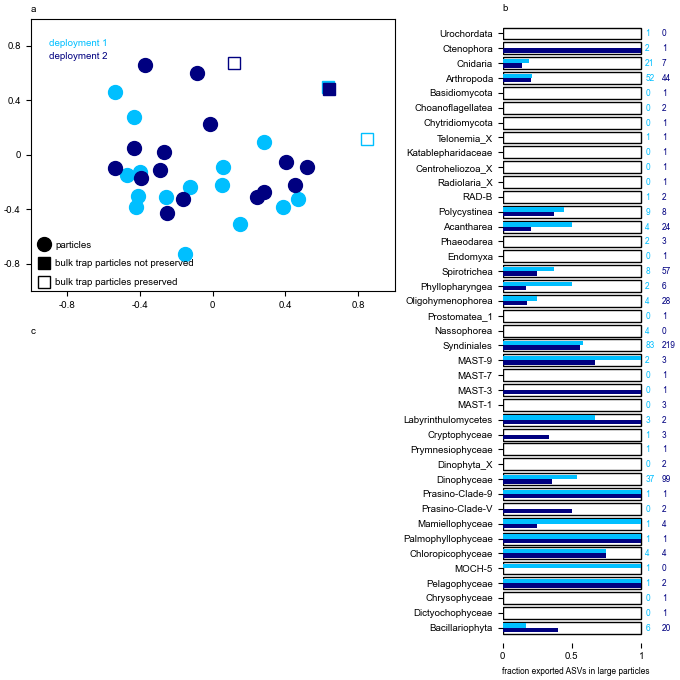

Text(0, 1.1, 'c')

In [83]:
fig2 = plt.figure(figsize=(6.8,6.8),constrained_layout=True)
gs = fig2.add_gridspec(4, 7)
ax1 = fig2.add_subplot(gs[0:2,0:5])
ax1.plot(St3_trap_surface_MDS_df[0][0],St3_trap_surface_MDS_df[1][0],marker='s',ms=8,lw=0,color='deepskyblue',mec='deepskyblue',label='WW3 bulk live')
ax1.plot(St3_trap_surface_MDS_df[0][1],St3_trap_surface_MDS_df[1][1],marker='s',ms=8,lw=0,color='white',mec='deepskyblue',label='WW3 bulk preserved')
ax1.plot(St3_trap_surface_MDS_df[0][2],St3_trap_surface_MDS_df[1][2],marker='s',ms=8,lw=0,color='navy',mec='navy',label='WW4 bulk live')
ax1.plot(St3_trap_surface_MDS_df[0][3],St3_trap_surface_MDS_df[1][3],marker='s',ms=8,lw=0,color='white',mec='navy',label='WW4 bulk preserved')


ax1.plot(St3_trap_surface_MDS_df[0][4:19],St3_trap_surface_MDS_df[1][4:19],marker='o',ms=10,lw=0,color='deepskyblue',mec='deepskyblue',label='WW3 particles t=0')
ax1.plot(St3_trap_surface_MDS_df[0][19:34],St3_trap_surface_MDS_df[1][19:34],marker='o',ms=10,lw=0,color='navy',mec='navy',label='WW4 particles t=0')

ax1.set_xlim(-1,1)
ax1.set_xticks([-0.8,-0.4,0,0.4,0.8])
ax1.set_xticklabels([-0.8,-0.4,0,0.4,0.8],family='Arial',size=7)
ax1.set_ylim(-1,1)
ax1.set_yticks([-0.8,-0.4,0,0.4,0.8])
ax1.set_yticklabels([-0.8,-0.4,0,0.4,0.8],family='Arial',size=7)

custom_lines = [Line2D([0], [0], color='black',mec='black',marker = 'o',lw=0,ms=10),
                Line2D([0], [0], color='black',mec='black',marker = 's',lw=0,ms=8),
                Line2D([0], [0], color='white',mec='black',marker = 's',lw=0,ms=8)]

ax1.legend(custom_lines,['particles','bulk trap particles not preserved','bulk trap particles preserved'],title_fontsize=7,labelspacing=1,handletextpad=0.1,frameon=False,loc=[0,0],prop={'family':'Arial','size':7})
ax1.text(-0.9,0.8,'deployment 1',family='Arial',size=7,color='deepskyblue')
ax1.text(-0.9,0.7,'deployment 2',family='Arial',size=7,color='navy')
ax1.text(-1,1.05,'a',family='Arial',size=7)


ax2 = fig2.add_subplot(gs[0:,5:],frameon=False)

ax2.barh(np.arange(0,len(WW3_fractionLarge)),np.repeat(1,len(WW3_fractionLarge)),color='white',edgecolor='black',height=0.8)
ax2.barh(np.arange(-0.15,len(WW4_fractionLarge)-0.15),WW4_fractionLarge,color='navy',height=0.3)
ax2.barh(np.arange(0.15,len(WW3_fractionLarge)+0.15),WW3_fractionLarge,color='deepskyblue',height=0.3)
ax2.set_yticks(list(np.arange(0,len(WW3_fractionLarge))))
ax2.set_yticklabels(list(WW3WW4_all.index),family='Arial',size=7)
ax2.set_ylim(-1,len(WW3WW4_all.index))
ax2.set_xticks([0,0.5,1])
ax2.set_xticklabels([0,0.5,1],family='Arial',size=7)
ax2.set_xlabel('fraction exported ASVs in large particles',family='Arial',size=6)
ax2.text(0,41.5,'b',family='Arial',size=7)

count=0
step=0.2
for x in WW3_bulk_ASVcount:
    ax2.text(1.03,count-step,str(int(x)),family='Arial',size=6,color='deepskyblue')
    count=count+1
count=0
step=0.2
for x in WW4_bulk_ASVcount:
    ax2.text(1.15,count-step,str(int(x)),family='Arial',size=6,color='navy')
    count=count+1
        

ax2 = fig2.add_subplot(gs[2:,0:5])
ax2.axis('off')
ax2.text(0,1.1,'c',family='Arial',size=7)

## Create the components needed for a synthesis figures

In [84]:
functional_grouping=['diatoms',
                     'other ochrophytes','other ochrophytes','other ochrophytes','other ochrophytes','other ochrophytes','other ochrophytes','other ochrophytes','other ochrophytes','other ochrophytes','other ochrophytes',
                    'chlorophytes','chlorophytes','chlorophytes','chlorophytes','chlorophytes','chlorophytes',
                    'dinoflagellates','dinoflagellates','dinoflagellates',
                    'hacrobia','hacrobia','hacrobia','hacrobia','hacrobia','hacrobia','rhizaria']
organisms=np.unique(np.array(functional_grouping))
surface_diversity=St2and3_Preferential_surface_export['surface_only_y'].groupby(functional_grouping).sum()+St2and3_Preferential_surface_export['shared_y'].groupby(functional_grouping).sum()
fraction_exported=St2and3_Preferential_surface_export['shared_y'].groupby(functional_grouping).sum()/surface_diversity

functional_grouping2=['diatoms','other ochrophytes','other ochrophytes','other ochrophytes','other ochrophytes',
                      'chlorophytes','chlorophytes','chlorophytes','chlorophytes','chlorophytes',
                     'dinoflagellates','dinoflagellates','hacrobia','hacrobia']
exported_diversity=St3_small_large_particle_taxa3_counts.groupby(functional_grouping2).sum()
fraction_small=exported_diversity['St3_small']/(exported_diversity['St3_small']+exported_diversity['St3_large'])
fraction_large=exported_diversity['St3_large']/(exported_diversity['St3_small']+exported_diversity['St3_large'])
fraction_small2=fraction_small*fraction_exported
fraction_large2=fraction_large*fraction_exported
Sankey_df=pd.DataFrame()
Sankey_df['surface_diversity']=surface_diversity
Sankey_df=Sankey_df.drop('rhizaria')
Sankey_df['fraction_small']=fraction_small2
Sankey_df['fraction_large']=fraction_large2
Sankey_df['fraction_not_exported']=1-fraction_exported

Sankey_df


surface_diversity  fraction_small  fraction_large  \
chlorophytes                    22.0        0.113636        0.204545   
diatoms                         49.0        0.159184        0.146939   
dinoflagellates                258.0        0.152987        0.145463   
hacrobia                        51.0        0.130719        0.026144   
other ochrophytes               62.0        0.064516        0.096774   

                   fraction_not_exported  
chlorophytes                    0.681818  
diatoms                         0.693878  
dinoflagellates                 0.701550  
hacrobia                        0.843137  
other ochrophytes               0.838710

In [85]:
C_data=pd.read_csv('All_Falkor_flux_data.csv')

C_data_WW3=C_data[C_data.Trap=='FK170124_WW3_obl']
C_data_WW3_small=C_data_WW3[C_data_WW3.bin_mids<400]
C_data_WW3_large=C_data_WW3[C_data_WW3.bin_mids>400]

C_data_WW4=C_data[C_data.Trap=='FK170124_WW4_obl']
C_data_WW4_small=C_data_WW4[C_data_WW4.bin_mids<400]
C_data_WW4_large=C_data_WW4[C_data_WW4.bin_mids>400]

C_data_NBST3=C_data[C_data.Trap=='FK170124_NBST3_obl']
C_data_NBST3_small=C_data_NBST3[C_data_NBST3.bin_mids<400]
C_data_NBST3_large=C_data_NBST3[C_data_NBST3.bin_mids>400]

C_data_WW3_small_Cflux=C_data_WW3_small[['long_fp_Cflux', 'short_fp_Cflux', 'salp_fp_Cflux', 'mini_fp_Cflux', 'phytoplankton_Cflux', 'rhizaria_Cflux', 'agg_Cflux', 'dense_Cflux', 'large_fp_Cflux']].sum()
C_data_WW3_large_Cflux=C_data_WW3_large[['long_fp_Cflux', 'short_fp_Cflux', 'salp_fp_Cflux', 'mini_fp_Cflux', 'phytoplankton_Cflux', 'rhizaria_Cflux', 'agg_Cflux', 'dense_Cflux', 'large_fp_Cflux']].sum()
C_data_WW4_small_Cflux=C_data_WW4_small[['long_fp_Cflux', 'short_fp_Cflux', 'salp_fp_Cflux', 'mini_fp_Cflux', 'phytoplankton_Cflux', 'rhizaria_Cflux', 'agg_Cflux', 'dense_Cflux', 'large_fp_Cflux']].sum()
C_data_WW4_large_Cflux=C_data_WW4_large[['long_fp_Cflux', 'short_fp_Cflux', 'salp_fp_Cflux', 'mini_fp_Cflux', 'phytoplankton_Cflux', 'rhizaria_Cflux', 'agg_Cflux', 'dense_Cflux', 'large_fp_Cflux']].sum()
C_data_NBST3_small_Cflux=C_data_NBST3_small[['long_fp_Cflux', 'short_fp_Cflux', 'salp_fp_Cflux', 'mini_fp_Cflux', 'phytoplankton_Cflux', 'rhizaria_Cflux', 'agg_Cflux', 'dense_Cflux', 'large_fp_Cflux']].sum()
C_data_NBST3_large_Cflux=C_data_NBST3_large[['long_fp_Cflux', 'short_fp_Cflux', 'salp_fp_Cflux', 'mini_fp_Cflux', 'phytoplankton_Cflux', 'rhizaria_Cflux', 'agg_Cflux', 'dense_Cflux', 'large_fp_Cflux']].sum()

Station3_Cfluxes_small=pd.DataFrame()
Station3_Cfluxes_small['WW3']=C_data_WW3_small_Cflux
Station3_Cfluxes_small['WW4']=C_data_WW4_small_Cflux
Station3_Cfluxes_small['NBST3']=C_data_NBST3_small_Cflux

Station3_Cfluxes_large=pd.DataFrame()
Station3_Cfluxes_large['WW3']=C_data_WW3_large_Cflux
Station3_Cfluxes_large['WW4']=C_data_WW4_large_Cflux
Station3_Cfluxes_large['NBST3']=C_data_NBST3_large_Cflux

St3_mean_large_Cfluxes=Station3_Cfluxes_large.mean(axis=1)
St3_mean_small_Cfluxes=Station3_Cfluxes_small.mean(axis=1)


In [86]:
Sankey_df=Sankey_df.reindex(['hacrobia','dinoflagellates','diatoms','other ochrophytes','chlorophytes'])

lo=go.Layout(autosize=False,width=2064,height=1200)
fig1=go.Figure(layout=lo)
fig = make_subplots(
    cols = 10, rows = 3,
    row_heights= [0.25,0.25,0.5],
    vertical_spacing=0,
    horizontal_spacing=0.05,
    specs = [[{'type':'treemap','colspan':2},{'type':'treemap'},
              {'type':'treemap','colspan':2},{'type':'treemap'},
              {'type':'treemap','colspan':2},{'type':'treemap'},
              {'type':'treemap','colspan':2},{'type':'treemap'},
              {'type':'treemap','colspan':2},{'type':'treemap'}],
             [{'type':'sankey','colspan':10},{'type':'sankey'},{'type':'sankey'},{'type':'sankey'},{'type':'sankey'},{'type':'sankey'},{'type':'sankey'},{'type':'sankey'},{'type':'sankey'},{'type':'sankey'}],
             
             [{'type': 'treemap','colspan':4},{'type': 'treemap'},{'type': 'treemap'},{'type': 'treemap'},{'type': 'treemap'},
              {'type': 'treemap'},{'type': 'treemap','colspan':4},{'type': 'treemap'},{'type': 'treemap'},{'type': 'treemap'}]],
            figure=fig1)

values = list(St3_exported_relative_reads_chlorophytes)+list(St3_surface_only_relative_reads_chlorophytes)
labels = list(St3_exported_relative_reads_chlorophytes.index)+list(St3_surface_only_relative_reads_chlorophytes.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_chlorophytes)))+list(np.repeat('',len(St3_surface_only_relative_reads_chlorophytes))),
    marker=dict(colors=list(np.repeat('olivedrab',len(St3_exported_relative_reads_chlorophytes)))+list(np.repeat('white',len(St3_surface_only_relative_reads_chlorophytes))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('olivedrab',len(St3_exported_relative_reads_chlorophytes)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_chlorophytes))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='olivedrab',family='Arial')),
    row=1,col=9)

values = list(St3_exported_relative_reads_ochrophytes)+list(St3_surface_only_relative_reads_ochrophytes)
labels = list(St3_exported_relative_reads_ochrophytes.index)+list(St3_surface_only_relative_reads_ochrophytes.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_ochrophytes)))+list(np.repeat('',len(St3_surface_only_relative_reads_ochrophytes))),
    marker=dict(colors=list(np.repeat('gold',len(St3_exported_relative_reads_ochrophytes)))+list(np.repeat('white',len(St3_surface_only_relative_reads_ochrophytes))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('gold',len(St3_exported_relative_reads_ochrophytes)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_ochrophytes))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='gold',family='Arial')),
    row=1,col=7)

values = list(St3_exported_relative_reads_diatoms)+list(St3_surface_only_relative_reads_diatoms)
labels = list(St3_exported_relative_reads_diatoms.index)+list(St3_surface_only_relative_reads_diatoms.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_diatoms)))+list(np.repeat('',len(St3_surface_only_relative_reads_diatoms))),
    marker=dict(colors=list(np.repeat('orange',len(St3_exported_relative_reads_diatoms)))+list(np.repeat('white',len(St3_surface_only_relative_reads_diatoms))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('orange',len(St3_exported_relative_reads_diatoms)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_diatoms))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='orange',family='Arial')),
    row=1,col=5)


values = list(St3_exported_relative_reads_dinoflagellates)+list(St3_surface_only_relative_reads_dinoflagellates)
labels = list(St3_exported_relative_reads_dinoflagellates.index)+list(St3_surface_only_relative_reads_dinoflagellates.index)


fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_dinoflagellates)))+list(np.repeat('',len(St3_surface_only_relative_reads_dinoflagellates))),
    marker=dict(colors=list(np.repeat('navy',len(St3_exported_relative_reads_dinoflagellates)))+list(np.repeat('white',len(St3_surface_only_relative_reads_dinoflagellates))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('navy',len(St3_exported_relative_reads_dinoflagellates)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_dinoflagellates))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='navy',family='Arial')),
    row=1,col=3)

values = list(St3_exported_relative_reads_hacrobia)+list(St3_surface_only_relative_reads_hacrobia)
labels = list(St3_exported_relative_reads_hacrobia.index)+list(St3_surface_only_relative_reads_hacrobia.index)
labels2=list(np.repeat(' ', len(list(St3_exported_relative_reads_hacrobia.index)+list(St3_surface_only_relative_reads_hacrobia.index))))

fig.add_trace(go.Treemap(
    values=values,
    labels=labels,
    parents=list(np.repeat('',len(St3_exported_relative_reads_hacrobia)))+list(np.repeat('',len(St3_surface_only_relative_reads_hacrobias))),
    marker=dict(colors=list(np.repeat('lightskyblue',len(St3_exported_relative_reads_hacrobia)))+list(np.repeat('white',len(St3_surface_only_relative_reads_hacrobia))),
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color=list(np.repeat('white',len(St3_exported_relative_reads_hacrobia)))+list(np.repeat('lightgrey',len(St3_surface_only_relative_reads_hacrobia))))),
    tiling=dict(pad=8),
    textinfo='none',
    textfont=dict(size=7,color='lightskyblue',family='Arial')),
    row=1,col=1)


source = list(np.arange(0,len(Sankey_df.index)))+list(np.arange(0,len(Sankey_df.index)))
target = list(np.repeat(len(Sankey_df.index),len(Sankey_df.index)))+list(np.repeat(len(Sankey_df.index)+1,len(Sankey_df.index)))
value=list(np.array(Sankey_df['fraction_small'])*np.array([St3_exported_relative_reads_hacrobia.sum(),St3_exported_relative_reads_dinoflagellates.sum(),St3_exported_relative_reads_diatoms.sum(),St3_exported_relative_reads_ochrophytes.sum(),St3_exported_relative_reads_chlorophytes.sum()]))+list(np.array(Sankey_df['fraction_large'])*np.array([St3_exported_relative_reads_hacrobia.sum(),St3_exported_relative_reads_dinoflagellates.sum(),St3_exported_relative_reads_diatoms.sum(),St3_exported_relative_reads_ochrophytes.sum(),St3_exported_relative_reads_chlorophytes.sum()]))

link = dict(source = source, target = target, value = value)

node = dict(pad = 15,
            thickness = 5,
            line = dict(color='white', width = 1),
#            label = list(Sankey_df.index)+['','','not exported'],
            color = ['black','black','black','black','black','white','white'],
            y=[0,1,2,2.2,2.3,0.2,1.5],
            x=[0,0,0,0,0,0.13,0.13])

fig.add_trace(go.Sankey(link = link,node=node,orientation='v',arrangement='snap',textfont=dict(family="Arial",size=10)),col=1,row=2)

values = list(St3_mean_small_Cfluxes)
labels = ['long pellet','short pellet','salp pellet','mini pellet','phytoplankton','rhizaria','aggregate','dense detritus','large-loose pellet']

fig.add_trace(go.Treemap(
    labels = labels,
    values=values,
    parents=['','','','','','','','',''],
    marker=dict(colors=['white','white','white','white','white','white','white','white','white'],
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color='black')),
    tiling=dict(pad=8)),
    row=3,col=1)

values = list(St3_mean_large_Cfluxes)
labels = ['long pellet','short pellet','salp pellet','mini pellet','phytoplankton','rhizaria','aggregate','dense detritus','large-loose pellet']
lo=go.Layout(autosize=False,width=500,height=450)

fig.add_trace(go.Treemap(
    labels = labels,
    values=values,
    parents=['','','','','','','','',''],
    marker=dict(colors=['white','white','white','white','white','white','white','white','white'],
                pad=dict(t=5,b=5,l=5,r=5),
                line=dict(width=5,color='black')),
    tiling=dict(pad=8),
    textfont=dict(size=7,family='Arial')),
    row=3,col=7)
fig.update_layout(uniformtext=dict(minsize=100, mode='hide'))
#fig.add_annotation(x=0.9,y=-0.05,text='1.65 mmol C m-2 d-1',showarrow=False)
#fig.add_annotation(x=0.15,y=-0.05,text='1.36 mmol C m-2 d-1',showarrow=False)
#fig.add_annotation(x=-0.1,y=0.95,text='taxonomic diversity',showarrow=False,textangle=270,font=dict(size=15,color='black',family='Arial'))
#fig.add_annotation(x=-0.1,y=0.3,text='carbon export',showarrow=False,textangle=270,font=dict(size=15,color='black',family='Arial'))

fig.show()

## Analyze rarifaction curves of the samples to see how changing depth of sequencing would affect results 

In [87]:
Traps_surface_taxonomy.index=Traps_surface_taxonomy['Feature ID']

In [88]:
phyto_ASV_rarifaction_data_curves=pd.DataFrame()
phyto_taxa7_rarifaction_data_curves=pd.DataFrame()
ASV_rarifaction_data_curves=pd.DataFrame()
taxa7_rarifaction_data_curves=pd.DataFrame()

for sample in list(Traps_surface_feature_table.drop(['OTU_ID'],axis=1)):
    sample_data=Traps_surface_feature_table[Traps_surface_feature_table[sample]>0]
    simulated_data=[]
    for b in sample_data.index:
        for y in np.arange(0,sample_data[sample].loc[b]):
            simulated_data.append(sample_data['OTU_ID'].loc[b])
    simulated_data=np.array(simulated_data)

    number_sampled=[]
    ASV_richness=[]
    taxa7_richness=[]
    phyto_ASV_richness=[]
    phyto_taxa7_richness=[]

    random_ASV_selection=[]
    for x in np.arange(0,40):
        for t in np.arange(0,500):
            random_ASV_selection.append(np.random.randint(0,len(simulated_data)))
        rows=Traps_surface_taxonomy.loc[simulated_data[random_ASV_selection]]
        phytoplankton_features=np.intersect1d(np.array(rows.index),np.array(Photosynthetic_Traps_surface_feature_table_wIDs_allDATA['Feature ID']))
        phytoplankton_rows=Traps_surface_taxonomy.loc[np.array(phytoplankton_features)]
        number_sampled.append(len(random_ASV_selection))
        ASV_richness.append(len(rows['Feature ID'].unique()))
        taxa7_richness.append(len(rows.taxa7.unique()))
        phyto_ASV_richness.append(len(phytoplankton_rows['Feature ID'].unique()))
        phyto_taxa7_richness.append(len(phytoplankton_rows.taxa7.unique()))
    phyto_ASV_rarifaction_data_curves[sample]=phyto_ASV_richness
    phyto_taxa7_rarifaction_data_curves[sample]=phyto_taxa7_richness
    ASV_rarifaction_data_curves[sample]=ASV_richness
    taxa7_rarifaction_data_curves[sample]=taxa7_richness

/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_925/796384124.py:32: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_925/796384124.py:33: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`

/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_925/796384124.py:34: PerformanceWarning:

DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat

<IPython.core.display.Javascript object>


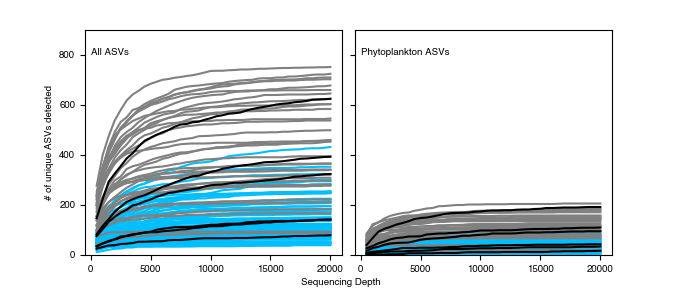

In [89]:
plt.figure(figsize=[6.8,3])
plt.subplot(1,2,1)
for x in ['P1', 'P10', 'P12', 'P13', 'P15', 'P16', 'P18', 'P2', 'P23', 'P24', 'P25', 'P27', 'P28', 'P29', 'P3', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P4', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P5', 'P50', 'P51', 'P52', 'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P59', 'P6', 'P60', 'P61', 'P62', 'P63', 'P64', 'P65', 'P66', 'P67', 'P68', 'P69', 'P7', 'P70', 'P71', 'P72', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78', 'P79', 'P8', 'P80', 'P81', 'P82', 'P83']:
    plt.plot(number_sampled,ASV_rarifaction_data_curves[x],color='deepskyblue')
for x in ['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '4', '5', '6', '7', '8','9']:
    plt.plot(number_sampled,ASV_rarifaction_data_curves[x],color='grey')
for x in ['T1','T2','T4','T5','T7','T8']:
    plt.plot(number_sampled,ASV_rarifaction_data_curves[x],color='black')
plt.ylim(0,900)
plt.yticks(family='Helvetica',fontsize=7)
plt.text(0,800,'All ASVs',family='Helvetica',fontsize=7)
plt.xticks(family='Helvetica',fontsize=7)
plt.ylabel('# of unique ASVs detected', family='Helvetica',fontsize=7)
plt.subplot(1,2,2)
for x in ['P1', 'P10', 'P12', 'P13', 'P15', 'P16', 'P18', 'P2', 'P23', 'P24', 'P25', 'P27', 'P28', 'P29', 'P3', 'P30', 'P31', 'P32', 'P33', 'P34', 'P35', 'P36', 'P37', 'P38', 'P39', 'P4', 'P40', 'P41', 'P42', 'P43', 'P44', 'P45', 'P46', 'P47', 'P48', 'P49', 'P5', 'P50', 'P51', 'P52', 'P53', 'P54', 'P55', 'P56', 'P57', 'P58', 'P59', 'P6', 'P60', 'P61', 'P62', 'P63', 'P64', 'P65', 'P66', 'P67', 'P68', 'P69', 'P7', 'P70', 'P71', 'P72', 'P73', 'P74', 'P75', 'P76', 'P77', 'P78', 'P79', 'P8', 'P80', 'P81', 'P82', 'P83']:
    plt.plot(number_sampled,phyto_ASV_rarifaction_data_curves[x],color='deepskyblue')
for x in ['1', '10', '11', '12', '13', '14', '15', '16', '17', '2', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '4', '5', '6', '7', '8','9']:
    plt.plot(number_sampled,phyto_ASV_rarifaction_data_curves[x],color='grey')
for x in ['T1','T2','T4','T5','T7','T8']:
    plt.plot(number_sampled,phyto_ASV_rarifaction_data_curves[x],color='black')
plt.ylim(0,900)
plt.text(0,800,'Phytoplankton ASVs',size=7,family='Helvetica')  
plt.yticks([0,200,400,600,800],['','','','',''])
plt.xticks(family='Helvetica',fontsize=7)
plt.text(-5000,-120,'Sequencing Depth',family='Helvetica',size=7)
plt.subplots_adjust(wspace=0.05,bottom=0.15,top=0.9)

In [150]:
CTD_data=pd.read_csv('CTD_profiles_20220112.csv')


<IPython.core.display.Javascript object>


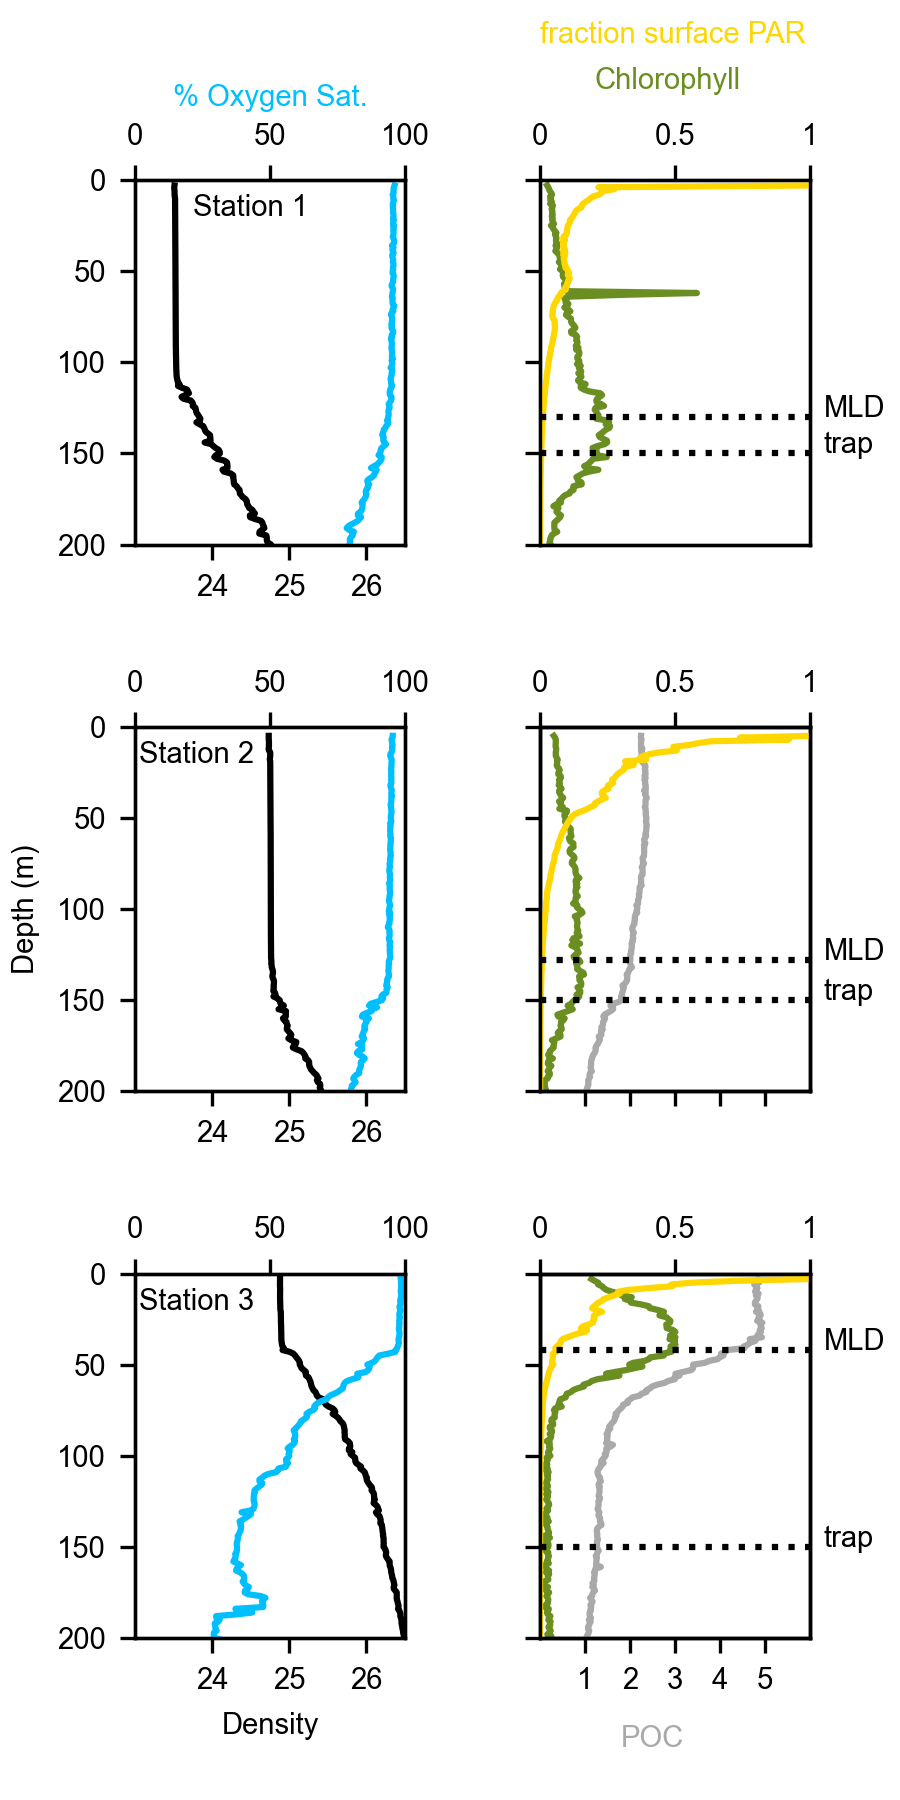

/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_925/1280226508.py:16: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_925/1280226508.py:30: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_925/1280226508.py:47: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_925/1280226508.py:64: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_925/1280226508.py:81: UserWarning:

FixedFormatter should only be used together with FixedLocator

/var/folders/26/gwgrn4h96_n037dhxyt88br4000bkb/T/ipykernel_925/1280226508.py:94: UserWarning:

FixedFormatter should only be used together with FixedLocator



In [154]:
f,((ax1,ax3),(ax6,ax8),(ax11,ax13))=plt.subplots(3,2,sharey='all',figsize=(3,6),dpi=300)
cast=CTD_data[CTD_data['CTD ']==4]
ax1.tick_params(top=True,labeltop=True,bottom=False,labelbottom=False)
ax1.plot(cast.density,cast.depth,color='black')
ax1.set_ylim(200,0)
ax1.set_xlim(23,26.5)
ax1.set_xticks([24,25,26])
ax1.set_xticklabels([24,25,26],family='Arial',size=7)
ax1.set_yticks([0,50,100,150,200])
ax1.set_yticklabels([0,50,100,150,200],family='Arial',size=7)
ax2=ax1.twiny()
ax2.plot(cast['Oxygen (percent)'],cast.depth,color='deepskyblue')
ax2.set_xlim(0,100)
ax2.tick_params(top=True,labeltop=True,bottom=False,labelbottom=False)
ax2.set_xlabel('% Oxygen Sat.',color='deepskyblue',size=7,family='Arial')
ax2.set_xticklabels([0,50,100],family='Arial',size=7)
ax3.plot(cast.Chl_corr,cast.depth,color='olivedrab')
ax3.tick_params(top=True,labeltop=True,bottom=False,labelbottom=False)
ax3.set_xlim(0,1)
ax3.set_xticks([])
ax4=ax3.twiny()
ax4.plot(cast.PAR/cast.PAR.max(),cast.depth,color='gold')
ax4.set_xlim(0,1)
ax4.plot([0,1],[130,130],color='black',ls=':')
ax4.plot([0,1],[150,150],color='black',ls=':')
ax4.text(1.05,130,'MLD',family='Arial',size=7)
ax4.text(1.05,150,'trap',family='Arial',size=7)
ax4.text(0,-75,'fraction surface PAR',color='gold',family='Arial',size=7)
ax4.text(0.2,-50,'Chlorophyll',color='olivedrab',family='Arial',size=7)
ax4.set_xticklabels([0,0.5,1],size=7,family='Arial')
ax1.text(23.75,20,'Station 1',family='Arial',size=7)

cast=CTD_data[CTD_data['CTD ']==15]
ax6.tick_params(top=True,labeltop=True,bottom=False,labelbottom=False)
ax6.plot(cast.density,cast.depth,color='black')
ax6.set_ylim(200,0)
ax6.set_xlim(23,26.5)
ax6.set_xticks([24,25,26])
ax6.set_xticklabels([24,25,26],family='Arial',size=7)
ax6.set_yticks([0,50,100,150,200])
ax6.set_yticklabels([0,50,100,150,200],family='Arial',size=7)
ax6.set_ylabel('Depth (m)',family='Arial',size=7)
ax7=ax6.twiny()
ax7.plot(cast['Oxygen (percent)'],cast.depth,color='deepskyblue')
ax7.set_xlim(0,100)
ax7.tick_params(top=True,labeltop=True,bottom=False,labelbottom=False)
ax7.set_xticklabels([0,50,100],family='Arial',size=7)
ax8.plot(cast.Chl_corr,cast.depth,color='olivedrab')
ax8.tick_params(top=True,labeltop=True,bottom=False,labelbottom=False)
ax8.set_xlim(0,1)
ax8.set_xticks([])
ax10=ax8.twiny()
ax10.plot(cast.BeamC_POC_ex/12,cast.depth,color='darkgrey')
ax10.set_xlim(0,6)
ax10.set_xticks([1,2,3,4,5])
ax10.set_xticklabels(['','','','',''],family='Arial',size=7)
ax9=ax10.twiny()
ax9.plot(cast.PAR/cast.PAR.max(),cast.depth,color='gold')
ax9.set_xlim(0,1)
ax9.plot([0,1],[128,128],color='black',ls=':')
ax9.plot([0,1],[150,150],color='black',ls=':')
ax9.text(1.05,128,'MLD',family='Arial',size=7)
ax9.text(1.05,150,'trap',family='Arial',size=7)
ax9.set_xticklabels([0,0.5,1],size=7,family='Arial')
ax6.text(23.05,20,'Station 2',family='Arial',size=7)

cast=CTD_data[CTD_data['CTD ']==29]
ax11.tick_params(top=True,labeltop=True,bottom=False,labelbottom=False)
ax11.plot(cast.density,cast.depth,color='black')
ax11.set_ylim(200,0)
ax11.set_xlim(23,26.5)
ax11.set_xlabel('Density',family='Arial',size=7)
ax11.set_xticks([24,25,26])
ax11.set_xticklabels([24,25,26],family='Arial',size=7)
ax11.set_yticks([0,50,100,150,200])
ax11.set_yticklabels([0,50,100,150,200],family='Arial',size=7)
ax12=ax11.twiny()
ax12.plot(cast['Oxygen (percent)'],cast.depth,color='deepskyblue')
ax12.set_xlim(0,100)
ax12.tick_params(top=True,labeltop=True,bottom=False,labelbottom=False)
ax12.set_xticklabels([0,50,100],family='Arial',size=7)
ax13.plot(cast.Chl_corr,cast.depth,color='olivedrab')
ax13.tick_params(top=True,labeltop=True,bottom=False,labelbottom=False)
ax13.set_xlim(0,1)
ax13.set_xticks([])
ax15=ax13.twiny()
ax15.plot(cast.BeamC_POC_ex/12,cast.depth,color='darkgrey')
ax15.set_xticks([1,2,3,4,5])
ax15.set_xticklabels([1,2,3,4,5],family='Arial',size=7)
ax15.set_xlim(0,6)
ax14=ax15.twiny()
ax14.plot(cast.PAR/cast.PAR.max(),cast.depth,color='gold')
ax14.set_xlim(0,1)
ax14.set_xticklabels([0,0.5,1],size=7,family='Arial')
ax14.plot([0,1],[42,42],color='black',ls=':')
ax14.plot([0,1],[150,150],color='black',ls=':')
ax14.text(1.05,42,'MLD',family='Arial',size=7)
ax14.text(1.05,150,'trap',family='Arial',size=7)
ax14.text(0.3,260,'POC',family='Arial',size=7,color='darkgrey')
ax11.text(23.05,20,'Station 3',family='Arial',size=7)




f.subplots_adjust(hspace=0.5,wspace=0.5,left=0.15,bottom=0.09,top=0.9)    


In [93]:
chemtax=pd.read_csv('Chemtax.csv')

In [133]:
diatom_mmolC_m2=chemtax['Sum Diatom Carbon'].mean()/12*42
dino_mmolC_m2=chemtax['Total Dino Carbon'].mean()/12*42
hacrobia_mmolC_m2=chemtax[['Cocco Carbon','Crypto Carbon']].sum(axis=1).mean()/12*42

ochrophyte_mmolC_m2=chemtax['Pelago Carbon'].mean()/12*42

chlorophyte_mmolC_m2=chemtax['Green Algae carbon'].mean()/12*42


In [134]:
print(diatom_mmolC_m2)
print(dino_mmolC_m2)
print(hacrobia_mmolC_m2)
print(ochrophyteC_mmolC_m2)
print(chlorophyteC_mmolC_m2)

8.05
4.573333333333333
23.334499999999995
14.513333333333335
16.310000000000002


In [145]:
St3_surface_exported_ochrophyte_large_relative_reads=[]
St3_surface_exported_ochrophyte_small_relative_reads=[]

for asv in St3_exported_relative_reads_ochrophytes.index:
    if asv in St3_large_particle_ASVs:
        St3_surface_exported_ochrophyte_large_relative_reads.append(St3_exported_relative_reads_ochrophytes.loc[asv])
    elif asv in St3_large_only_particles_ASVs:
        St3_surface_exported_ochrophyte_large_relative_reads.append(St3_exported_relative_reads_ochrophytes.loc[asv])
    elif asv in St3_small_particle_ASVs:
        St3_surface_exported_ochrophyte_small_relative_reads.append(St3_exported_relative_reads_ochrophytes.loc[asv])

St3_surface_exported_diatoms_large_relative_reads=[]
St3_surface_exported_diatoms_small_relative_reads=[]

for asv in St3_exported_relative_reads_diatoms.index:
    if asv in St3_large_particle_ASVs:
        St3_surface_exported_diatoms_large_relative_reads.append(St3_exported_relative_reads_diatoms.loc[asv])
    elif asv in St3_large_only_particles_ASVs:
        St3_surface_exported_diatoms_large_relative_reads.append(St3_exported_relative_reads_diatoms.loc[asv])
    elif asv in St3_small_particle_ASVs:
        St3_surface_exported_diatoms_small_relative_reads.append(St3_exported_relative_reads_diatoms.loc[asv])

St3_surface_exported_dinos_large_relative_reads=[]
St3_surface_exported_dinos_small_relative_reads=[]

for asv in St3_exported_relative_reads_dinoflagellates.index:
    if asv in St3_large_particle_ASVs:
        St3_surface_exported_dinos_large_relative_reads.append(St3_exported_relative_reads_dinoflagellates.loc[asv])
    elif asv in St3_large_only_particles_ASVs:
        St3_surface_exported_dinos_large_relative_reads.append(St3_exported_relative_reads_dinoflagellates.loc[asv])
    elif asv in St3_small_particle_ASVs:
        St3_surface_exported_dinos_small_relative_reads.append(St3_exported_relative_reads_dinoflagellates.loc[asv])

St3_surface_exported_chlorophytes_large_relative_reads=[]
St3_surface_exported_chlorophytes_small_relative_reads=[]

for asv in St3_exported_relative_reads_chlorophytes.index:
    if asv in St3_large_particle_ASVs:
        St3_surface_exported_chlorophytes_large_relative_reads.append(St3_exported_relative_reads_chlorophytes.loc[asv])
    elif asv in St3_large_only_particles_ASVs:
        St3_surface_exported_chlorophytes_large_relative_reads.append(St3_exported_relative_reads_chlorophytes.loc[asv])
    elif asv in St3_small_particle_ASVs:
        St3_surface_exported_chlorophytes_small_relative_reads.append(St3_exported_relative_reads_chlorophytes.loc[asv])


St3_surface_exported_hacrobia_large_relative_reads=[]
St3_surface_exported_hacrobia_small_relative_reads=[]

for asv in St3_exported_relative_reads_hacrobia.index:
    if asv in St3_large_particle_ASVs:
        St3_surface_exported_hacrobia_large_relative_reads.append(St3_exported_relative_reads_hacrobia.loc[asv])
    elif asv in St3_large_only_particles_ASVs:
        St3_surface_exported_hacrobia_large_relative_reads.append(St3_exported_relative_reads_hacrobia.loc[asv])
    elif asv in St3_small_particle_ASVs:
        St3_surface_exported_hacrobia_small_relative_reads.append(St3_exported_relative_reads_hacrobia.loc[asv])



In [149]:
print('surface Hacroba to small particles (mmol m-2)')
print(np.sum(St3_surface_exported_hacrobia_small_relative_reads)*hacrobia_mmolC_m2)
print('surface Hacroba to large particles (mmol m-2)')
print(np.sum(St3_surface_exported_hacrobia_large_relative_reads)*hacrobia_mmolC_m2)


print('surface Dinoflagellates to small particles (mmol m-2)')
print(np.sum(St3_surface_exported_dinos_small_relative_reads)*dino_mmolC_m2)
print('surface Dinoflagellates to large particle (mmol m-2)')
print(np.sum(St3_surface_exported_dinos_large_relative_reads)*dino_mmolC_m2)

print('surface Diatoms to small particles (mmol m-2)')
print(np.sum(St3_surface_exported_diatoms_small_relative_reads)*diatom_mmolC_m2)
print('surface Diatoms to large particle (mmol m-2)')
print(np.sum(St3_surface_exported_diatoms_large_relative_reads)*diatom_mmolC_m2)

print('surface ochrophytes to small particles (mmol m-2)')
print(np.sum(St3_surface_exported_ochrophyte_small_relative_reads)*ochrophyte_mmolC_m2)
print('surface ochrophytes to large particle (mmol m-2)')
print(np.sum(St3_surface_exported_ochrophyte_large_relative_reads)*ochrophyte_mmolC_m2)

print('surface Chlorophytes to small particles (mmol m-2)')
print(np.sum(St3_surface_exported_chlorophytes_small_relative_reads)*chlorophyte_mmolC_m2)
print('surface Chlorophytes to large particle (mmol m-2)')
print(np.sum(St3_surface_exported_chlorophytes_large_relative_reads)*chlorophyte_mmolC_m2)

surface Hacroba to small particles (mmol m-2)
1.0032972791400736
surface Hacroba to large particles (mmol m-2)
2.672846657709102
surface Dinoflagellates to small particles (mmol m-2)
0.19311015848272278
surface Dinoflagellates to large particle (mmol m-2)
3.280021044427124
surface Diatoms to small particles (mmol m-2)
0.3196869070208729
surface Diatoms to large particle (mmol m-2)
5.952941176470589
surface ochrophytes to small particles (mmol m-2)
0.0429388560157791
surface ochrophytes to large particle (mmol m-2)
8.340361604207759
surface Chlorophytes to small particles (mmol m-2)
1.1679887121600823
surface Chlorophytes to large particle (mmol m-2)
13.86493458183684
